## Script to parse behavioral data from pickle files

The purpose of this notebook is to parse the behavioral data in the appropriate pickle files into a format that is easily usable for analysis and plotting.

The pickle files for each animal contain dictionaries where the keys are session names and the values are lists of trials where every trial is a dictionary of this form:

```            trial = {
                'trial_num': 347,
                'stim_presentation_time': 1134567, # in microseconds
                'behavior_outcome_time': 1734567, # in microseconds
                'reaction_time': 600000, # in microseconds
                'behavior_outcome': 'success', # can be 'success', 'failure' or 'ignore'
                'BlobIdentityIdx': 1, # can be 1 or 2
            }
```

Continue below for how these data will be transformed. Make sure to run these cells in order.

### Dependencies

In [3]:
from __future__ import division
import csv
import hddm
import os
import math
import random
import scipy
from pylab import figure
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pymworks
import pickle
import pandas as pd
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')


### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [4]:
bootstrap_iterations = 100 # choose number of bootstrap iterations for calculating performance error
wiggle_session_indices = False # for binning data over normalized session time. if True adds random noise to session_indices so they don't completely overlap if same number of sessions, etc

##### Location of files

In [5]:
# filepaths of data to analyze

# regular stim learning
fp_AK_AL = '_data/AK_and_AL_Cohorts/10fullcross_experiment_with_ignores/canonical_size_deptrotrl_10fullcross/pickle_files_by_session/'

fp_AK_AL_last10 = '_data/AK_and_AL_Cohorts/last10fullcross/pickle_files_by_session/'

# regular stim learning only canonical
fp_AN = '_data/AN_Cohort/canonical_only_with_ignores/pickle_files_by_session/'

# regular no min RT
fp_nominrt = '_data/AK_Cohort/6_fullcrossnominrt_with_ignores/pickle_files_by_session/'

 # long timeout
fp_longtimeout = '_data/AM_and_AO_Cohorts/trained_on_longtimeout_with_ignores/last10_fullcross/4_fullcross/pickle_files_by_session/'

# stimB learning
fp_stimB_base = '_data/AL_and_AM_Cohorts/newshapes_experiment_with_ignores/6_baselinefullcross/180825_to_180913/pickle_files_by_session/'
fp_stimB = '_data/AL_and_AM_Cohorts/newshapes_experiment_with_ignores/6_stimB/180914_to_181004/pickle_files_by_session/'

# transparent/dim
fp_transp_base = '_data/AK_Cohort/transparency_experiment_with_ignores/fullcross_before_transparency/180620_to_180624/pickle_files_by_session/'
fp_transp = '_data/AK_Cohort/transparency_experiment_with_ignores/transparency/180625_to_180830/pickle_files_by_session/'

# fp_transp_base_stimcoding = '_data/AK_Cohort/transparency_experiment/fullcross_before_transparency_psytrack/180620_to_180624/pickle_files_by_session/'
# fp_transp_stimcoding = '_data/AK_Cohort/transparency_experiment/transparency_psytrack/180625_to_180830/pickle_files_by_session/'

# stimC learning with RT bounds
fp_stimC_rtbound_base = '_data/AL_and_AM_Cohorts/newshapes_experiment_with_ignores/6_baselinefullcross/180825_to_180913/pickle_files_by_session/'
fp_stimC_rtbound = '_data/AL_and_AM_Cohorts/rtbound_experiment_with_ignores/7_stimCrtbound/181022_to_181101/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'rt_with_ignores_by_trial: rt_with_ignores_by_trial,'
    'outcome_by_trial': outcome_by_trial,
    'outcome_with_ignores_by_trial': outcome_with_ignores_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'beh_outcome_with_ignores_by_session': beh_outcome_with_ignores_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'pct_ignore_by_session': pct_ignore_by_session,
    'pct_ignore_bootstrap_error_by_session': pct_ignore_bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    }
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **rt_with_ignores_by_trial** : list of individual trial reaction times including ignores across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **outcome_with_ignores_by_trial** : list of individual trial outcomes ('success', 'failure', 'ignore') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file
- **stim_id_by_trial** : list of individual trial stimulus identities (e.g. 0, 1) across all sessions in pickle file

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **beh_outcome_with_ignores_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure', 'ignore')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals
- **iti_success_by_session**: dict where key = session, val = individual trial intertrial intervals for previous correct/success trials
- **iti_failure_by_session**: dict where key = session, val = individual trial intertrial intervals for previous incorrect/failure trials
- **stim_id_by_session**: dict where key = session, val = individual trial stimulus identities (e.g. 0, 1) 

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **pct_correct_bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
- **pct_ignore_by_session** : dict where key = session, val = percent trials ignored for that session
- **pct_ignore_bootstrap_error_by_session** : dict where key = session, val = bootstrapped percent trials ignored error for that session
- **hitrate_falsealarms_by_session** : dict where key = session, val = dictionary with hitrate/falsealarm variables
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for failure trials in that session
- **rt_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for all success & failure trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [6]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = data.keys()[0]# get animal name

        # notify the user of the sessions that are read
        print ' '
        print 'Read data from', animal, 'for...'
        print 'sessions:'
        for session in sorted(data[animal].keys()):
            print session

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    rt_with_ignores_by_trial = data_by_trial['rt_with_ignores_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    outcome_with_ignores_by_trial = data_by_trial['outcome_with_ignores_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    stim_id_by_trial = data_by_trial['stim_id_by_trial']
    stim_id_with_ignores_by_trial = data_by_trial['stim_id_with_ignores_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    beh_outcome_with_ignores_by_session = data_by_session['beh_outcome_with_ignores_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_with_ignores_by_session = data_by_session['rt_with_ignores_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    iti_success_by_session = data_by_session['iti_success_by_session']
    iti_failure_by_session = data_by_session['iti_failure_by_session']
    stim_id_by_session = data_by_session['stim_id_by_session']
    stim_id_with_ignores_by_session = data_by_session['stim_id_with_ignores_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_bootstrap_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_bootstrap_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_bootstrap_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    pct_correct_bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    pct_ignore_by_session = pct_ignore(beh_outcome_with_ignores_by_session)
    pct_ignore_bootstrap_error_by_session = bootstrap_pct_ignore(beh_outcome_with_ignores_by_session, bootstrap_iterations)
    hitrate_falsealarms_by_session = hitrate_falsealarms(beh_outcome_by_session, rt_by_session, stim_id_by_session)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    
# need to update:

# rt_with_ignores_by_session   ~~ CHECK
# stim_id_with_ignores_by_session  ~~ CHECK

# outcome_with_ignores_by_trial
# rt_with_ignores_by_trial
# stim_id_with_ignores_by_trial  
    
    
    
    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'rt_with_ignores_by_trial': rt_with_ignores_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'outcome_with_ignores_by_trial': outcome_with_ignores_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'stim_id_with_ignores_by_trial': stim_id_with_ignores_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'beh_outcome_with_ignores_by_session': beh_outcome_with_ignores_by_session,
    'rt_by_session': rt_by_session,
    'rt_with_ignores_by_session': rt_with_ignores_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'stim_id_with_ignores_by_session': stim_id_with_ignores_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'pct_ignore_by_session': pct_ignore_by_session,
    'pct_ignore_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    rt_with_ignores = []
    outcome = []
    outcome_with_ignores = []
    iti = []
    stim_id = []
    stim_id_with_ignores = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                rt_with_ignores.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                outcome_with_ignores.append(trials[trial_index]['behavior_outcome'])
                # append stimulus identity
                stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx'])
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time_with_ignores'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                    iti.append(inter_trial_interval)
                    
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome_with_ignores'] == 'ignore':
                outcome_with_ignores.append(trials[trial_index]['behavior_outcome'])
                rt_with_ignores.append(trials[trial_index]['reaction_time'])
                stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx'])
          
    data_by_trial = {
    'rt_by_trial': rt,
    'rt_with_ignores_by_trial': rt_with_ignores,
    'outcome_by_trial': outcome,
    'outcome_with_ignores_by_trial': outcome_with_ignores,
    'iti_by_trial': iti,
    'stim_id_by_trial': stim_id,
    'stim_id_with_ignores_by_trial': stim_id_with_ignores
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    beh_outcome_with_ignores_by_session = {}
    rt_by_session = {}
    rt_with_ignores_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    iti_success_by_session = {}
    iti_failure_by_session = {}
    stim_id_by_session = {}
    stim_id_with_ignores_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_rt_with_ignores = []
        session_behavior_outcome = []
        session_behavior_outcome_with_ignores = []
        session_stim_id = []
        session_stim_id_with_ignores = []
        session_iti = []
        session_success_iti = []
        session_failure_iti = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: 
                session_rt.append(trials[trial_index]['reaction_time'])
                session_rt_with_ignores.append(trials[trial_index]['reaction_time']) # WITH IGNORES
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome']) 
                session_behavior_outcome_with_ignores.append(trials[trial_index]['behavior_outcome']) # WITH IGNORES
                session_stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                session_stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx']) # WITH IGNORES
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
            elif trials[trial_index]['behavior_outcome_with_ignores'] == 'ignore':
                session_behavior_outcome_with_ignores.append(trials[trial_index]['behavior_outcome_with_ignores']) # WITH IGNORES
                session_rt_with_ignores.append(trials[trial_index]['reaction_time_with_ignores']) # WITH IGNORES
                session_stim_id_with_ignores.append(trials[trial_index]['BlobIdentityIdx']) # WITH IGNORES
                
            # intertrial interval analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # only do ITI analysis for success/failure trials
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    session_iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time_with_ignores'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                    session_iti.append(inter_trial_interval)

                    if trials[trial_index - 1]['behavior_outcome'] == 'success': # create separate list with previous success trial itis
                        session_success_iti.append(inter_trial_interval)
                    elif trials[trial_index - 1]['behavior_outcome'] == 'failure': # create separate list with previous failure trial itis
                        session_failure_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        beh_outcome_with_ignores_by_session[session] = session_behavior_outcome_with_ignores
        rt_by_session[session] = session_rt
        rt_with_ignores_by_session[session] = session_rt_with_ignores
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        iti_success_by_session[session] = session_success_iti
        iti_failure_by_session[session] = session_failure_iti
        stim_id_by_session[session] = session_stim_id
        stim_id_with_ignores_by_session[session] = session_stim_id_with_ignores
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'beh_outcome_with_ignores_by_session': beh_outcome_with_ignores_by_session,
    'rt_by_session': rt_by_session,
    'rt_with_ignores_by_session': rt_with_ignores_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'stim_id_with_ignores_by_session': stim_id_with_ignores_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

def pct_ignore(beh_out_with_ignores_by_session):
    pct_ignore_by_session = {}
    for session in sorted(beh_out_with_ignores_by_session.iterkeys()):
        outcomes = beh_out_with_ignores_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['ignore'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_ignore_by_session[session] = pct
    return pct_ignore_by_session

def bootstrap_pct_ignore(beh_out_with_ignores_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_with_ignores_by_session.iterkeys()):
        outcomes = beh_out_with_ignores_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['ignore'] / total_trials
                list_of_pct.append(pct)
            mean_pct_ignore = np.std(list_of_pct)
        elif total_trials == 0:
            mean_pct_ignore = float('nan')
        bootstrap_error_by_session[session] = mean_pct_ignore
    return bootstrap_error_by_session


def safe_division(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0
    
def hitrate_falsealarms(beh_out_by_session, rt_by_session, stim_id_by_session):
    hitrate_falsealarms_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        stim_ids = stim_id_by_session[session]
        possible_stim_ids = set(stim_ids)
        hitrate_falsealarms = dict.fromkeys(possible_stim_ids, 0)
        for stim_id in possible_stim_ids:
            hits = 0
            falsealarms = 0
            total_signal_stim = 0
            total_noise_stim = 0
            hits_rt = []
            falsealarms_rt = []
            total_signal_stim_rt = []
            total_noise_stim_rt = []
            for trial in range(len(stim_id_by_session[session])):
                if stim_id_by_session[session][trial] == stim_id:
                    total_signal_stim += 1
                    total_signal_stim_rt.append(rt_by_session[session][trial])
                    if beh_out_by_session[session][trial] == 'success':
                        hits += 1
                        hits_rt.append(rt_by_session[session][trial])
                elif stim_id_by_session[session][trial] != stim_id:
                    total_noise_stim += 1
                    total_noise_stim_rt.append(rt_by_session[session][trial])
                    if beh_out_by_session[session][trial] == 'failure':
                        falsealarms += 1
                        falsealarms_rt.append(rt_by_session[session][trial])
            hitrate_falsealarms[stim_id] = {
                'hits_signal_stim': hits,
                'total_signal_stim': total_signal_stim,
                'falsealarms_noise_stim': falsealarms,
                'total_noise_stim': total_noise_stim,
                'hit_rate_signal_stim': safe_division(hits, total_signal_stim),
                'falsealarm_rate_noise_stim': safe_division(falsealarms, total_noise_stim),
                'hits_signal_stim_rt': hits_rt,
                'total_signal_stim_rt': total_signal_stim_rt,
                'falsealarms_noise_stim_rt': falsealarms_rt,
                'total_noise_stim_rt': total_noise_stim_rt}
        hitrate_falsealarms_by_session[session] = hitrate_falsealarms
    return hitrate_falsealarms_by_session
                    

# ~~~~~~~~~~ Get relevant data ~~~~~~~~~~

def get_relevant_data(all_data_dict, relevant_data, all_sessions = True, sessions_to_count = 99, sessions_from_start = False):
    '''
    function that creates smaller dictionaries where animals are keys and values are lists of all data by session, or collapsed to one list
    
    input:
    all_data_dict:       dictionary outputted by open_pickle_files_and_analyze()
    relevant_data:       key for values in all_data_dict (string)
                           NOTE: this key should be for data organized by session, not by trial!
    all_sessions:        boolean var determining whether all sessions are included (True) or not (False)
                           if False, need to determine sessions_to_count, and sessions_from_start
    sessions_to_count:   number of sessions to count (i.e. 10 if want 10 sessions)
    sessions_from_start: boolean var determining whether sessions are counted from beginning of sorted list (True) or end (False)
                           e.g. if want only last 10 sessions, then: 
                           sessions_to_count = 10, sessions_from_start = False
    
    output:
    relevant_data_dict:  dictionary where key = animal, value = list of data from relevant_data key
                           where every list entry is from one session and sessions have been sorted
                           in the case of averages, such as "avg_rt_by_session", each list entry is a number
                           in the case of lists, such as "rt_by_session", each list entry is a list              
    '''
    relevant_data_dict = {}
    for animal in all_data_dict.iterkeys():
        if all_sessions == True:
            for session in sorted(all_data_dict[animal][relevant_data].keys()):
                try:
                    relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                except KeyError:
                    relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
        elif all_sessions == False:
            if sessions_from_start == True:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[:sessions_to_count]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
            elif sessions_from_start == False:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[-sessions_to_count:]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
    return relevant_data_dict

# ~~~~~~~~~~ Prepare inter-trial intervals ~~~~~~~~~~

def adjust_itis(iti_data, min_Drsi):
    '''
    adjust itis by subtracting minimum Drsi (Derr or Dcorr depending on type of iti) function
    '''
    iti_data_adj = {}
    for animal in iti_data.keys():
        for session in iti_data[animal]:
            try:
                iti_data_adj[animal].append([i - min_Drsi for i in session])
            except KeyError:
                iti_data_adj[animal] = [[i - min_Drsi for i in session]]
    return iti_data_adj

def avg_adjusted_itis(iti_data_adj, boundary = 2000):
    '''
    take mean of itis for all values under the boundary (don't count itis beyond the boundary') function
    '''
    iti_data_adj_mean = {}
    iti_data_adj_sem = {}
    iti_data_adj_median = {}
    for animal in iti_data_adj.keys():
        for session in iti_data_adj[animal]:
            session_below_boundary = [i for i in session if i < boundary]
            try:
                iti_data_adj_mean[animal].append(np.nanmean(session_below_boundary))
                iti_data_adj_median[animal].append(np.nanmedian(session_below_boundary))
                # regular sem
#                 iti_data_adj_sem[animal].append(stats.sem([i for i in session if i < boundary]))
            except KeyError:
                iti_data_adj_mean[animal] = [np.nanmean(session_below_boundary)]
                iti_data_adj_median[animal] = [np.nanmedian(session_below_boundary)]
#                 iti_data_adj_sem[animal] = [stats.sem([i for i in session if i < boundary])]

            # calculate bootstrap sem
            if len(session_below_boundary) > 0:
                list_of_avg = []
                for i in xrange(bootstrap_iterations):
                    r = np.random.choice(session_below_boundary, len(session_below_boundary))
                    avg = np.mean(r)
                    list_of_avg.append(avg)
                mean_error = np.std(list_of_avg)
                try:
                    iti_data_adj_sem[animal].append(mean_error)
                except KeyError:
                    iti_data_adj_sem[animal] = [mean_error]
            else:
                try:
                    iti_data_adj_sem[animal].append(float('nan'))
                except KeyError:
                    iti_data_adj_sem[animal] = [float('nan')]
    return iti_data_adj_mean, iti_data_adj_sem, iti_data_adj_median

# ~~~~~~~~~~ Convert reaction times to mean normalized decision times ~~~~~~~~~~

def convert_RTs_to_DTs(rts, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dts = {}
    for animal in rts.keys():
        if with_itis == True:
            for sesh in range(len(rts[animal])):
                try:
                    dts[animal].append((rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh]))
                except KeyError:
                    dts[animal] = [(rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh])]
        elif with_itis == False:
            dts[animal] = [(i - t0)/(t0 + derr) for i in rts[animal]]
    return dts

def calc_DT_err(rt_err, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dt_err = {}
    for animal in rt_err.keys():
        if with_itis == True:
            for sesh in range(len(rt_err[animal])):
                sum_sqrd_err = math.sqrt(rt_err[animal][sesh]**2 + iti_err[animal][sesh]**2)
                adj_err = sum_sqrd_err / (t0 + derr + iti_err[animal][sesh])
                try:
                    dt_err[animal].append(adj_err)
                except KeyError:
                    dt_err[animal] = [adj_err]
        elif with_itis == False:
            dt_err[animal] = [i/(t0 + derr) for i in rt_err[animal]]
        
    return dt_err

# ~~~~~~~~~~ Mesh data to create averages over learning ~~~~~~~~~~

def mesh_data(results, datakey = 'none'):
    '''
    input:
        results = dict where keys = animals, values = either dictionary with data or a list with data
        datakey = if not 'none', keys to dictionary with data
                  if none - values of results are lists
                  
    output:
        meshed_data = dict containing meshed data and meshed indices
    '''
    
    d = {}
    for animal in results.keys():
#         i = results[animal]['norm_session_indices'] # indexed session list comes pre-made from get_data_for_figure()
        if datakey == 'none':
            i = [(x+1)/len(results[animal]) for x in range(len(results[animal]))]
            y_data = results[animal]
        elif datakey != 'none':
            i = [(x+1)/len(results[animal][datakey]) for x in range(len(results[animal][datakey]))]
            y_data = results[animal][datakey]
        
        y = []
        
        if type(y_data) == dict:
            for session in sorted(y_data.iterkeys()):
                y.append(y_data[session])
            d[animal] = {'i': i, 'y': y}
        elif type(y_data) == list:
            y = y_data
            d[animal] = {'i': i, 'y': y}

    all_y = []
    all_i = []
    for a in d.iterkeys():
        # print 'key = ' + a
        if len(all_i) == 0:
            # print 'in if statement'
            all_i = d[a]['i']
            all_y = d[a]['y']
            # print all_i
            # print all_x
        else:
            # print 'in else statement'
            for j in range(len(d[a]['i'])):
                # print 'first for loop'
                for i in range(len(all_i)):
                    # print 'second for loop'
                    if all_i[i] >= d[a]['i'][j]:
                        #print 'first half'
                        #print all_x[:i]
                        all_i = all_i[:i] + [d[a]['i'][j]] + all_i[i:]
                        all_y = all_y[:i] + [d[a]['y'][j]] + all_y[i:]
                        # print all_i
                        # print all_x
                        break

    # print 'all_x:', all_x
    # print ' '
    # print 'all_i:', all_i

    meshed_data = {'all_i': all_i, 'all_y': all_y}

    return meshed_data

def avg_binned_data(meshed_data, n_bins):
    x_data = meshed_data['all_i']
    y_data = meshed_data['all_y']

    # if every animal has the exact number of sessions, add some noise to the indices to shuffle them:
    if wiggle_session_indices == True:
        x_data = [(i+(random.uniform(-1,1)/25)) for i in x_data]
    else:
        pass


    n_bins = n_bins
    
    x_n, x_bins, x_patches = plt.hist(x_data, bins = n_bins)

    # based on the bins for x_data, bin y_data
    # note that this code creates an extra bin at the end because there is one more bin value than bins
    # that is fixed with a for loop below
    y_bins = []
    for i in range(len(x_bins)):
        y_bin = []
        for j in range(len(x_data)):
            if i < (len(x_bins)-1):
                if (x_data[j] >= x_bins[i] and (x_data[j] < x_bins[i+1])):
                    y_bin.append(y_data[j])
                else:
                    pass
            elif i >= (len(x_bins)-1):
                if x_data[j] == (x_bins[i]):
                    y_bin.append(y_data[j])
                else:
                    pass
        y_bins.append(y_bin)

    # the above code creates an extra bin at the end
    # this for loop combines the last two bins
    for i in range(len(y_bins)):
        if i == (len(y_bins)-1):
            y_bins[i-1] = y_bins[i-1] + y_bins[i]
            y_bins.pop(i)
        else:
            pass

    # calculate the mean for values in every bin
    y_bins_mean = []
    y_bins_std = []
    y_bins_sem = []
    y_bins_median = []
    y_bins_25percentile = []
    y_bins_75percentile = []
    for i in y_bins:
#         if 0 in i:
#             i = [0.001 if x == 0 else x for x in i] # if there are zeroes, convert to small values to not have issues with averaging
#         else:
#             pass
        y_bins_mean.append(np.nanmean(i))
        y_bins_median.append(np.nanmedian(i))
        y_bins_25percentile.append(np.nanmedian(i) - np.nanpercentile(i, q = 25))
        y_bins_75percentile.append(np.nanpercentile(i, q = 75) - np.nanmedian(i))
        y_bins_std.append(np.nanstd(i))
        y_bins_sem.append(np.nanstd(i)/math.sqrt(len(i)))

    # calculate bin centers in order to plot the mean
    x_bincenters = [np.mean([x_bins[i],x_bins[i+1]]) for i in range(len(x_bins)-1)]

#     # Plot
#     xmin = -0.05 # indexed sessions from 0 to 1
#     xmax = 1.05
#     ymin = 0.4 # performance from 0 to 1
#     ymax = 1.0

#     fig = plt.figure()
#     plt.plot(x_data, y_data, 'r.', markersize=10, label=u'observations')
#     plt.errorbar(x_bincenters, y_bins_mean, yerr = y_bins_sem, fmt = 'bo-', label=u'binned average')
#     plt.xlabel('normalized session time')
#     plt.ylabel('mean performance $\pm$ sem')
#     plt.axis([xmin, xmax, ymin, ymax])
#     plt.legend(loc='lower right')
#     plt.savefig('AK_Cohort_perf_binned_avg.pdf')
#     plt.close()
#     # plt.show()

    avg_binned_data = {
    'x_bins': x_bins,
    'x_bincenters': x_bincenters,
    'y_bins': y_bins,
    'y_bins_mean': y_bins_mean,
    'y_bins_std': y_bins_std,
    'y_bins_sem': y_bins_sem,
    'y_bins_median': y_bins_median,
    'y_bins_25percentile': y_bins_25percentile,
    'y_bins_75percentile': y_bins_75percentile
    }

    return avg_binned_data

# ~~~~~~~~~~ calculate OPC curve ~~~~~~~~~~

def calculate_opc():
    #this function returns a dictionary with two arrays with which to plot an optimal performance curve (OPC)

    #eta = (A/sigma)^2 (signal to noise ratio (drift rate to noise))
    #theta = | threshold / A | (ratio of threshold over drift rate)
    
    #make arrays with all possible values for eta and theta
    etas = np.arange(0.0001, 4, 0.01)
    thetas = np.arange(0.0001, 2.5, 0.01)
    e, th = np.meshgrid(etas, thetas)
    #calculate possible error rates with etas and thetas
    #pre-calculate 2*etas to reduce clutter and make equation legible
    e_x_2 = np.multiply(2,e)
    p_err = (1/(1 + np.exp(e_x_2*th)))
    #p_err is a huge array of arrays, but we only need the last array
    ind = len(p_err) - 1
    p_err = p_err[ind]
    #calculate mean normalized decision time as a function of p_err
    #pre-calculate components of equation to reduce clutter and make equation legible
    term1 = 1 / np.multiply(p_err, np.log((1-p_err)/p_err))
    term2 = 1 / (1 - np.multiply(2, p_err))
    mean_norm_dt = 1 / (term1 + term2)

    return {'p_err': p_err, 'mean_norm_dt': mean_norm_dt}

# ~~~~~~~~~~ plot data in OPC space ~~~~~~~~~~

# use when inputs are dictionaries with animals as keys
def opc_during_learning(perf, perf_err, dt, dt_err, filename = '%s_opc_during_learning.pdf'):

    error_rate = {}
    error_rate_err = {}
    mean_norm_dt = {}
    mean_norm_dt_err = {}
    for animal in perf.keys():
        error_rate[animal] = [1 - i for i in perf[animal]]
        error_rate_err[animal] = perf_err[animal]
        mean_norm_dt[animal] = dt[animal]
        mean_norm_dt_err[animal] = dt_err[animal]

        opc = calculate_opc()
        x_opc = opc['p_err']
        y_opc = opc['mean_norm_dt']

        x = error_rate[animal]
        y = mean_norm_dt[animal]
        xerr = error_rate_err[animal]
        yerr = mean_norm_dt_err[animal]

        xmin = 0.0
        xmax = 0.55
        ymin = 0.0
        ymax = 0.5

        c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

        plt.close()
        plt.plot(x_opc, y_opc, label = 'opc')
        plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
        plt.axis([xmin, xmax, ymin, ymax])
        plt.xlabel('error rate $\pm$ sem')
        plt.ylabel('mean normalized DT $\pm$ sem')
        plt.title('%s learning trajectory' %animal)
        sns.despine()
        plt.savefig(filename %animal)
    
       
# use with meshed data or individual animal data to only make one plot during learning
def opc_during_learning_from_list(perf, perf_err, dt, dt_err, listname = 'X Rats', filename = '_opc_during_learning.pdf'):

    error_rate = [1 - i for i in perf]
    error_rate_err = perf_err
    mean_norm_dt = dt
    mean_norm_dt_err = dt_err

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.525
    ymin = 0.0
    ymax = 0.5

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))
#     c = plt.cm.spring(np.linspace(0,1,len(x)))

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
#     plt.errorbar(x, y, color = 'k', marker = '.', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + ' learning trajectory')
    sns.despine()
    plt.savefig(filename)
    
# color code points by frac max rr
def opc_avg_colored_by_frac_max_rr(perf, perf_err, dt, dt_err, pct_max_rr, listname = 'X Rats', filename = '_opc_avg_across_sessions.pdf'):

    error_rate = []
    error_rate_err = []
    mean_norm_dt = []
    mean_norm_dt_err = []
    frac_max_rr = []
    for animal in perf.keys():
        error_rate.append(1 - perf[animal])
        error_rate_err.append(perf_err[animal])
        mean_norm_dt.append(dt[animal])
        mean_norm_dt_err.append(dt_err[animal])
        frac_max_rr.append(pct_max_rr[animal])

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.5
    ymin = 0.0
    ymax = 0.55

    cmin = 0.90
    cmax = 1.0
    crange = cmax - cmin
    
    scaled_frac_max_rr = [(i - cmin)/crange for i in frac_max_rr] # rescale frac_max_rr to give color
#     cmap = plt.cm.Purples
    c = plt.cm.viridis(scaled_frac_max_rr)

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + 'average across sessions by frac max RR')
    sns.despine()
    plt.savefig(filename)

# ~~~~~~~~~~ calculate percent max reward rate ~~~~~~~~~~


# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr(rt, perf, t0):
    '''
    rt = reaction time, **must be in seconds**
    ER = error rate, 1 - performance
    '''
    
    Dcorr = 6.370 # correct trial ITI in s
    Derr = -3.234 # additional penalty time (can be negative) in s
#     T0 = 0.200 # non-decision time in s
    T0 = t0 # determine t0 from outside function
    
    Dtot = Dcorr + T0 + Derr # mean iti for error trials, including non-decision time
    
    # DT = Dtot*0.45 ## NEED TO FIGURE THIS OUT
    DT = rt - T0
    # ER = 0.1 # measured error rate
    ER = 1 - perf
    
    if perf <= 0.5:
        ER = 1 - 0.501
    else:
        ER = 1 - perf
    
    RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
    
    Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    
    # now compute the optimal reward rate given this SNR
    
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    RRoptimal = np.max(RRs)
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return fraction_max_rr

# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr_iti(rt, perf, t0 = 0.350, dcorr = 6.370, derr = 3.136, corr_iti = 0, err_iti = 0, with_itis = False):
    '''
    **all times must be in seconds**
    rt = reaction time
    ER = error rate, 1 - performance
    
    dcorr = experimental response-to-stimulus interval for previous correct trial
    derr = experimental response-to-stimulus interval for previous error trial
    corr_iti = extra voluntary ITI for a previous correct trial
    err_iti = extra voluntary ITI for a previous error trial
    with_itis = 
    
    '''
    
    # calculate DT and ER
    T0 = t0 # determine t0 from outside function
    DT = rt - T0
    ER = 1 - perf
    
#     if perf <= 0.5:
#         ER = 1 - 0.501
#     else:
#         ER = 1 - perf
    
    # calculate Dcorr, Derr
    if with_itis == True:
        Dcorr = dcorr + corr_iti # success time without iti or 300 ms blocking time, in seconds
        Derr = derr + err_iti # penalty time without iti or 300 ms blocking time, in seconds
        Derr_tilde = Derr - Dcorr # additional penalty time (negative when penalty time lesser than reward time) relative to Dcorr, in seconds
    elif with_itis == False:
        Dcorr = dcorr # correct trial ITI in s
        Derr = derr # additional penalty time (can be negative) in s
        Derr_tilde = Derr - Dcorr
    
    # calculate SNR (Abar) and possible ERs and DTs for that SNR
    Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    
    # calculate actual RR and possible RRs for that SNR
    if with_itis == True:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr)
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        # calculate RRs with extra voluntary ITIs
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr_tilde) for i,j in zip(ERs, DTs)]
        # calculate RRs without extra voluntary ITIs
        RRs = [(1 - i)/(j + (1 - i)*dcorr + T0 + i*(derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + dcorr + T0 + i*(derr - dcorr)) for i,j in zip(ERs, DTs)]
        
        
    elif with_itis == False:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        RRs = [(1 - i)/(j + (1 - i)*Dcorr + T0 + i*(Derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    
    # now compute the optimal reward rate given this SNR
    RRoptimal = np.max(RRs)
    RRoptimal_ind = np.argmax(RRs) # index of max RR
    
    ERoptimal = ERs[RRoptimal_ind] # use index of max RR to get optimal ER given Abar (SNR)
    PERFoptimal = 1 - ERoptimal
    
    DToptimal = DTs[RRoptimal_ind] # use index of max RR to get optimal DT given Abar (SNR)
    DToptimal_norm = DToptimal / (T0 + Derr)
    RToptimal = DToptimal + T0
    
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return {'fraction_max_rr': fraction_max_rr,
            'opportunity_cost': opportunity_cost,
            'Abar': Abar,
            'ERs': ERs,
            'DTs': DTs,
            'RRs': RRs,
            'RRoptimal': RRoptimal,
            'ERoptimal': ERoptimal,
            'PERFoptimal': PERFoptimal,
            'DToptimal': DToptimal,
            'RToptimal': RToptimal}

# average reaction times by quantiles
# for one subject at a time
# after vincentizing the subjects may be averaged

def vincentize_RTs(data, bins = 10):

    # sort data 
    data_sorted = sorted(data)

    # determine number of trials per bin
    n_per_bin = len(data)/bins
    n_per_bin = int(math.floor(n_per_bin))

    # perform Vincent averaging (vincentize) on RTs and ERs
    vin_RTs = []
    vin_RTs_sem = []
    bin_sizes = []
    bin_edges_RTs = []
    for current_bin in range(1,(bins+1)):
#         print 'current_bin =', current_bin
        if current_bin == 1:
#             print '  var:', var[0:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[0:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[0:current_bin*n_per_bin])/math.sqrt(len(data_sorted[0:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[0:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[0])
        elif 1 < current_bin < bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:current_bin*n_per_bin]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:current_bin*n_per_bin]))
            bin_edges_RTs.append(data_sorted[(current_bin-1)*n_per_bin])
        elif current_bin == bins:
#             print '  var:', var[(current_bin-1)*n_per_bin:-1]
            vin_RTs.append(np.mean(data_sorted[(current_bin-1)*n_per_bin:]))
            vin_RTs_sem.append(np.std(data_sorted[(current_bin-1)*n_per_bin:])/math.sqrt(len(data_sorted[(current_bin-1)*n_per_bin:])))
            bin_sizes.append(len(data_sorted[(current_bin-1)*n_per_bin:]))
            bin_edges_RTs.append(data_sorted[-1])

    return {'vin_RTs': vin_RTs,
            'vin_RTs_sem': vin_RTs_sem,
            'bin_sizes': bin_sizes,
            'bin_edges_RTs': bin_edges_RTs}

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [10]:
# regular stim learning with ignores
results_AK_AL = open_pickle_files_and_analyze(fp_AK_AL)

 
Read data from AK10 for...
sessions:
AK10_170614.mwk
AK10_170615.mwk
AK10_170616.mwk
AK10_170617.mwk
AK10_170619.mwk
AK10_170620.mwk
AK10_170621.mwk
AK10_170622.mwk
AK10_170623.mwk
AK10_170627.mwk
AK10_170628.mwk
AK10_170629.mwk
AK10_170629b.mwk
AK10_170630.mwk
AK10_170711.mwk
AK10_170712.mwk
AK10_170713.mwk
AK10_170714.mwk
AK10_170718.mwk
AK10_170719.mwk
AK10_170720.mwk
AK10_170721.mwk
AK10_170724.mwk
AK10_170724b.mwk
AK10_170725.mwk
AK10_170726.mwk
AK10_170727.mwk
AK10_170728.mwk
AK10_170801.mwk
AK10_170802.mwk
AK10_170803.mwk
AK10_170804.mwk
AK10_170807.mwk
 
Read data from AK11 for...
sessions:
AK11_170614.mwk
AK11_170615.mwk
AK11_170616.mwk
AK11_170617.mwk
AK11_170619.mwk
AK11_170620.mwk
AK11_170621.mwk
AK11_170622.mwk
AK11_170623.mwk
AK11_170627.mwk
AK11_170628.mwk
AK11_170629.mwk
AK11_170630.mwk
AK11_170711.mwk
AK11_170712.mwk
AK11_170713.mwk
AK11_170714.mwk
AK11_170714b.mwk
AK11_170718.mwk
AK11_170719.mwk
AK11_170720.mwk
AK11_170721.mwk
AK11_170724.mwk
AK11_170725.mwk
AK11_17

In [11]:
results_AK_nominrt = open_pickle_files_and_analyze(fp_nominrt)

 
Read data from AK10 for...
sessions:
AK10_181002nominrt.mwk
AK10_181003nominrt.mwk
AK10_181004nominrt.mwk
 
Read data from AK11 for...
sessions:
AK11_181002nominrt.mwk
AK11_181003nominrt.mwk
AK11_181004nominrt.mwk
 
Read data from AK12 for...
sessions:
AK12_181002nominrt.mwk
AK12_181003nominrt.mwk
AK12_181004nominrt.mwk
 
Read data from AK1 for...
sessions:
AK1_181002nominrt.mwk
AK1_181003nominrt.mwk
AK1_181004nominrt.mwk
 
Read data from AK2 for...
sessions:
AK2_181002nominrt.mwk
AK2_181003nominrt.mwk
AK2_181004nominrt.mwk
 
Read data from AK3 for...
sessions:
AK3_181002nominrt.mwk
AK3_181003nominrt.mwk
AK3_181004nominrt.mwk
 
Read data from AK5 for...
sessions:
AK5_181002nominrt.mwk
AK5_181003nominrt.mwk
AK5_181004nominrt.mwk
 
Read data from AK6 for...
sessions:
AK6_181002nominrt.mwk
AK6_181003nominrt.mwk
AK6_181004nominrt.mwk
 
Read data from AK7 for...
sessions:
AK7_181002nominrt.mwk
AK7_181003nominrt.mwk
AK7_181004nominrt.mwk


In [12]:
results_stimB_base = open_pickle_files_and_analyze(fp_stimB_base)

 
Read data from AL13 for...
sessions:
AL13_180825.mwk
AL13_180826.mwk
AL13_180827.mwk
AL13_180828.mwk
AL13_180829.mwk
AL13_180830.mwk
AL13_180831.mwk
AL13_180912.mwk
AL13_180913.mwk
 
Read data from AL14 for...
sessions:
AL14_180825.mwk
AL14_180826.mwk
AL14_180827.mwk
AL14_180828.mwk
AL14_180829.mwk
AL14_180830.mwk
AL14_180831.mwk
AL14_180912.mwk
AL14_180913.mwk
 
Read data from AL15 for...
sessions:
AL15_180825.mwk
AL15_180826.mwk
AL15_180827.mwk
AL15_180828.mwk
AL15_180829.mwk
AL15_180830.mwk
AL15_180831.mwk
AL15_180912.mwk
AL15_180913.mwk
 
Read data from AL16 for...
sessions:
AL16_180825.mwk
AL16_180826.mwk
AL16_180827.mwk
AL16_180828.mwk
AL16_180829.mwk
AL16_180830.mwk
AL16_180831.mwk
AL16_180912.mwk
AL16_180913.mwk
 
Read data from AL1 for...
sessions:
AL1_180825.mwk
AL1_180826.mwk
AL1_180827.mwk
AL1_180828.mwk
AL1_180829.mwk
AL1_180830.mwk
AL1_180831.mwk
AL1_180912.mwk
AL1_180913.mwk
 
Read data from AL2 for...
sessions:
AL2_180825.mwk
AL2_180826.mwk
AL2_180827.mwk
AL2_180828.m

In [13]:
results_stimB = open_pickle_files_and_analyze(fp_stimB)

 
Read data from AL13 for...
sessions:
AL13_180914stimB.mwk
AL13_180915stimB.mwk
AL13_180916stimB.mwk
AL13_180917stimB.mwk
AL13_180918stimB.mwk
AL13_180919stimB.mwk
AL13_180920stimB.mwk
AL13_180921stimB.mwk
AL13_180925stimB.mwk
AL13_180926stimB.mwk
AL13_180927stimB.mwk
AL13_181002stimB.mwk
AL13_181003stimB.mwk
AL13_181004stimB.mwk
 
Read data from AL14 for...
sessions:
AL14_180914stimB.mwk
AL14_180915stimB.mwk
AL14_180916stimB.mwk
AL14_180917stimB.mwk
AL14_180918stimB.mwk
AL14_180919stimB.mwk
AL14_180920stimB.mwk
AL14_180921stimB.mwk
AL14_180925stimB.mwk
AL14_180926stimB.mwk
AL14_180927stimB.mwk
AL14_181002stimB.mwk
AL14_181003stimB.mwk
AL14_181004stimB.mwk
 
Read data from AL15 for...
sessions:
AL15_180914stimB.mwk
AL15_180915stimB.mwk
AL15_180916stimB.mwk
AL15_180917stimB.mwk
AL15_180918stimB.mwk
AL15_180919stimB.mwk
AL15_180920stimB.mwk
AL15_180921stimB.mwk
AL15_180925stimB.mwk
AL15_180926stimB.mwk
AL15_180927stimB.mwk
AL15_181002stimB.mwk
AL15_181003stimB.mwk
AL15_181004stimB.mwk
 

In [563]:
results_transp = open_pickle_files_and_analyze(fp_transp)

 
Read data from AK10_transparent0.1 for...
sessions:
AK10_180625transparency0.1.mwk
AK10_180626transparency0.1.mwk
AK10_180627transparency0.1.mwk
AK10_180628transparency0.1.mwk
AK10_180629transparency0.1.mwk
AK10_180824transparency0.1.mwk
AK10_180825transparency0.1.mwk
AK10_180827transparency0.1.mwk
AK10_180828transparency0.1.mwk
AK10_180829transparency0.1.mwk
AK10_180830transparency0.1.mwk
 
Read data from AK11_transparent0.0 for...
sessions:
AK11_180625transparency0.0.mwk
AK11_180626transparency0.0.mwk
AK11_180627transparency0.0.mwk
AK11_180628transparency0.0.mwk
AK11_180629transparency0.0.mwk
AK11_180824transparency0.0.mwk
AK11_180825transparency0.0.mwk
AK11_180827transparency0.0.mwk
AK11_180828transparency0.0.mwk
AK11_180829transparency0.0.mwk
AK11_180830transparency0.0.mwk
 
Read data from AK12_transparent0.1 for...
sessions:
AK12_180625transparency0.1.mwk
AK12_180626transparency0.1.mwk
AK12_180627transparency0.1.mwk
AK12_180628transparency0.1.mwk
AK12_180629transparency0.1.mwk
A

In [564]:
results_transp_base = open_pickle_files_and_analyze(fp_transp_base)

 
Read data from AK10 for...
sessions:
AK10_180620.mwk
AK10_180621.mwk
AK10_180622.mwk
AK10_180623.mwk
AK10_180624.mwk
 
Read data from AK11 for...
sessions:
AK11_180620.mwk
AK11_180621.mwk
AK11_180622.mwk
AK11_180623.mwk
AK11_180624.mwk
 
Read data from AK12 for...
sessions:
AK12_180620.mwk
AK12_180621.mwk
AK12_180622.mwk
AK12_180623.mwk
AK12_180624.mwk
 
Read data from AK1 for...
sessions:
AK1_180620.mwk
AK1_180622.mwk
AK1_180623.mwk
AK1_180624.mwk
 
Read data from AK2 for...
sessions:
AK2_180620.mwk
AK2_180621.mwk
AK2_180622.mwk
AK2_180623.mwk
AK2_180624.mwk
 
Read data from AK3 for...
sessions:
AK3_180620.mwk
AK3_180621.mwk
AK3_180622.mwk
AK3_180623.mwk
AK3_180624.mwk
 
Read data from AK5 for...
sessions:
AK5_180620.mwk
AK5_180621.mwk
AK5_180622.mwk
AK5_180623.mwk
AK5_180624.mwk
 
Read data from AK6 for...
sessions:
AK6_180620.mwk
AK6_180621.mwk
AK6_180622.mwk
AK6_180623.mwk
AK6_180624.mwk
 
Read data from AK7 for...
sessions:
AK7_180621.mwk
AK7_180622.mwk
AK7_180623.mwk
AK7_180624

In [14]:
# ~~~~~~~~~  results_AK_AL  ~~~~~~~~~

# all sessions
data_dict = results_AK_AL
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

reg_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_pct_ignore_err = get_relevant_data(data_dict, 'pct_ignore_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_rt_succ = get_relevant_data(data_dict,'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_all_rts = get_relevant_data(data_dict, 'rt_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# last 10 sessions
data_dict = results_AK_AL
all_sesh = False
sesh_to_count = 10
sesh_from_start = False

reg_perf_last10 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_perf_err_last10 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_rt_succ_last10 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_succ_err_last10 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_last10 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_err_last10 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_last10 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_err_last10 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_succ_rts_last10 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_fail_rts_last10 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_iti_succ_last10 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_fail_last10 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_all_last10 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

# first 3 sessions
data_dict = results_AK_AL
all_sesh = False
sesh_to_count = 3
sesh_from_start = True

reg_perf_first3 = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_perf_err_first3 = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_rt_succ_first3 = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_succ_err_first3 = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_first3 = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_fail_err_first3 = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_first3 = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_rt_all_err_first3 = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_succ_rts_first3 = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_fail_rts_first3 = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

reg_iti_succ_first3 = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_fail_first3 = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
reg_iti_all_first3 = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [116]:
with open('results_AK_AL_last10_2.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 5000
    
    for animal in results_AK_AL.keys():
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [2]:
ddm_data = hddm.load_csv('./_data/csv/results_AK_AL_last10_2.csv')

In [4]:
ddm_data.head(10)

subj_idx  response        rt
0      AL8         1  1.184744
1      AL8         1  0.983587
2      AL8         0  0.558478
3      AL8         1  1.334522
4      AL8         1  0.561492
5      AL8         1  0.860025
6      AL8         1  0.742266
7      AL8         1  1.002254
8      AL8         1  1.050400
9      AL8         1  0.814980

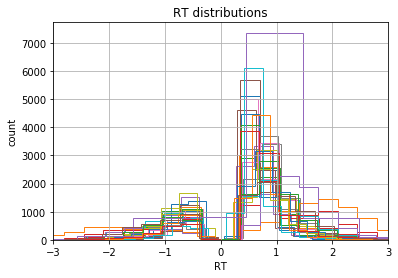

In [17]:
ddm_data_flipped = hddm.utils.flip_errors(ddm_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in ddm_data_flipped.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3, 3)

plt.show()
# plt.savefig('hddm_demo_fig_00.pdf')

In [18]:
m = hddm.HDDM(ddm_data)
m.find_starting_values()
m.sample(2000, burn=20)

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


 [-----------------100%-----------------] 2001 of 2000 complete in 1827.6 sec

In [19]:
m.print_stats()

                  mean          std       2.5q        25q        50q        75q      97.5q       mc err
a              1.68795    0.0651262    1.56373    1.64512    1.68623     1.7302     1.8246   0.00148798
a_std         0.322144    0.0502754    0.23974   0.287418   0.315902   0.351296   0.433896   0.00141289
a_subj.AK1     1.42434   0.00794944    1.40898    1.41906     1.4238    1.42951    1.44053  0.000294253
a_subj.AK10    1.55197   0.00734359    1.53766    1.54717    1.55187    1.55672    1.56662  0.000238914
a_subj.AK11    1.64093   0.00768769    1.62547    1.63593    1.64118    1.64595    1.65657  0.000252167
a_subj.AK12    1.89435   0.00978126    1.87548    1.88761    1.89441     1.9011    1.91406  0.000309293
a_subj.AK2     1.38668   0.00665585    1.37367    1.38221    1.38654    1.39101     1.4004  0.000202451
a_subj.AK3     1.31839   0.00682291    1.30518    1.31392    1.31822    1.32255    1.33246  0.000201851
a_subj.AK4      1.3268    0.0066626    1.31379    1.32247    1.3

Plotting v


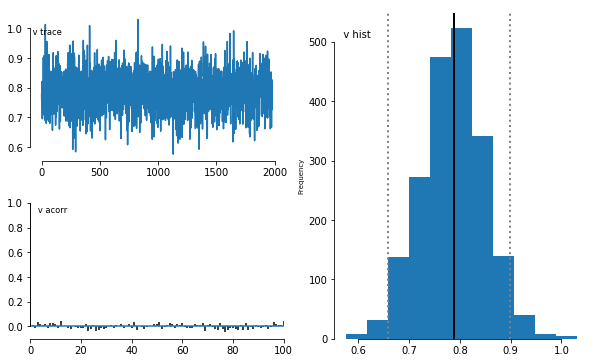

In [112]:
m.plot_posteriors(['v'])
sns.despine(trim = True)
plt.savefig('./_graphs_hddm/hddm_ak_al_last10000trials_params_driftrate.pdf')

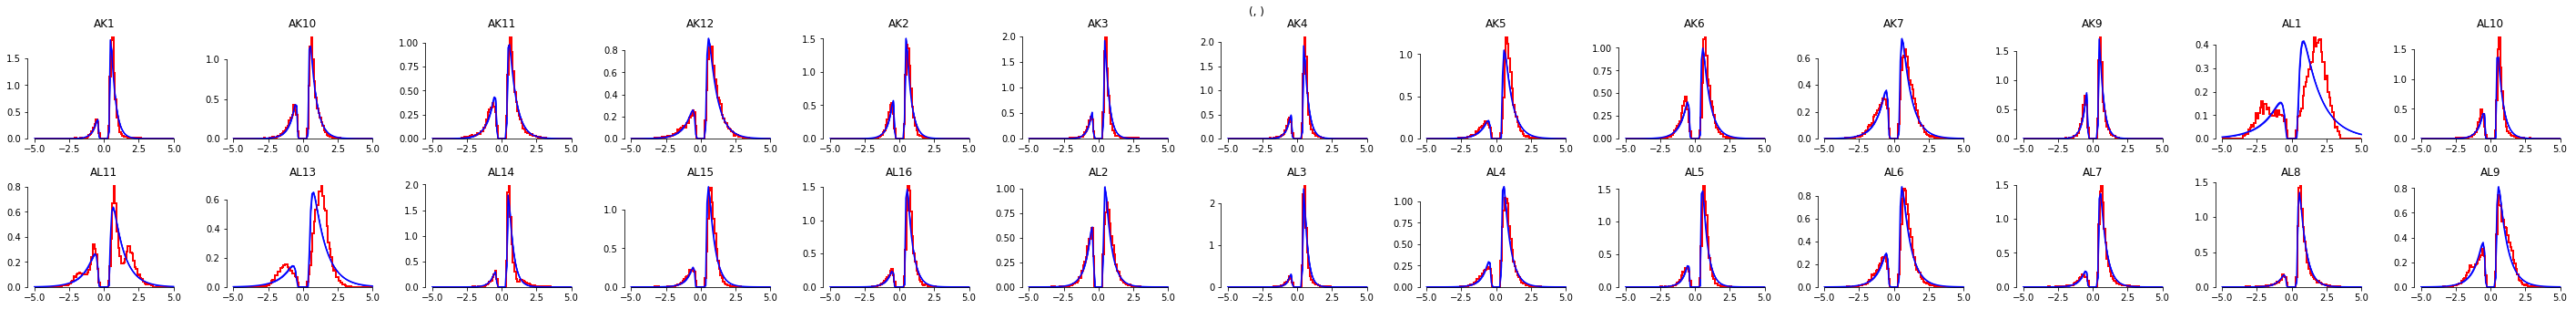

In [107]:
m.plot_posterior_predictive(figsize = (50, 5), columns = 13)
sns.despine(trim=True)
plt.savefig('hddm_test.pdf')

### Last 5000 trials

In [124]:
with open('results_AK_AL_last5000trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 5000
    
    for animal in results_AK_AL.keys():
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [125]:
ddm_data_last5000trials = hddm.load_csv('./results_AK_AL_last5000trials.csv')

In [126]:
ddm_data_last5000trials.head(10)

subj_idx  response        rt
0      AL8         1  1.043999
1      AL8         0  2.646056
2      AL8         1  2.958259
3      AL8         1  1.234196
4      AL8         1  1.930582
5      AL8         1  0.894511
6      AL8         1  0.763830
7      AL8         1  1.429805
8      AL8         1  1.964233
9      AL8         1  0.711370

In [134]:
m_last5000trials = hddm.HDDM(ddm_data_last5000trials)
m_last5000trials.find_starting_values()
m_last5000trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 992.0 sec

In [135]:
m_last5000trials.print_stats()

                  mean         std       2.5q        25q        50q       75q      97.5q       mc err
a               1.6833   0.0611335    1.56362    1.64414    1.68059   1.72335    1.81169   0.00160023
a_std          0.30938   0.0455229   0.236498    0.27724   0.304553  0.335822   0.410946   0.00130873
a_subj.AK1     1.39053   0.0104618    1.37003    1.38336    1.39054   1.39742    1.41098  0.000337673
a_subj.AK10    1.54212   0.0108856    1.52065    1.53523    1.54191   1.54983    1.56394  0.000306571
a_subj.AK11     1.6169   0.0110332    1.59462    1.60958    1.61693   1.62442    1.63826  0.000383276
a_subj.AK12    1.83343   0.0137661    1.80811    1.82372    1.83304   1.84267    1.86155  0.000516727
a_subj.AK2     1.47776   0.0100909    1.45825    1.47079    1.47783   1.48454    1.49758  0.000291216
a_subj.AK3     1.34504  0.00963012     1.3272    1.33856    1.34488   1.35129    1.36427  0.000331339
a_subj.AK4     1.40085   0.0101256    1.38141    1.39401    1.40065   1.40734    1

### First 2000 trials

In [136]:
with open('results_AK_AL_first2000trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 2000
    
    for animal in results_AK_AL.keys():
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[:trials_to_include]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [8]:
ddm_data_first2000trials = hddm.load_csv('./results_AK_AL_first2000trials.csv')

In [9]:
ddm_data_first2000trials.head(10)

subj_idx  response        rt
0      AL8         0  0.442797
1      AL8         0  0.464876
2      AL8         1  0.641508
3      AL8         1  0.996218
4      AL8         1  1.205310
5      AL8         0  0.680278
6      AL8         0  1.424878
7      AL8         0  1.125392
8      AL8         0  1.331711
9      AL8         0  1.009939

In [140]:
m_first2000trials = hddm.HDDM(ddm_data_first2000trials)
m_first2000trials.find_starting_values()
m_first2000trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 386.7 sec

In [141]:
m_first2000trials.print_stats()

                   mean         std        2.5q         25q         50q         75q       97.5q       mc err
a               1.85372   0.0453967     1.76371     1.82368     1.85332     1.88306      1.9424   0.00107006
a_std          0.230048       0.037    0.171272    0.204508    0.224349    0.250758    0.317922   0.00118492
a_subj.AK1      2.02076   0.0213342     1.98134     2.00622     2.02019     2.03445     2.06395  0.000677686
a_subj.AK10       1.583   0.0172566      1.5492     1.57156     1.58289     1.59479     1.61834  0.000607045
a_subj.AK11     1.72918   0.0183616     1.69417     1.71626     1.72909     1.74195     1.76487  0.000540732
a_subj.AK12     2.02989   0.0211467     1.98978     2.01535     2.02939     2.04415     2.07061  0.000664287
a_subj.AK2       1.7511   0.0185589      1.7162     1.73857     1.75086      1.7638     1.78869  0.000587311
a_subj.AK3      1.57516   0.0161807     1.54407     1.56469     1.57502     1.58594     1.60752  0.000530518
a_subj.AK4      1.9

### No Minimum Reaction Time

In [127]:
with open('results_AK_nominrt.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    for animal in results_AK_nominrt.keys():
        for trial in range(len(results_AK_nominrt[animal]['rt_by_trial'])):
            
            if results_AK_nominrt[animal]['rt_by_trial'][trial]*0.001 < 0.05:
                pass
            else:
                # reaction time, convert to seconds
                rt = results_AK_nominrt[animal]['rt_by_trial'][trial]*0.001
                # outcome as binary 1 or 0
                if results_AK_nominrt[animal]['outcome_by_trial'][trial] == 'success':
                    response = 1
                elif results_AK_nominrt[animal]['outcome_by_trial'][trial] == 'failure':
                    response = 0
                writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [128]:
ddm_data_nominrt = hddm.load_csv('./results_AK_nominrt.csv')

In [129]:
ddm_data_nominrt.head(10)

subj_idx  response        rt
0      AK3         1  1.344479
1      AK3         1  0.463800
2      AK3         1  1.241905
3      AK3         0  0.656455
4      AK3         1  0.590245
5      AK3         1  0.884967
6      AK3         1  0.657328
7      AK3         0  0.400138
8      AK3         1  0.186542
9      AK3         0  0.499906

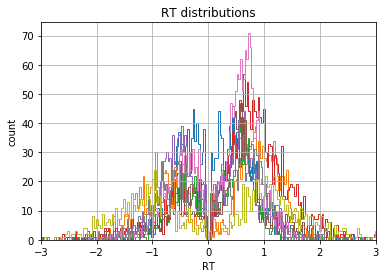

In [130]:
ddm_data_nominrt_flipped = hddm.utils.flip_errors(ddm_data_nominrt)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in ddm_data_nominrt_flipped.groupby('subj_idx'):
    subj_data.rt.hist(bins=200, histtype='step', ax=ax)

plt.xlim(-3, 3)

plt.show()
# plt.savefig('hddm_demo_fig_00.pdf')

In [131]:
m_nominrt = hddm.HDDM(ddm_data_nominrt)
m_nominrt.find_starting_values()
m_nominrt.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 174.8 sec

In [132]:
m_nominrt.print_stats()

                    mean          std         2.5q          25q          50q          75q        97.5q       mc err
a                 1.7871     0.100711       1.5964      1.72488      1.78038      1.84031      2.00835    0.0028608
a_std            0.28839    0.0912835     0.170227     0.224842     0.269013     0.328421     0.520544   0.00337938
a_subj.AK1       1.50145    0.0135528      1.47596      1.49153      1.50146      1.51142      1.52756  0.000283438
a_subj.AK10      2.04966    0.0221873      2.00705      2.03436      2.04951      2.06444      2.09558  0.000511041
a_subj.AK11      1.54888    0.0180206      1.51334      1.53661      1.54855        1.561       1.5854  0.000449296
a_subj.AK12      1.99157    0.0185606      1.95478      1.97929      1.99167      2.00385      2.02768  0.000435918
a_subj.AK2       1.61358    0.0152291      1.58341      1.60334       1.6134       1.6237      1.64271   0.00036194
a_subj.AK3       1.73512    0.0197269      1.69677       1.7225      1.7

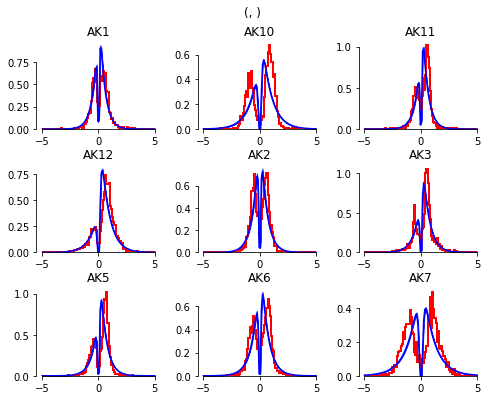

In [133]:
m_nominrt.plot_posterior_predictive(columns = 3)
sns.despine(trim=True)
plt.savefig('hddm_test_nominrt.pdf')

Plotting v


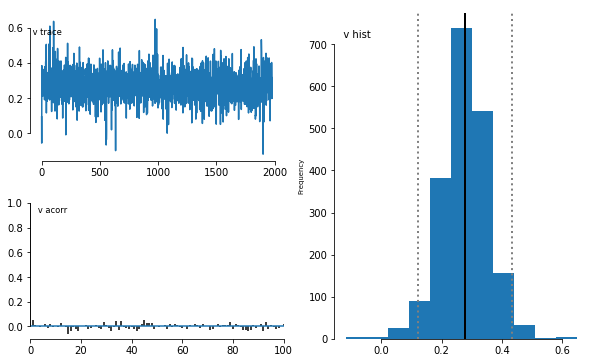

In [115]:
m_nominrt.plot_posteriors(['v'])
sns.despine(trim = True)
plt.savefig('./_graphs_hddm/hddm_ak_al_nominrt_params_driftrate.pdf')

### No Informative Priors

In [142]:
m_last5000trials_noinformativeprior = hddm.HDDM(ddm_data_last5000trials, informative = False)
m_last5000trials_noinformativeprior.find_starting_values()
m_last5000trials_noinformativeprior.sample(2000, burn=20)

 [-----------------100%-----------------] 2001 of 2000 complete in 1347.7 sec

In [143]:
m_last5000trials_noinformativeprior.print_stats()

                  mean         std       2.5q        25q        50q        75q     97.5q       mc err
a              1.68263   0.0632891    1.56081    1.64046    1.68125     1.7269   1.80328   0.00152189
a_std         0.325254   0.0473363   0.248233   0.291271   0.320927   0.355161   0.42763   0.00111638
a_subj.AK1     1.39051   0.0107395    1.36914    1.38354    1.39066    1.39803   1.41106  0.000336601
a_subj.AK10     1.5429   0.0110054    1.52139    1.53538    1.54276    1.55004   1.56471  0.000369718
a_subj.AK11    1.61784   0.0111582    1.59493    1.61042    1.61844    1.62556   1.63799  0.000393072
a_subj.AK12    1.83324   0.0133786    1.80689    1.82434    1.83386    1.84241   1.85905  0.000463886
a_subj.AK2     1.47759   0.0103716    1.45842    1.47063    1.47737    1.48457   1.49907  0.000344053
a_subj.AK3     1.34503   0.0097709    1.32576    1.33861    1.34533    1.35188    1.3638  0.000330229
a_subj.AK4     1.40011   0.0103125    1.38047    1.39304    1.39994     1.4074   1

### Regular Stim 

#### first 1000 trials (reg stim)

In [208]:
with open('results_AK_AL_first1000trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 1000
    
    for animal in results_AK_AL.keys():
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[:trials_to_include]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [209]:
ddm_data_reg_first1000trials = hddm.load_csv('./results_AK_AL_first1000trials.csv')
m_reg_first1000trials = hddm.HDDM(ddm_data_reg_first1000trials)
m_reg_first1000trials.find_starting_values()
m_reg_first1000trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 215.5 sec

#### last 1000 trials (reg stim)

In [210]:
with open('results_AK_AL_last1000trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 1000
    
    for animal in results_AK_AL.keys():
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [211]:
ddm_data_reg_last1000trials = hddm.load_csv('./results_AK_AL_last1000trials.csv')
m_reg_last1000trials = hddm.HDDM(ddm_data_reg_last1000trials)
m_reg_last1000trials.find_starting_values()
m_reg_last1000trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 211.5 sec

#### generate statistics

In [230]:
stats_m_reg_first1000trials = m_reg_first1000trials.gen_stats()
stats_m_reg_last1000trials = m_reg_last1000trials.gen_stats()

#### plotting threshold and drift rate

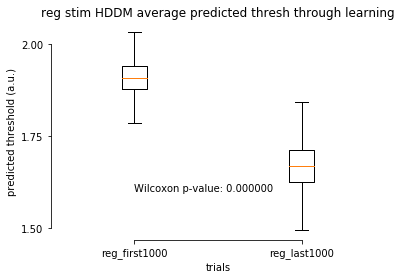

In [225]:
group1 = m_reg_first1000trials.get_group_traces()['a']
group2 = m_reg_last1000trials.get_group_traces()['a']

plt.boxplot([group1, group2], showfliers = False)
sns.despine(trim=True)
plt.xlabel('trials')
plt.ylabel('predicted threshold (a.u.)')
plt.xticks([1,2], ['reg_first1000', 'reg_last1000'])
plt.yticks([1.5, 1.75, 2.0])
s = 'Wilcoxon p-value: %f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(1, 1.6, s)
plt.title('reg stim HDDM average predicted thresh through learning')
plt.savefig('_graphs_hddm/regstim_average_predicted_threshold_first1000_v_last1000_trials.pdf')

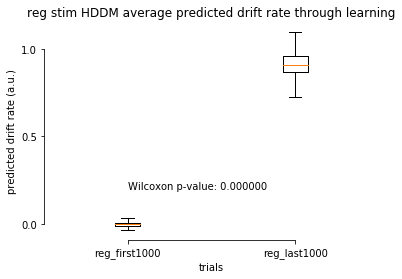

In [229]:
group1 = m_reg_first1000trials.get_group_traces()['v']
group2 = m_reg_last1000trials.get_group_traces()['v']

plt.boxplot([group1, group2], showfliers = False)
sns.despine(trim=True)
plt.xlabel('trials')
plt.ylabel('predicted drift rate (a.u.)')
plt.xticks([1,2], ['reg_first1000', 'reg_last1000'])
plt.yticks([0, 0.5, 1.0])
s = 'Wilcoxon p-value: %f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(1, 0.2, s)
plt.title('reg stim HDDM average predicted drift rate through learning')
plt.savefig('_graphs_hddm/regstim_average_predicted_driftrate_first1000_v_last1000_trials.pdf')

[2.0658175382835138 1.660624438725586 1.7959320487119834 1.988454147173076
 1.8856141231601105 1.5515612349970904 2.2119772365664025
 1.9237243093422287 2.3051528226248608 1.9645201998868749
 1.5568869506204914 2.0515962694661876 1.6952798486013392
 2.0063787513491476 1.9311059458919426 1.9289483049599505
 1.8604760912240892 1.7046673252070341 1.9810295713275827
 1.5916484262845103 2.000715169034077 2.1967963767034613 2.391579169437394
 1.5931202245086633 1.878653205135439 1.862488226703468]


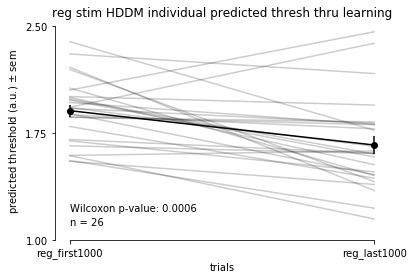

In [258]:
group1_stats = stats_m_reg_first1000trials
group2_stats = stats_m_reg_last1000trials
stat = 'a_subj'

idx = [x for x,subj in enumerate(group1_stats.index) if stat in subj] 
group1 = np.array(group1_stats['mean'].iloc[idx])

print group1

idx = [x for x,subj in enumerate(group2_stats.index) if stat in subj] 
group2 = np.array(group2_stats['mean'].iloc[idx])

xidx = [0,1]
x = np.array([np.repeat(xidx[0], len(idx)), np.repeat(xidx[1], len(idx))])
y = np.array([group1, group2])

ymean = [np.mean(group1), np.mean(group2)]
ysem = [np.std(group1)/math.sqrt(len(idx)), np.std(group2)/math.sqrt(len(idx))]


plt.plot(x,y,color = 'black', alpha = 0.2)
plt.errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')

plt.xticks(xidx, ['reg_first1000', 'reg_last1000'])
plt.xlabel('trials')
plt.yticks([1, 1.75, 2.5])
plt.ylabel('predicted threshold (a.u.) $\pm$ sem')
sns.despine(trim = True)
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(0, 1.2, s)
s = 'n = %d' %len(idx)
plt.text(0,1.1, s)
plt.title('reg stim HDDM individual predicted thresh thru learning')
plt.savefig('_graphs_hddm/regstim_individual_predicted_threshold_first1000_v_last1000_trials.pdf')

[0.013220704114417768 0.0053016336305974415 -0.01877993600179906
 0.035408848208890856 0.042712891983667185 -0.1189240899449388
 -0.05821913808058767 0.042613054256670176 -0.05691597667653583
 -0.10050320643176379 -0.02012237649687336 0.04004063990559201
 -0.005818016091172947 0.059327960257407344 0.01309056606615716
 0.028493430495001297 0.03584099549095487 0.005655782118785298
 0.012263600075372267 0.006513604239454299 0.01304321729120119
 2.941266011053656e-05 -0.01789705709767066 0.04026483891656104
 -0.016409664997643205 -0.014445031264337778]


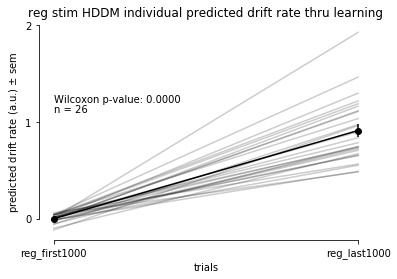

In [260]:
group1_stats = stats_m_reg_first1000trials
group2_stats = stats_m_reg_last1000trials
stat = 'v_subj'

idx = [x for x,subj in enumerate(group1_stats.index) if stat in subj] 
group1 = np.array(group1_stats['mean'].iloc[idx])

print group1

idx = [x for x,subj in enumerate(group2_stats.index) if stat in subj] 
group2 = np.array(group2_stats['mean'].iloc[idx])

xidx = [0,1]
x = np.array([np.repeat(xidx[0], len(idx)), np.repeat(xidx[1], len(idx))])
y = np.array([group1, group2])

ymean = [np.mean(group1), np.mean(group2)]
ysem = [np.std(group1)/math.sqrt(len(idx)), np.std(group2)/math.sqrt(len(idx))]


plt.plot(x,y,color = 'black', alpha = 0.2)
plt.errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')

plt.xticks(xidx, ['reg_first1000', 'reg_last1000'])
plt.xlabel('trials')
plt.yticks([0, 1, 2])
plt.ylabel('predicted drift rate (a.u.) $\pm$ sem')
sns.despine(trim = True)
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(0, 1.2, s)
s = 'n = %d' %len(idx)
plt.text(0,1.1, s)
plt.title('reg stim HDDM individual predicted drift rate thru learning')
plt.savefig('_graphs_hddm/regstim_individual_predicted_driftrate_first1000_v_last1000_trials.pdf')

### Stimulus Pair 2 (StimB)

In [262]:
# ~~~~~~~~~  results_stimB_base  ~~~~~~~~~

# all sessions
data_dict = results_stimB_base
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_base_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_succ = get_relevant_data(data_dict, 'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_base_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_base_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_base_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [11]:
# ~~~~~~~~~  results_stimB  ~~~~~~~~~

# all sessions
data_dict = results_stimB
all_sesh = True
sesh_to_count = 99
sesh_from_start = False

stimB_perf = get_relevant_data(data_dict, 'pct_correct_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_perf_err = get_relevant_data(data_dict, 'pct_correct_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_pct_ignore = get_relevant_data(data_dict, 'pct_ignore_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_pct_ignore_err = get_relevant_data(data_dict, 'pct_ignore_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_rt_succ = get_relevant_data(data_dict,'avg_rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_succ_err = get_relevant_data(data_dict, 'rt_success_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_fail = get_relevant_data(data_dict, 'avg_rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_fail_err = get_relevant_data(data_dict, 'rt_failure_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_all = get_relevant_data(data_dict, 'avg_rt_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_rt_all_err = get_relevant_data(data_dict, 'rt_bootstrap_error_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_succ_rts = get_relevant_data(data_dict, 'rt_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_fail_rts = get_relevant_data(data_dict, 'rt_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_all_rts = get_relevant_data(data_dict, 'rt_by_session', all_sesh, sesh_to_count, sesh_from_start)

stimB_iti_succ = get_relevant_data(data_dict, 'iti_success_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_iti_fail = get_relevant_data(data_dict, 'iti_failure_by_session', all_sesh, sesh_to_count, sesh_from_start)
stimB_iti_all = get_relevant_data(data_dict, 'iti_by_session', all_sesh, sesh_to_count, sesh_from_start)

In [ ]:
ddm_data_stimB_base_last500trials = hddm.load_csv('./results_stimB_base_last500trials.csv')
m_stimB_base_last500trials = hddm.HDDM(ddm_data_stimB_base_last500trials)
m_stimB_base_last500trials.find_starting_values()
m_stimB_base_last500trials.sample(2000, burn=20)

ddm_data_stimB_first500trials = hddm.load_csv('./results_stimB_first500trials.csv')
m_stimB_first500trials = hddm.HDDM(ddm_data_stimB_first500trials)
m_stimB_first500trials.find_starting_values()
m_stimB_first500trials.sample(2000, burn=20)

ddm_data_stimB_last500trials = hddm.load_csv('./results_stimB_last500trials.csv')
m_stimB_last500trials = hddm.HDDM(ddm_data_stimB_last500trials)
m_stimB_last500trials.find_starting_values()
m_stimB_last500trials.sample(2000, burn=20)

#### last 500 trials (stimB base)

In [263]:
with open('results_stimB_base_last500trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 500
    
    for animal in results_stimB_base.keys():
        for trial in range(len(results_stimB_base[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_stimB_base[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_stimB_base[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_stimB_base[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [264]:
ddm_data_stimB_base_last500trials = hddm.load_csv('./results_stimB_base_last500trials.csv')
m_stimB_base_last500trials = hddm.HDDM(ddm_data_stimB_base_last500trials)
m_stimB_base_last500trials.find_starting_values()
m_stimB_base_last500trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 79.8 sec

#### first 500 trials (stimB)

In [12]:
with open('results_stimB_first500trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 500
    
    for animal in results_stimB.keys():
        for trial in range(len(results_stimB[animal]['rt_by_trial']))[:trials_to_include]:
            # reaction time, convert to seconds
            rt = results_stimB[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_stimB[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_stimB[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [265]:
ddm_data_stimB_first500trials = hddm.load_csv('./results_stimB_first500trials.csv')
m_stimB_first500trials = hddm.HDDM(ddm_data_stimB_first500trials)
m_stimB_first500trials.find_starting_values()
m_stimB_first500trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 80.8 sec

#### last 500 trials (stimB)

In [20]:
with open('results_stimB_last500trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 500
    
    for animal in results_stimB.keys():
        for trial in range(len(results_stimB[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_stimB[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_stimB[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_stimB[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt}) # write the row

In [266]:
ddm_data_stimB_last500trials = hddm.load_csv('./results_stimB_last500trials.csv')
m_stimB_last500trials = hddm.HDDM(ddm_data_stimB_last500trials)
m_stimB_last500trials.find_starting_values()
m_stimB_last500trials.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 74.3 sec

#### generate statistics

In [267]:
stats_m_stimB_base_last500trials = m_stimB_base_last500trials.gen_stats()
stats_m_stimB_first500trials = m_stimB_first500trials.gen_stats()
stats_m_stimB_last500trials = m_stimB_last500trials.gen_stats()

#### plotting threshold and drift rate

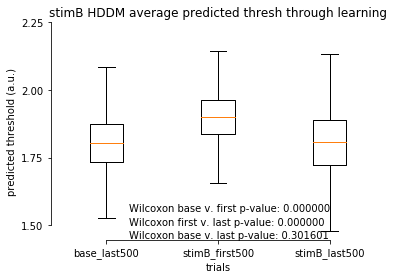

In [300]:
stat = 'a'
group0 = m_stimB_base_last500trials.get_group_traces()[stat]
group1 = m_stimB_first500trials.get_group_traces()[stat]
group2 = m_stimB_last500trials.get_group_traces()[stat]

plt.boxplot([group0, group1, group2], showfliers = False)

plt.xlabel('trials')
plt.ylabel('predicted threshold (a.u.)')
plt.xticks([1,2,3], ['base_last500','stimB_first500', 'stimB_last500'])
plt.yticks([1.5, 1.75, 2.0, 2.25])
sns.despine(trim=True)
s = 'Wilcoxon base v. first p-value: %f' %scipy.stats.wilcoxon(group0, group1)[1]
plt.text(1.2, 1.55, s)
s = 'Wilcoxon first v. last p-value: %f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(1.2, 1.5, s)
s = 'Wilcoxon base v. last p-value: %f' %scipy.stats.wilcoxon(group0, group2)[1]
plt.text(1.2, 1.45, s)
plt.title('stimB HDDM average predicted thresh through learning')
plt.savefig('_graphs_hddm/stimB_average_predicted_threshold_base_v_first500_v_last500_trials.pdf')

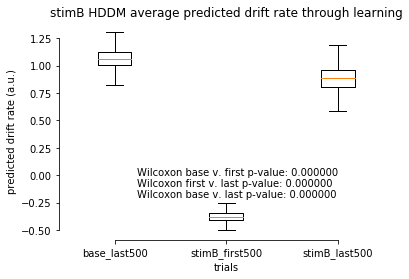

In [301]:
stat = 'v'
group0 = m_stimB_base_last500trials.get_group_traces()[stat]
group1 = m_stimB_first500trials.get_group_traces()[stat]
group2 = m_stimB_last500trials.get_group_traces()[stat]

plt.boxplot([group0, group1, group2], showfliers = False)

plt.xlabel('trials')
plt.ylabel('predicted drift rate (a.u.)')
plt.xticks([1,2,3], ['base_last500','stimB_first500', 'stimB_last500'])
# plt.yticks([1.5, 1.75, 2.0, 2.25])
sns.despine(trim=True)
s = 'Wilcoxon base v. first p-value: %f' %scipy.stats.wilcoxon(group0, group1)[1]
plt.text(1.2, 0, s)
s = 'Wilcoxon first v. last p-value: %f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(1.2, -0.1, s)
s = 'Wilcoxon base v. last p-value: %f' %scipy.stats.wilcoxon(group0, group2)[1]
plt.text(1.2, -0.2, s)
plt.title('stimB HDDM average predicted drift rate through learning')
plt.savefig('_graphs_hddm/stimB_average_predicted_driftrate_base_v_first500_v_last500_trials.pdf')

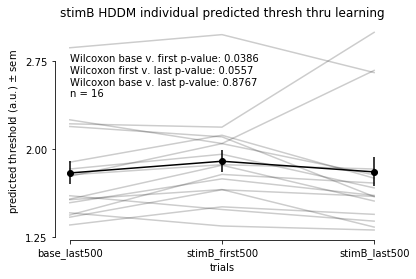

In [292]:
group0_stats = stats_m_stimB_base_last500trials
group1_stats = stats_m_stimB_first500trials
group2_stats = stats_m_stimB_last500trials
stat = 'a_subj'

idx = [x for x,subj in enumerate(group0_stats.index) if stat in subj] 
group0 = np.array(group0_stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(group1_stats.index) if stat in subj] 
group1 = np.array(group1_stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(group2_stats.index) if stat in subj] 
group2 = np.array(group2_stats['mean'].iloc[idx])

xidx = [0,1, 2]
x = np.array([np.repeat(xidx[0], len(idx)), np.repeat(xidx[1], len(idx)), np.repeat(xidx[2], len(idx))])
y = np.array([group0, group1, group2])

ymean = [np.mean(group0), np.mean(group1), np.mean(group2)]
ysem = [np.std(group0)/math.sqrt(len(idx)), np.std(group1)/math.sqrt(len(idx)), np.std(group2)/math.sqrt(len(idx))]


plt.plot(x,y,color = 'black', alpha = 0.2)
plt.errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')

plt.xticks(xidx, ['base_last500', 'stimB_first500', 'stimB_last500'])
plt.xlabel('trials')
plt.yticks([1.25, 2, 2.75])
plt.ylabel('predicted threshold (a.u.) $\pm$ sem')
sns.despine(trim = True)
s = 'Wilcoxon base v. first p-value: %.4f' %scipy.stats.wilcoxon(group0, group1)[1]
plt.text(0, 2.75, s)
s = 'Wilcoxon first v. last p-value: %.4f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(0, 2.65, s)
s = 'Wilcoxon base v. last p-value: %.4f' %scipy.stats.wilcoxon(group0, group2)[1]
plt.text(0, 2.55, s)
s = 'n = %d' %len(idx)
plt.text(0, 2.45, s)
plt.title('stimB HDDM individual predicted thresh thru learning')
plt.savefig('_graphs_hddm/stimB_individual_predicted_threshold_base_v_first500_v_last500_trials.pdf')

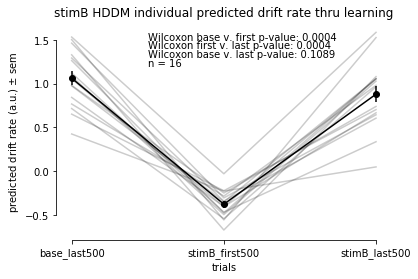

In [297]:
group0_stats = stats_m_stimB_base_last500trials
group1_stats = stats_m_stimB_first500trials
group2_stats = stats_m_stimB_last500trials
stat = 'v_subj'

idx = [x for x,subj in enumerate(group0_stats.index) if stat in subj] 
group0 = np.array(group0_stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(group1_stats.index) if stat in subj] 
group1 = np.array(group1_stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(group2_stats.index) if stat in subj] 
group2 = np.array(group2_stats['mean'].iloc[idx])

xidx = [0,1, 2]
x = np.array([np.repeat(xidx[0], len(idx)), np.repeat(xidx[1], len(idx)), np.repeat(xidx[2], len(idx))])
y = np.array([group0, group1, group2])

ymean = [np.mean(group0), np.mean(group1), np.mean(group2)]
ysem = [np.std(group0)/math.sqrt(len(idx)), np.std(group1)/math.sqrt(len(idx)), np.std(group2)/math.sqrt(len(idx))]


plt.plot(x,y,color = 'black', alpha = 0.2)
plt.errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')

plt.xticks(xidx, ['base_last500', 'stimB_first500', 'stimB_last500'])
plt.xlabel('trials')
plt.yticks([-0.5, 0, 0.5, 1, 1.5])
plt.ylabel('predicted drift rate (a.u.) $\pm$ sem')
sns.despine(trim = True)
s = 'Wilcoxon base v. first p-value: %.4f' %scipy.stats.wilcoxon(group0, group1)[1]
plt.text(0.5, 1.5, s)
s = 'Wilcoxon first v. last p-value: %.4f' %scipy.stats.wilcoxon(group1, group2)[1]
plt.text(0.5, 1.4, s)
s = 'Wilcoxon base v. last p-value: %.4f' %scipy.stats.wilcoxon(group0, group2)[1]
plt.text(0.5, 1.3, s)
s = 'n = %d' %len(idx)
plt.text(0.5, 1.2, s)
plt.title('stimB HDDM individual predicted drift rate thru learning')
plt.savefig('_graphs_hddm/stimB_individual_predicted_driftrate_base_v_first500_v_last500_trials.pdf')

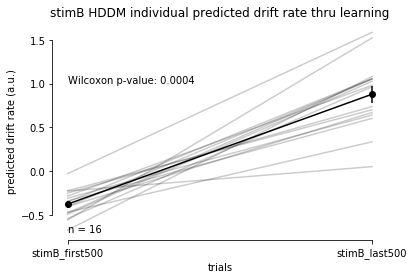

In [199]:
idx = [x for x,subj in enumerate(stats_m_stimB_first500trials.index) if 'v_subj' in subj] 
v_means_first500 = np.array(stats_m_stimB_first500trials['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats_m_stimB_last500trials.index) if 'v_subj' in subj] 
v_means_last500 = np.array(stats_m_stimB_last500trials['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([v_means_first500, v_means_last500])

ymean = [np.mean(v_means_first500), np.mean(v_means_last500)]
ysem = [np.std(v_means_first500)/math.sqrt(len(idx)), np.std(v_means_last500)/math.sqrt(len(idx))]
xidx = [0,1]

plt.plot(x,y, color = 'black', alpha = 0.2)
plt.errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')

plt.xticks([0,1], ['stimB_first500', 'stimB_last500'])
plt.xlabel('trials')
# plt.yticks([1, 2, 3])
plt.ylabel('predicted drift rate (a.u.)')
sns.despine(trim = True)
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(v_means_first500, v_means_last500)[1]
plt.text(0, 1, s)
s = 'n = %d' %len(idx)
plt.text(0,-0.7, s)
plt.title('stimB HDDM individual predicted drift rate thru learning')
plt.savefig('_graphs_hddm/stimB_individual_predicted_driftrate_first500_v_last500_trials.pdf')

In [50]:
scipy.stats.ttest_rel(m_stimB_first500trials.get_group_traces()['a'], m_stimB_last500trials.get_group_traces()['a'])

Ttest_relResult(statistic=22.826801544417165, pvalue=1.4257132723048789e-102)

In [ ]:
# full stats

# m_stimB_last500trials.print_stats()

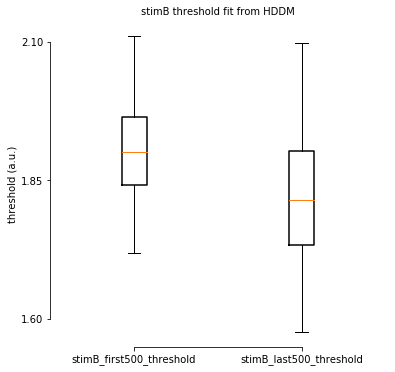

In [41]:
stats = [{
    "label": 'stimB_first500_threshold',  # not required
    "mean":  1.90405,  # not required
    "med": 1.90074,
    "q1": 1.84085,
    "q3": 1.96469,
    # "cilo": 5.3, # not required
    # "cihi": 5.7, # not required
    "whislo": 1.71923,  # required
    "whishi": 2.11161,  # required
    "fliers": []  # required if showfliers=True
    }, 
    {
    "label": 'stimB_last500_threshold',  # not required
    "mean":  1.82078 ,  # not required
    "med": 1.81504,
    "q1": 1.73319,
    "q3": 1.90359,
    # "cilo": 5.3, # not required
    # "cihi": 5.7, # not required
    "whislo": 1.57547,  # required
    "whishi": 2.09827,  # required
    "fliers": []  # required if showfliers=True
    }]

fs = 10  # fontsize

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
axes.bxp(stats)
axes.set_title('stimB threshold fit from HDDM', fontsize=fs)
axes.set_ylabel('threshold (a.u.)')
axes.set_yticks([1.6, 1.85, 2.1])
sns.despine(trim=True)
plt.show()

### Additional models for revisions

#### data

#### first & last 1000 trials (phase 0 and 1) (reg stim) in one csv file

In [16]:
with open('./_data/csv/results_AK_AL_first_and_last1000trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt', 'phase']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 1000
    
    for animal in results_AK_AL.keys():
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[:trials_to_include]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': 0}) # write the row
            
        for trial in range(len(results_AK_AL[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': 1}) # write the row

#### all trials (reg stim) binned into 10 bins (called 'phase') in one csv file

In [331]:
with open('./_data/csv/results_AK_AL_alltrials_10bins.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt', 'phase']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    
    
    for animal in results_AK_AL.keys():
        total_trials = len(results_AK_AL[animal]['rt_by_trial'])
        for trial in range(len(results_AK_AL[animal]['rt_by_trial'])):
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            # bin all trials into ten bins (0.1, 0.2, 0.3,...,1.0) and call "phase" to compare across animals with unequal total trials
            trial_bin = math.ceil(((trial+1)/total_trials)*10)/10
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': trial_bin}) # write the row

In [378]:
with open('./_data/csv/results_AK_AL_alltrials_5bins.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt', 'phase']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    
    
    for animal in results_AK_AL.keys():
        total_trials = len(results_AK_AL[animal]['rt_by_trial'])
        for trial in range(len(results_AK_AL[animal]['rt_by_trial'])):
            # reaction time, convert to seconds
            rt = results_AK_AL[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_AK_AL[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_AK_AL[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            # bin all trials into ten bins (0.1, 0.2, 0.3,...,1.0) and call "phase" to compare across animals with unequal total trials
            trial_bin = math.ceil(((trial+1)/total_trials)*10)/10
            # reduce from 10 bins to 5 bins, grouping "odds" (e.g. 0.1) with "evens" (e.g. 0.2)
            if trial_bin*10 % 2 != 0: 
                trial_bin = trial_bin + 0.1
            # write file
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': trial_bin}) # write the row

#### last 500 trials (stimB base), first 500 trials (stimB), last 500 trials (stimB)

In [461]:
with open('./_data/csv/results_stimB_baselast500_stimBfirst500_and_last500_trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt', 'phase']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 500
    
    for animal in results_stimB_base.keys():
        
        # last 500 trials of baseline sessions
        
        for trial in range(len(results_stimB_base[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_stimB_base[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_stimB_base[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_stimB_base[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': -1}) # write the row
        
        # first 500 trials of stimB sessions
        
        for trial in range(len(results_stimB[animal]['rt_by_trial']))[:trials_to_include]:
            # reaction time, convert to seconds
            rt = results_stimB[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_stimB[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_stimB[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': 0}) # write the row
        
        # last 500 trials of stimB sessions
        
        for trial in range(len(results_stimB[animal]['rt_by_trial']))[-trials_to_include:]:
            # reaction time, convert to seconds
            rt = results_stimB[animal]['rt_by_trial'][trial]*0.001
            # outcome as binary 1 or 0
            if results_stimB[animal]['outcome_by_trial'][trial] == 'success':
                response = 1
            elif results_stimB[animal]['outcome_by_trial'][trial] == 'failure':
                response = 0
            writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': 1}) # write the row           

In [568]:
results_transp.keys()[0].split('_')[0]

'AK7'

In [688]:
# make new dict results_transp_keys where animal names (keys) match results_transp_base
results_transp_keys = {}
for k,v in results_transp.iteritems():
    new_key = k.split('_')[0]
    results_transp_keys[new_key] = v

with open('./_data/csv/results_transp_baselast500_transpfirst500_and_last500_trials.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'rt', 'phase']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 500
    
    for animal in results_transp_base.keys():
        
        if animal in ['AK5', 'AK12']: # excluded subjects for above chance accuracy on near-transparent stimuli
            pass
        else:
            # last 500 trials of baseline sessions

            for trial in range(len(results_transp_base[animal]['rt_by_trial']))[-trials_to_include:]:
                # reaction time, convert to seconds
                rt = results_transp_base[animal]['rt_by_trial'][trial]*0.001
                # outcome as binary 1 or 0
                if results_transp_base[animal]['outcome_by_trial'][trial] == 'success':
                    response = 1
                elif results_transp_base[animal]['outcome_by_trial'][trial] == 'failure':
                    response = 0
                writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': -1}) # write the row

            # first 500 trials of stimB sessions
        
            
            for trial in range(len(results_transp_keys[animal]['rt_by_trial']))[:trials_to_include]:
                # reaction time, convert to seconds
                rt = results_transp_keys[animal]['rt_by_trial'][trial]*0.001
                # outcome as binary 1 or 0
                if results_transp_keys[animal]['outcome_by_trial'][trial] == 'success':
                    response = 1
                elif results_transp_keys[animal]['outcome_by_trial'][trial] == 'failure':
                    response = 0
                writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': 0}) # write the row

            # last 500 trials of stimB sessions

            for trial in range(len(results_transp_keys[animal]['rt_by_trial']))[-trials_to_include:]:
                # reaction time, convert to seconds
                rt = results_transp_keys[animal]['rt_by_trial'][trial]*0.001
                # outcome as binary 1 or 0
                if results_transp_keys[animal]['outcome_by_trial'][trial] == 'success':
                    response = 1
                elif results_transp_keys[animal]['outcome_by_trial'][trial] == 'failure':
                    response = 0
                writer.writerow({'subj_idx':animal,'response': response,'rt': rt, 'phase': 1}) # write the row    

In [ ]:
# load data

ddm_data_reg_first_and_last1000trials = hddm.load_csv('./_data/csv/results_AK_AL_first_and_last1000trials.csv')

In [18]:
# drift and thresh depend on phase

m_reg_by_phase_drift_thresh = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'a': ['phase']})
m_reg_by_phase_drift_thresh.find_starting_values()
m_reg_by_phase_drift_thresh.sample(10000, burn=5000)

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


 [-----------------100%-----------------] 10000 of 10000 complete in 2023.9 sec

In [666]:
# drift and thresh depend on phase (p_outlier = 0.05)

m_reg_by_phase_outliers_drift_thresh = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'a': ['phase']}, p_outlier = 0.05)
m_reg_by_phase_outliers_drift_thresh.find_starting_values()
m_reg_by_phase_outliers_drift_thresh.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2136.8 sec

In [668]:
# drift and thresh depend on phase (p_outlier = 0.05)

m_reg_by_phase_outliers_vaguepriors_drift_thresh = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'a': ['phase']}, p_outlier = 0.05, informative = False)
m_reg_by_phase_outliers_vaguepriors_drift_thresh.find_starting_values()
m_reg_by_phase_outliers_vaguepriors_drift_thresh.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 3089.8 sec

In [669]:
# adding outliers does not substantially improve/change the fit of the model, so going ahead without them

print m_reg_by_phase_outliers_vaguepriors_drift_thresh.dic
print m_reg_by_phase_outliers_drift_thresh.dic
print m_reg_by_phase_drift_thresh.dic

116867.3512846542
116867.65498095054
115146.01717299275


In [49]:
# thresh only depends on phase

m_reg_by_phase_thresh = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'a': ['phase']})
m_reg_by_phase_thresh.find_starting_values()
m_reg_by_phase_thresh.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1823.1 sec

In [50]:
# drift only depends on phase

m_reg_by_phase_drift = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase']})
m_reg_by_phase_drift.find_starting_values()
m_reg_by_phase_drift.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 1821.8 sec

In [207]:
# drift and thresh depend on phase, drift rate variability included

m_reg_by_phase_drift_thresh_driftvar = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'a': ['phase']}, include={'sv'})
m_reg_by_phase_drift_thresh_driftvar.find_starting_values()
m_reg_by_phase_drift_thresh_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 2936.9 sec

In [208]:
# thresh only depends on phase, drift rate variability included

m_reg_by_phase_thresh_driftvar = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'a': ['phase']}, include={'sv'})
m_reg_by_phase_thresh_driftvar.find_starting_values()
m_reg_by_phase_thresh_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 3266.3 sec

In [209]:
# drift only depends on phase, drift rate variability included

m_reg_by_phase_drift_driftvar = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase']}, include={'sv'})
m_reg_by_phase_drift_driftvar.find_starting_values()
m_reg_by_phase_drift_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2949.7 sec

In [243]:
# drift, thresh and drift variability depend on phase

m_reg_by_phase_drift_thresh_and_driftvar = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase']}, include={'sv'})
m_reg_by_phase_drift_thresh_and_driftvar.find_starting_values()
m_reg_by_phase_drift_thresh_and_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 3130.6 sec

In [244]:
# thresh and drift variability depend on phase

m_reg_by_phase_thresh_and_driftvar = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'a': ['phase'], 'sv': ['phase']}, include={'sv'})
m_reg_by_phase_thresh_and_driftvar.find_starting_values()
m_reg_by_phase_thresh_and_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 3219.9 sec

In [245]:
# drift and drift variability depend on phase

m_reg_by_phase_drift_and_driftvar = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'sv': ['phase']}, include={'sv'})
m_reg_by_phase_drift_and_driftvar.find_starting_values()
m_reg_by_phase_drift_and_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 3155.8 sec

In [448]:
# drift variability only depends on phase

m_reg_by_phase_driftvar_only = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'sv': ['phase']}, include={'sv'})
m_reg_by_phase_driftvar_only.find_starting_values()
m_reg_by_phase_driftvar_only.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 3377.2 sec

In [480]:
# # all depend on phase

# # model fit failed

# m_reg_by_phase_all_params = hddm.HDDM(ddm_data_reg_first_and_last1000trials, depends_on = {'v': ['phase'], 'a': ['phase'], 
#                                                                                     'sv': ['phase']}, include= 'all')
# m_reg_by_phase_all_params.find_starting_values()
# m_reg_by_phase_all_params.sample(10000, burn=5000)

In [396]:
# save models

# m_reg_by_phase_drift_thresh.save('./_data/hddmmodels/m_reg_by_phase_drift_thresh')
# m_reg_by_phase_thresh.save('./_data/hddmmodels/m_reg_by_phase_thresh')
# m_reg_by_phase_drift.save('./_data/hddmmodels/m_reg_by_phase_drift')
# m_reg_by_phase_drift_thresh_driftvar.save('./_data/hddmmodels/m_reg_by_phase_drift_thresh_driftvar')
# m_reg_by_phase_thresh_driftvar.save('./_data/hddmmodels/m_reg_by_phase_thresh_driftvar')
# m_reg_by_phase_drift_driftvar.save('./_data/hddmmodels/m_reg_by_phase_drift_driftvar')
# m_reg_by_phase_drift_thresh_and_driftvar.save('./_data/hddmmodels/m_reg_by_phase_drift_thresh_and_driftvar')
# m_reg_by_phase_thresh_and_driftvar.save('./_data/hddmmodels/m_reg_by_phase_thresh_and_driftvar')
# m_reg_by_phase_drift_and_driftvar.save('./_data/hddmmodels/m_reg_by_phase_drift_and_driftvar')

In [449]:
# get model info and name

drift_thresh = m_reg_by_phase_drift_thresh.get_group_traces()
thresh_only = m_reg_by_phase_thresh.get_group_traces()
drift_only = m_reg_by_phase_drift.get_group_traces()

drift_thresh_driftvar = m_reg_by_phase_drift_thresh_driftvar.get_group_traces()
thresh_only_driftvar = m_reg_by_phase_thresh_driftvar.get_group_traces()
drift_only_driftvar = m_reg_by_phase_drift_driftvar.get_group_traces()

drift_thresh_and_driftvar = m_reg_by_phase_drift_thresh_and_driftvar.get_group_traces()
thresh_and_driftvar = m_reg_by_phase_thresh_and_driftvar.get_group_traces()
drift_and_driftvar = m_reg_by_phase_drift_and_driftvar.get_group_traces()

driftvar_only = m_reg_by_phase_drift_and_driftvar.get_group_traces()

# all_params_reg = m_reg_by_phase_all_params.get_group_traces()

#stats

drift_thresh_stats = m_reg_by_phase_drift_thresh.gen_stats()
thresh_only_stats = m_reg_by_phase_thresh.gen_stats()
drift_only_stats = m_reg_by_phase_drift.gen_stats()

drift_thresh_driftvar_stats = m_reg_by_phase_drift_thresh_driftvar.gen_stats()
thresh_only_driftvar_stats = m_reg_by_phase_thresh_driftvar.gen_stats()
drift_only_driftvar_stats = m_reg_by_phase_drift_driftvar.gen_stats()

drift_thresh_and_driftvar_stats = m_reg_by_phase_drift_thresh_and_driftvar.gen_stats()
thresh_and_driftvar_stats = m_reg_by_phase_thresh_and_driftvar.gen_stats()
drift_and_driftvar_stats = m_reg_by_phase_drift_and_driftvar.gen_stats()

driftvar_only_stats = m_reg_by_phase_drift_and_driftvar.gen_stats()

# all_params_reg_stats = m_reg_by_phase_all_params.gen_stats()

In [450]:
# save model group traces & stats

drift_thresh.to_pickle('_data/hddmmodels/drift_thresh')
thresh_only.to_pickle('_data/hddmmodels/thresh_only')
drift_only.to_pickle('_data/hddmmodels/drift_only')

drift_thresh_driftvar.to_pickle('_data/hddmmodels/drift_thresh_driftvar')
thresh_only_driftvar.to_pickle('_data/hddmmodels/thresh_only_driftvar')
drift_only_driftvar.to_pickle('_data/hddmmodels/drift_only_driftvar')

drift_thresh_and_driftvar.to_pickle('_data/hddmmodels/drift_thresh_and_driftvar')
thresh_and_driftvar.to_pickle('_data/hddmmodels/thresh_and_driftvar')
drift_and_driftvar.to_pickle('_data/hddmmodels/drift_and_driftvar')

driftvar_only.to_pickle('_data/hddmmodels/driftvar_only')

all_params_reg.to_pickle('_data/hddmmodels/all_params_reg_stats')

#stats

drift_thresh_stats.to_pickle('_data/hddmmodels/drift_thresh_stats')
thresh_only_stats.to_pickle('_data/hddmmodels/thresh_only_stats')
drift_only_stats.to_pickle('_data/hddmmodels/drift_only_stats')

drift_thresh_driftvar_stats.to_pickle('_data/hddmmodels/drift_thresh_driftvar_stats')
thresh_only_driftvar_stats.to_pickle('_data/hddmmodels/thresh_only_driftvar_stats')
drift_only_driftvar_stats.to_pickle('_data/hddmmodels/drift_only_driftvar_stats')

drift_thresh_and_driftvar_stats.to_pickle('_data/hddmmodels/drift_thresh_and_driftvar_stats')
thresh_and_driftvar_stats.to_pickle('_data/hddmmodels/thresh_and_driftvar_stats')
drift_and_driftvar_stats.to_pickle('_data/hddmmodels/drift_and_driftvar_stats')

driftvar_only_stats.to_pickle('_data/hddmmodels/driftvar_only_stats')

# all_params_reg_stats.to_pickle('_data/hddmmodels/all_params_reg_stats')

#### stimB models

In [464]:
# load data

ddm_data_stimB_by_phase_500trials = hddm.load_csv('./_data/csv/results_stimB_baselast500_stimBfirst500_and_last500_trials.csv')

In [465]:
# drift and thresh depend on phase

m_stimB_by_phase_drift_thresh = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase']})
m_stimB_by_phase_drift_thresh.find_starting_values()
m_stimB_by_phase_drift_thresh.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_drift_thresh.save('m_stimB_by_phase_drift_thresh')

 [-----------------100%-----------------] 10000 of 10000 complete in 1065.2 sec

In [466]:
# thresh only depends on phase

m_stimB_by_phase_thresh = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'a': ['phase']})
m_stimB_by_phase_thresh.find_starting_values()
m_stimB_by_phase_thresh.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_thresh.save('m_stimB_by_phase_thresh')

 [-----------------99%----------------- ] 9999 of 10000 complete in 1040.4 sec[-----------------100%-----------------] 10000 of 10000 complete in 1040.6 sec

In [467]:
# drift only depends on phase

m_stimB_by_phase_drift = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'v': ['phase']})
m_stimB_by_phase_drift.find_starting_values()
m_stimB_by_phase_drift.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_drift.save('m_stimB_by_phase_drift')

 [-----------------100%-----------------] 10000 of 10000 complete in 1039.0 sec

In [468]:
# drift and thresh depend on phase, drift rate variability included

m_stimB_by_phase_drift_thresh_driftvar = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase']}, include={'sv'})
m_stimB_by_phase_drift_thresh_driftvar.find_starting_values()
m_stimB_by_phase_drift_thresh_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_drift_thresh_driftvar.save('m_stimB_by_phase_drift_thresh_driftvar')

 [-----------------100%-----------------] 10000 of 10000 complete in 1519.7 sec

In [671]:
# thresh only depends on phase, drift rate variability included ***(p_outlier = 0.05)***

m_stimB_by_phase_thresh_driftvar = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'a': ['phase']}, include={'sv'}, p_outlier = 0.05)
m_stimB_by_phase_thresh_driftvar.find_starting_values()
m_stimB_by_phase_thresh_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_thresh_driftvar.save('m_stimB_by_phase_thresh_driftvar')

 [-----------------100%-----------------] 10000 of 10000 complete in 1634.0 sec

In [470]:
# drift only depends on phase, drift rate variability included

m_stimB_by_phase_drift_driftvar = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'v': ['phase']}, include={'sv'})
m_stimB_by_phase_drift_driftvar.find_starting_values()
m_stimB_by_phase_drift_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_drift_driftvar.save('m_stimB_by_phase_drift_driftvar')

 [-----------------100%-----------------] 10000 of 10000 complete in 1506.1 sec

In [471]:
# drift, thresh and drift variability depend on phase

m_stimB_by_phase_drift_thresh_and_driftvar = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase']}, include={'sv'})
m_stimB_by_phase_drift_thresh_and_driftvar.find_starting_values()
m_stimB_by_phase_drift_thresh_and_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_drift_thresh_and_driftvar.save('m_stimB_by_phase_drift_thresh_and_driftvar')

 [-----------------100%-----------------] 10000 of 10000 complete in 1495.3 sec

In [472]:
# thresh and drift variability depend on phase

m_stimB_by_phase_thresh_and_driftvar = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'a': ['phase'], 'sv': ['phase']}, include={'sv'})
m_stimB_by_phase_thresh_and_driftvar.find_starting_values()
m_stimB_by_phase_thresh_and_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_thresh_and_driftvar.save('m_stimB_by_phase_thresh_and_driftvar')

 [-----------------100%-----------------] 10000 of 10000 complete in 1573.8 sec

In [473]:
# drift and drift variability depend on phase

m_stimB_by_phase_drift_and_driftvar = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'v': ['phase'], 'sv': ['phase']}, include={'sv'})
m_stimB_by_phase_drift_and_driftvar.find_starting_values()
m_stimB_by_phase_drift_and_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_drift_and_driftvar.save('m_stimB_by_phase_drift_and_driftvar')

 [-----------------100%-----------------] 10001 of 10000 complete in 1477.7 sec

In [474]:
# drift variability only depends on phase

m_stimB_by_phase_driftvar_only = hddm.HDDM(ddm_data_stimB_by_phase_500trials, depends_on = {'sv': ['phase']}, include={'sv'})
m_stimB_by_phase_driftvar_only.find_starting_values()
m_stimB_by_phase_driftvar_only.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_stimB_by_phase_driftvar_only.save('m_stimB_by_phase_driftvar_only')

 [-----------------100%-----------------] 10000 of 10000 complete in 1529.5 sec

In [672]:
# get model info and name

stimB_drift_thresh = m_stimB_by_phase_drift_thresh.get_group_traces()
stimB_thresh_only = m_stimB_by_phase_thresh.get_group_traces()
stimB_drift_only = m_stimB_by_phase_drift.get_group_traces()

stimB_drift_thresh_driftvar = m_stimB_by_phase_drift_thresh_driftvar.get_group_traces()
stimB_thresh_only_driftvar = m_stimB_by_phase_thresh_driftvar.get_group_traces()
stimB_drift_only_driftvar = m_stimB_by_phase_drift_driftvar.get_group_traces()

stimB_drift_thresh_and_driftvar = m_stimB_by_phase_drift_thresh_and_driftvar.get_group_traces()
stimB_thresh_and_driftvar = m_stimB_by_phase_thresh_and_driftvar.get_group_traces()
stimB_drift_and_driftvar = m_stimB_by_phase_drift_and_driftvar.get_group_traces()

stimB_driftvar_only = m_stimB_by_phase_drift_and_driftvar.get_group_traces()

#stats

stimB_drift_thresh_stats = m_stimB_by_phase_drift_thresh.gen_stats()
stimB_thresh_only_stats = m_stimB_by_phase_thresh.gen_stats()
stimB_drift_only_stats = m_stimB_by_phase_drift.gen_stats()

stimB_drift_thresh_driftvar_stats = m_stimB_by_phase_drift_thresh_driftvar.gen_stats()
stimB_thresh_only_driftvar_stats = m_stimB_by_phase_thresh_driftvar.gen_stats()
stimB_drift_only_driftvar_stats = m_stimB_by_phase_drift_driftvar.gen_stats()

stimB_drift_thresh_and_driftvar_stats = m_stimB_by_phase_drift_thresh_and_driftvar.gen_stats()
stimB_thresh_and_driftvar_stats = m_stimB_by_phase_thresh_and_driftvar.gen_stats()
stimB_drift_and_driftvar_stats = m_stimB_by_phase_drift_and_driftvar.gen_stats()

stimB_driftvar_only_stats = m_stimB_by_phase_drift_and_driftvar.gen_stats()

In [673]:
# save model group traces & stats

stimB_drift_thresh.to_pickle('_data/hddmmodels/stimB_drift_thresh')
stimB_thresh_only.to_pickle('_data/hddmmodels/stimB_thresh_only')
stimB_drift_only.to_pickle('_data/hddmmodels/stimB_drift_only')

stimB_drift_thresh_driftvar.to_pickle('_data/hddmmodels/stimB_drift_thresh_driftvar')
stimB_thresh_only_driftvar.to_pickle('_data/hddmmodels/stimB_thresh_only_driftvar')
stimB_drift_only_driftvar.to_pickle('_data/hddmmodels/stimB_drift_only_driftvar')

stimB_drift_thresh_and_driftvar.to_pickle('_data/hddmmodels/stimB_drift_thresh_and_driftvar')
stimB_thresh_and_driftvar.to_pickle('_data/hddmmodels/stimB_thresh_and_driftvar')
stimB_drift_and_driftvar.to_pickle('_data/hddmmodels/stimB_drift_and_driftvar')

stimB_driftvar_only.to_pickle('_data/hddmmodels/stimB_driftvar_only')

#stats

stimB_drift_thresh_stats.to_pickle('_data/hddmmodels/stimB_drift_thresh_stats')
stimB_thresh_only_stats.to_pickle('_data/hddmmodels/stimB_thresh_only_stats')
stimB_drift_only_stats.to_pickle('_data/hddmmodels/stimB_drift_only_stats')

stimB_drift_thresh_driftvar_stats.to_pickle('_data/hddmmodels/stimB_drift_thresh_driftvar_stats')
stimB_thresh_only_driftvar_stats.to_pickle('_data/hddmmodels/stimB_thresh_only_driftvar_stats')
stimB_drift_only_driftvar_stats.to_pickle('_data/hddmmodels/stimB_drift_only_driftvar_stats')

stimB_drift_thresh_and_driftvar_stats.to_pickle('_data/hddmmodels/stimB_drift_thresh_and_driftvar_stats')
stimB_thresh_and_driftvar_stats.to_pickle('_data/hddmmodels/stimB_thresh_and_driftvar_stats')
stimB_drift_and_driftvar_stats.to_pickle('_data/hddmmodels/stimB_drift_and_driftvar_stats')

stimB_driftvar_only_stats.to_pickle('_data/hddmmodels/stimB_driftvar_only_stats')

#### transp models

In [689]:
# load data

ddm_data_transp_by_phase_500trials = hddm.load_csv('./_data/csv/results_transp_baselast500_transpfirst500_and_last500_trials.csv')

In [620]:
# drift and thresh depend on phase (p_outlier = 0.05)

m_transp_by_phase_drift_thresh = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase']}, p_outlier=0.05)
m_transp_by_phase_drift_thresh.find_starting_values()
m_transp_by_phase_drift_thresh.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_drift_thresh.save('m_transp_by_phase_drift_thresh')

 [-----------------100%-----------------] 10001 of 10000 complete in 3181.2 sec

In [649]:
# # thresh only depends on phase

# m_transp_by_phase_thresh = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'a': ['phase']})
# m_transp_by_phase_thresh.find_starting_values()
# m_transp_by_phase_thresh.sample(10000, burn=5000, dbname='traces.db', db='pickle')
# m_transp_by_phase_thresh.save('m_transp_by_phase_thresh')

In [650]:
# # drift and thresh depend on phase, drift rate variability included

# m_transp_by_phase_drift_thresh_driftvar = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase']}, include={'sv'})
# m_transp_by_phase_drift_thresh_driftvar.find_starting_values()
# m_transp_by_phase_drift_thresh_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
# m_transp_by_phase_drift_thresh_driftvar.save('m_transp_by_phase_drift_thresh_driftvar')

In [692]:
# drift, thresh and drift variability depend on phase (p_outlier = 0.05)

m_transp_by_phase_drift_thresh_and_driftvar = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase']}, include={'sv'}, p_outlier = 0.05)
m_transp_by_phase_drift_thresh_and_driftvar.find_starting_values()
m_transp_by_phase_drift_thresh_and_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_drift_thresh_and_driftvar.save('m_transp_by_phase_drift_thresh_and_driftvar')

 [-----------------100%-----------------] 10001 of 10000 complete in 1961.7 sec

In [696]:
# drift, thresh, t0 and drift variability depend on phase (p_outlier = 0.05)

m_transp_by_phase_drift_thresh_t0_and_driftvar = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase'], 't': ['phase']}, include={'sv'}, p_outlier = 0.05)
m_transp_by_phase_drift_thresh_t0_and_driftvar.find_starting_values()
m_transp_by_phase_drift_thresh_t0_and_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_drift_thresh_t0_and_driftvar.save('m_transp_by_phase_drift_thresh_t0_and_driftvar')

 [-----------------100%-----------------] 10001 of 10000 complete in 1403.9 sec

In [686]:
# drift, thresh, t0, t0var and drift variability depend on phase (p_outlier = 0.05)

m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase'], 't': ['phase'], 'st':['phase']}, include={'sv', 'st'}, p_outlier = 0.05)
m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar.find_starting_values()
m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar.save('m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar')

 [-----------------100%-----------------] 10000 of 10000 complete in 2096.1 sec

In [ ]:
# testing importance of outliers and vague priors on fit

print m_transp_by_phase_vaguepriors_drift_thresh_t0_and_driftvar.dic
print m_transp_by_phase_drift_thresh_t0_and_driftvar.dic
print m_transp_by_phase_drift_thresh_and_driftvar.dic

In [582]:
# drift, threshold and drift variability depend on phase; all params included

m_transp_by_phase_all = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase']}, include='all')
m_transp_by_phase_all.find_starting_values()
m_transp_by_phase_all.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_all.save('m_transp_by_phase_all')

 [-----------------100%-----------------] 10001 of 10000 complete in 14645.9 sec

In [593]:
# drift, threshold, drift variability, t0, st, starting point z, sz depend on phase; all params included

m_transp_by_phase_all_depend = hddm.HDDM(ddm_data_transp_by_phase_500trials, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase'], 't': ['phase'], 'st': ['phase'], 'z': ['phase'], 'sz': ['phase']}, include='all')
m_transp_by_phase_all_depend.find_starting_values()
m_transp_by_phase_all_depend.sample(2000, burn=200, dbname='traces.db', db='pickle')
m_transp_by_phase_all_depend.save('m_transp_by_phase_all_depend')

 [-----------------100%-----------------] 2001 of 2000 complete in 7509.9 sec

In [697]:
# get model info and name

transp_drift_thresh = m_transp_by_phase_drift_thresh.get_group_traces()
# transp_thresh_only = m_transp_by_phase_thresh.get_group_traces()
# transp_drift_only = m_transp_by_phase_drift.get_group_traces()

# transp_drift_thresh_driftvar = m_transp_by_phase_drift_thresh_driftvar.get_group_traces()
# # transp_thresh_only_driftvar = m_transp_by_phase_thresh_driftvar.get_group_traces()
# transp_drift_only_driftvar = m_transp_by_phase_drift_driftvar.get_group_traces()

transp_drift_thresh_and_driftvar = m_transp_by_phase_drift_thresh_and_driftvar.get_group_traces()
# transp_thresh_and_driftvar = m_transp_by_phase_thresh_and_driftvar.get_group_traces()
# transp_drift_and_driftvar = m_transp_by_phase_drift_and_driftvar.get_group_traces()

# transp_driftvar_only = m_transp_by_phase_drift_and_driftvar.get_group_traces()

transp_drift_thresh_t0_and_driftvar = m_transp_by_phase_drift_thresh_t0_and_driftvar.get_group_traces()
transp_drift_thresh_t0_t0var_and_driftvar = m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar.get_group_traces()

transp_all = m_transp_by_phase_all.get_group_traces()
transp_all_depend = m_transp_by_phase_all_depend.get_group_traces()

#stats

transp_drift_thresh_stats = m_transp_by_phase_drift_thresh.gen_stats()
# transp_thresh_only_stats = m_transp_by_phase_thresh.gen_stats()
# transp_drift_only_stats = m_transp_by_phase_drift.gen_stats()

# transp_drift_thresh_driftvar_stats = m_transp_by_phase_drift_thresh_driftvar.gen_stats()
# # transp_thresh_only_driftvar_stats = m_transp_by_phase_thresh_driftvar.gen_stats()
# transp_drift_only_driftvar_stats = m_transp_by_phase_drift_driftvar.gen_stats()

transp_drift_thresh_and_driftvar_stats = m_transp_by_phase_drift_thresh_and_driftvar.gen_stats()
# transp_thresh_and_driftvar_stats = m_transp_by_phase_thresh_and_driftvar.gen_stats()
# transp_drift_and_driftvar_stats = m_transp_by_phase_drift_and_driftvar.gen_stats()

# transp_driftvar_only_stats = m_transp_by_phase_drift_and_driftvar.gen_stats()

transp_drift_thresh_t0_and_driftvar_stats = m_transp_by_phase_drift_thresh_t0_and_driftvar.gen_stats()
transp_drift_thresh_t0_t0var_and_driftvar_stats = m_transp_by_phase_drift_thresh_t0_t0var_and_driftvar.gen_stats()

transp_all_stats = m_transp_by_phase_all.gen_stats()
transp_all_depend_stats = m_transp_by_phase_all_depend.gen_stats()

In [575]:
# save model group traces & stats

# transp_drift_thresh.to_pickle('_data/hddmmodels/transp_drift_thresh')
# transp_thresh_only.to_pickle('_data/hddmmodels/transp_thresh_only')
# transp_drift_only.to_pickle('_data/hddmmodels/transp_drift_only')

# transp_drift_thresh_driftvar.to_pickle('_data/hddmmodels/transp_drift_thresh_driftvar')
# # transp_thresh_only_driftvar.to_pickle('_data/hddmmodels/transp_thresh_only_driftvar')
# transp_drift_only_driftvar.to_pickle('_data/hddmmodels/transp_drift_only_driftvar')

transp_drift_thresh_and_driftvar.to_pickle('_data/hddmmodels/transp_drift_thresh_and_driftvar')
# transp_thresh_and_driftvar.to_pickle('_data/hddmmodels/transp_thresh_and_driftvar')
# transp_drift_and_driftvar.to_pickle('_data/hddmmodels/transp_drift_and_driftvar')

# transp_driftvar_only.to_pickle('_data/hddmmodels/transp_driftvar_only')

#stats

# transp_drift_thresh_stats.to_pickle('_data/hddmmodels/transp_drift_thresh_stats')
# transp_thresh_only_stats.to_pickle('_data/hddmmodels/transp_thresh_only_stats')
# transp_drift_only_stats.to_pickle('_data/hddmmodels/transp_drift_only_stats')

# transp_drift_thresh_driftvar_stats.to_pickle('_data/hddmmodels/transp_drift_thresh_driftvar_stats')
# # transp_thresh_only_driftvar_stats.to_pickle('_data/hddmmodels/transp_thresh_only_driftvar_stats')
# transp_drift_only_driftvar_stats.to_pickle('_data/hddmmodels/transp_drift_only_driftvar_stats')

transp_drift_thresh_and_driftvar_stats.to_pickle('_data/hddmmodels/transp_drift_thresh_and_driftvar_stats')
# transp_thresh_and_driftvar_stats.to_pickle('_data/hddmmodels/transp_thresh_and_driftvar_stats')
# transp_drift_and_driftvar_stats.to_pickle('_data/hddmmodels/transp_drift_and_driftvar_stats')

# transp_driftvar_only_stats.to_pickle('_data/hddmmodels/transp_driftvar_only_stats')

#### analyze models

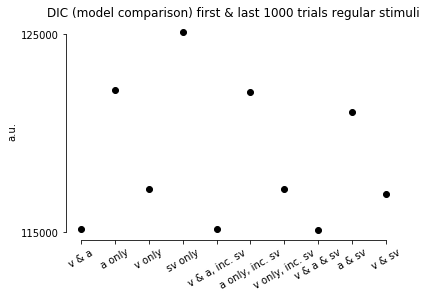

In [562]:
# DICs for regular stim models

simple_DICs = {'drift_thresh': 115146.017173, 'thresh_only': 122169.931848, 'drift_only': 117173.501543}

simple_variable_DICs = {'drift_thresh': 115146.017173, 
                        'thresh_only': 122169.931848, 
                        'drift_only': 117173.501543,
                        'driftvar_only': 125093.284004,
                        'drift_thresh_driftvar': 115145.706435, 
                        'thresh_only_driftvar': 122091.282755, 
                        'drift_only_driftvar': 117172.858576,
                        'drift_thresh_and_driftvar': 115109.267134,
                        'thresh_and_driftvar': 121044.588153,
                        'drift_and_driftvar': 116936.079996}

models = ['v & a', 'a only', 'v only', 'sv only', 
          'v & a, inc. sv', 'a only, inc. sv','v only, inc. sv',
         'v & a & sv', 'a & sv', 'v & sv']
fig,ax = plt.subplots(1)

ax.plot([simple_variable_DICs['drift_thresh'], 
          simple_variable_DICs['thresh_only'], 
          simple_variable_DICs['drift_only'],
          simple_variable_DICs['driftvar_only'],
          simple_variable_DICs['drift_thresh_driftvar'],
          simple_variable_DICs['thresh_only_driftvar'],
          simple_variable_DICs['drift_only_driftvar'],
          simple_variable_DICs['drift_thresh_and_driftvar'],
          simple_variable_DICs['thresh_and_driftvar'],
          simple_variable_DICs['drift_and_driftvar']], 
         linestyle=' ', marker='o', color = 'black')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation = 30)
ax.set_yticks([115000, 125000])
ax.set_ylabel('a.u.')
ax.set_title('DIC (model comparison) first & last 1000 trials regular stimuli')

sns.despine(trim=True)
fig.savefig('DIC_hddm_model_comparison_reg_stim.pdf')
fig.show()

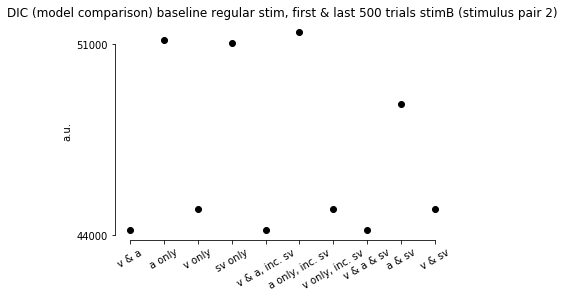

In [685]:
m_stimB_by_phase_drift_driftvar.dic



simple_variable_DICs = {'drift_thresh': m_stimB_by_phase_drift_thresh.dic, 
                        'thresh_only': m_stimB_by_phase_thresh.dic, 
                        'drift_only': m_stimB_by_phase_drift.dic,
                        'driftvar_only': m_stimB_by_phase_driftvar_only.dic,
                        'drift_thresh_driftvar': m_stimB_by_phase_drift_thresh_driftvar.dic, 
                        'thresh_only_driftvar': m_stimB_by_phase_thresh_driftvar.dic, 
                        'drift_only_driftvar': m_stimB_by_phase_drift_driftvar.dic,
                        'drift_thresh_and_driftvar': m_stimB_by_phase_drift_thresh_and_driftvar.dic,
                        'thresh_and_driftvar': m_stimB_by_phase_thresh_and_driftvar.dic,
                        'drift_and_driftvar': m_stimB_by_phase_drift_and_driftvar.dic}

models = ['v & a', 'a only', 'v only', 'sv only', 
          'v & a, inc. sv', 'a only, inc. sv','v only, inc. sv',
         'v & a & sv', 'a & sv', 'v & sv']
fig,ax = plt.subplots(1)

ax.plot([simple_variable_DICs['drift_thresh'], 
          simple_variable_DICs['thresh_only'], 
          simple_variable_DICs['drift_only'],
          simple_variable_DICs['driftvar_only'],
          simple_variable_DICs['drift_thresh_driftvar'],
          simple_variable_DICs['thresh_only_driftvar'],
          simple_variable_DICs['drift_only_driftvar'],
          simple_variable_DICs['drift_thresh_and_driftvar'],
          simple_variable_DICs['thresh_and_driftvar'],
          simple_variable_DICs['drift_and_driftvar']], 
         linestyle=' ', marker='o', color = 'black')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation = 30)
ax.set_yticks([44000, 51000])
ax.set_ylabel('a.u.')
ax.set_title('DIC (model comparison) baseline regular stim, first & last 500 trials stimB (stimulus pair 2)')

sns.despine(trim=True)
fig.savefig('DIC_hddm_model_comparison_stimB.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Passing `normed=

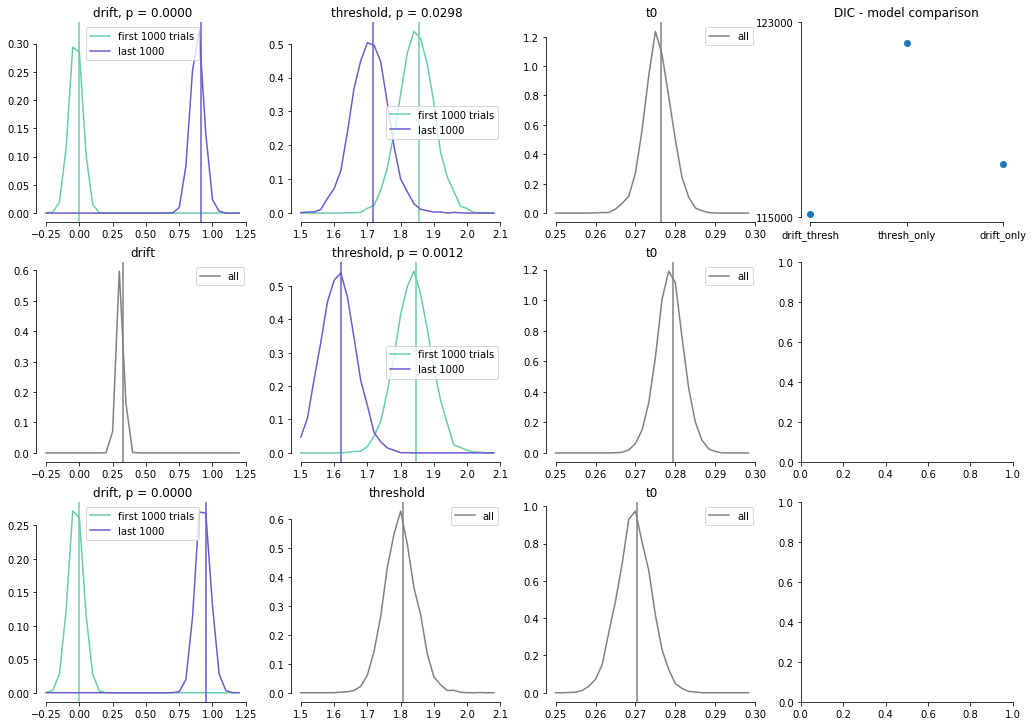

In [139]:
fig, ax = plt.subplots(3,4, figsize = (17.5,12.5))

simple_DICs = {'drift_thresh': 115146.017173, 'thresh_only': 122169.931848, 'drift_only': 117173.501543}

models = ['drift_thresh', 'thresh_only', 'drift_only']
ax[0,3].plot([simple_DICs['drift_thresh'], simple_DICs['thresh_only'], simple_DICs['drift_only']],linestyle=' ', marker='o')
ax[0,3].set_xticks([0,1,2])
ax[0,3].set_xticklabels(['drift_thresh', 'thresh_only', 'drift_only'])
ax[0,3].set_yticks([115000, 123000])
ax[0,3].set_title('DIC - model comparison')

# ~~~ drift and threshold depend on phase ~~~

# drifts
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh['v(0)']
x1 = drift_thresh['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'mediumaquamarine')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'slateblue', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'slateblue')

ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)


# thresholds
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh['a(0)']
x1 = drift_thresh['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,1].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'first 1000 trials')
ax[0,1].axvline(np.median(x0), color = 'mediumaquamarine')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,1].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'slateblue', label = 'last 1000')
ax[0,1].axvline(np.median(x1), color = 'slateblue')

ax[0,1].legend()
ax[0,1].set_title('threshold, p = %.4f' %pval)

# t0
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,2].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'all')
ax[0,2].axvline(np.median(x0), color = 'gray')

ax[0,2].legend()
ax[0,2].set_title('t0')

# ~~~ threshold only depends on phase ~~~

# drifts
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = thresh_only['v']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'gray')

ax[1,0].legend()
ax[1,0].set_title('drift')


# thresholds
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = thresh_only['a(0)']
x1 = thresh_only['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,1].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'first 1000 trials')
ax[1,1].axvline(np.median(x0), color = 'mediumaquamarine')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,1].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'slateblue', label = 'last 1000')
ax[1,1].axvline(np.median(x1), color = 'slateblue')

ax[1,1].legend()
ax[1,1].set_title('threshold, p = %.4f' %pval)

# t0
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = thresh_only['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,2].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'all')
ax[1,2].axvline(np.median(x0), color = 'gray')

ax[1,2].legend()
ax[1,2].set_title('t0')

# ~~~ drift only depends on phase ~~~

# drifts
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_only['v(0)']
x1 = drift_only['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'mediumaquamarine', label = 'first 1000 trials')
ax[2,0].axvline(np.median(x0), color = 'mediumaquamarine')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'slateblue', label = 'last 1000')
ax[2,0].axvline(np.median(x1), color = 'slateblue')

ax[2,0].legend()
ax[2,0].set_title('drift, p = %.4f' %pval)


# thresholds
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = drift_only['a']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,1].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'all')
ax[2,1].axvline(np.median(x0), color = 'gray')

ax[2,1].legend()
ax[2,1].set_title('threshold')

# t0
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_only['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,2].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'all')
ax[2,2].axvline(np.median(x0), color = 'gray')

ax[2,2].legend()
ax[2,2].set_title('t0')


sns.despine(trim=True)
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:83: VisibleDeprecationWarning: Passing `normed=

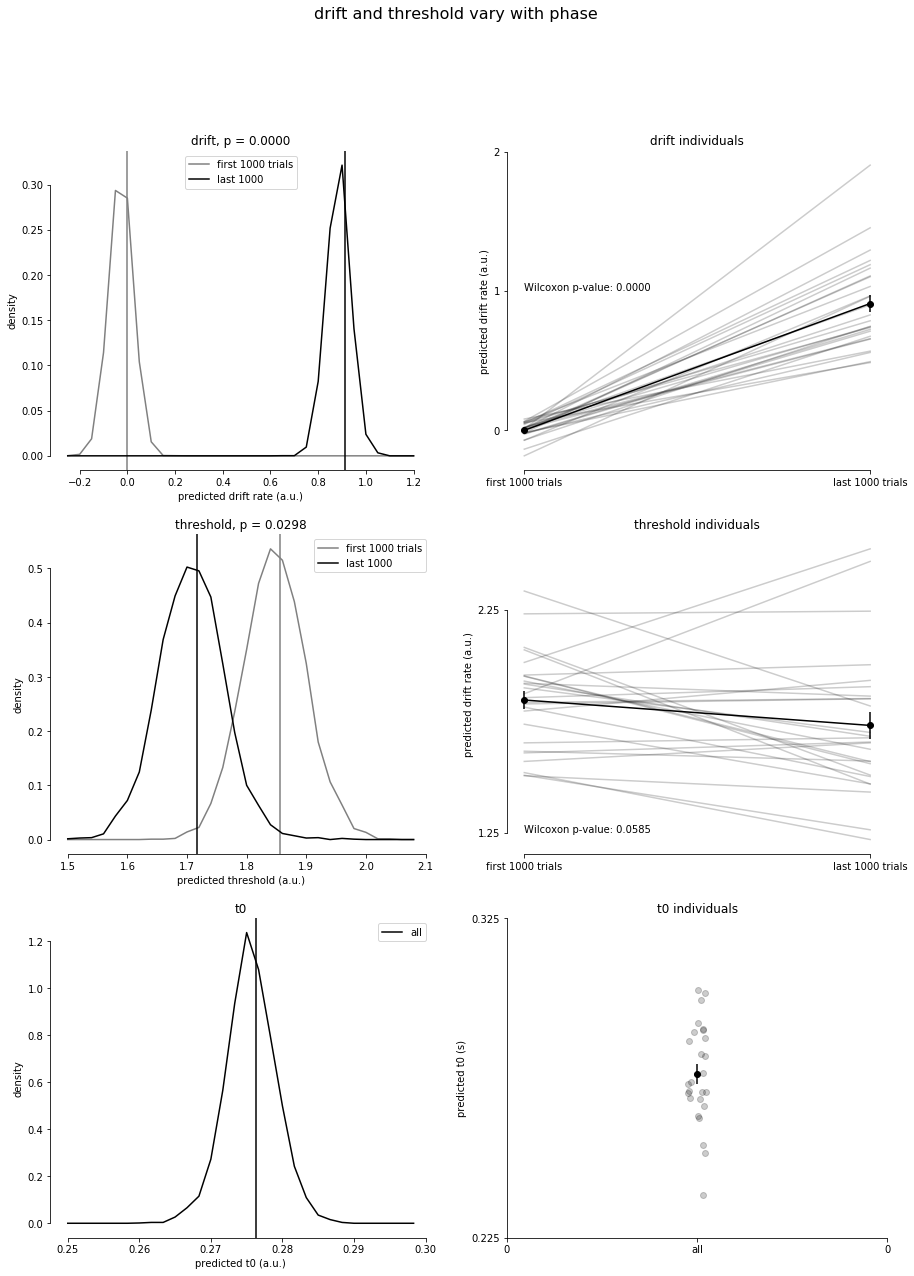

In [411]:
# drift and threshold vary with phase

fig, ax = plt.subplots(3,2, figsize = (15,20))

# simple_DICs = {'drift_thresh': 115146.017173, 'thresh_only': 122169.931848, 'drift_only': 117173.501543}

# models = ['drift_thresh', 'thresh_only', 'drift_only']
# ax[0,3].plot([simple_DICs['drift_thresh'], simple_DICs['thresh_only'], simple_DICs['drift_only']],linestyle=' ', marker='o')
# ax[0,3].set_xticks([0,1,2])
# ax[0,3].set_xticklabels(['drift_thresh', 'thresh_only', 'drift_only'])
# ax[0,3].set_yticks([115000, 123000])
# ax[0,3].set_title('DIC - model comparison')

# ~~~ drift and threshold depend on phase ~~~

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh['v(0)']
x1 = drift_thresh['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)

# drifts individuals
stats = drift_thresh_stats
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1, s)
# s = 'n = %d' %len(idx)
# ax[0,1].text(0,-0.7, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh['a(0)']
x1 = drift_thresh['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = drift_thresh_stats
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = drift_thresh_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels([0,'all',0])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('drift and threshold vary with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_drift_thresh_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning

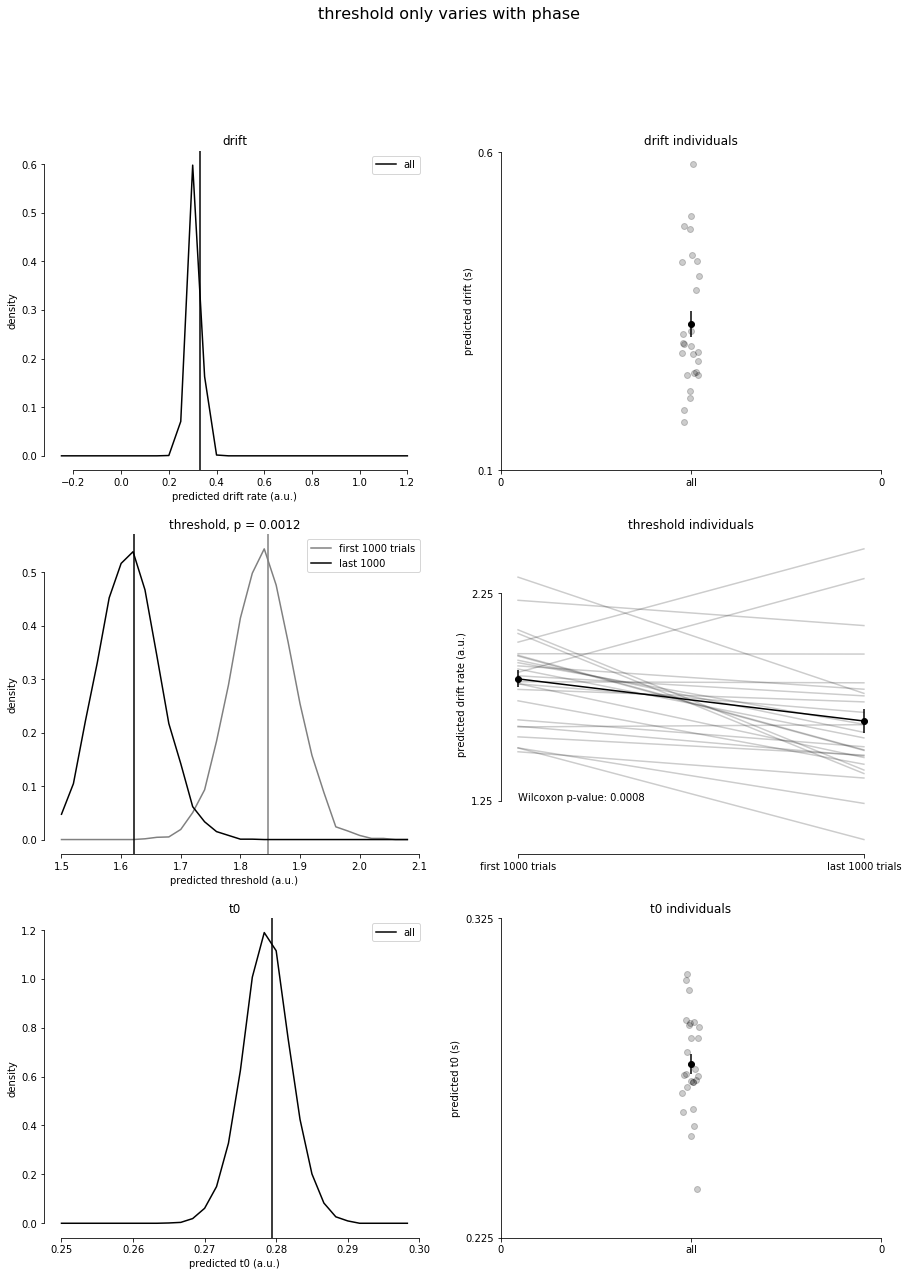

In [412]:
# threshold only varies with phase


fig, ax = plt.subplots(3,2, figsize = (15,20))

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = thresh_only['v']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[0,0].axvline(np.median(x0), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = thresh_only_stats
cond_0 = 'v_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels(['0','all','0'])
ax[0,1].set_yticks([0.1,0.6])
ax[0,1].set_ylabel('predicted drift (s)')
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = thresh_only['a(0)']
x1 = thresh_only['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = thresh_only_stats
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = thresh_only['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = thresh_only_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels(['0','all','0'])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('threshold only varies with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_thresh_only_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: Passing `normed=

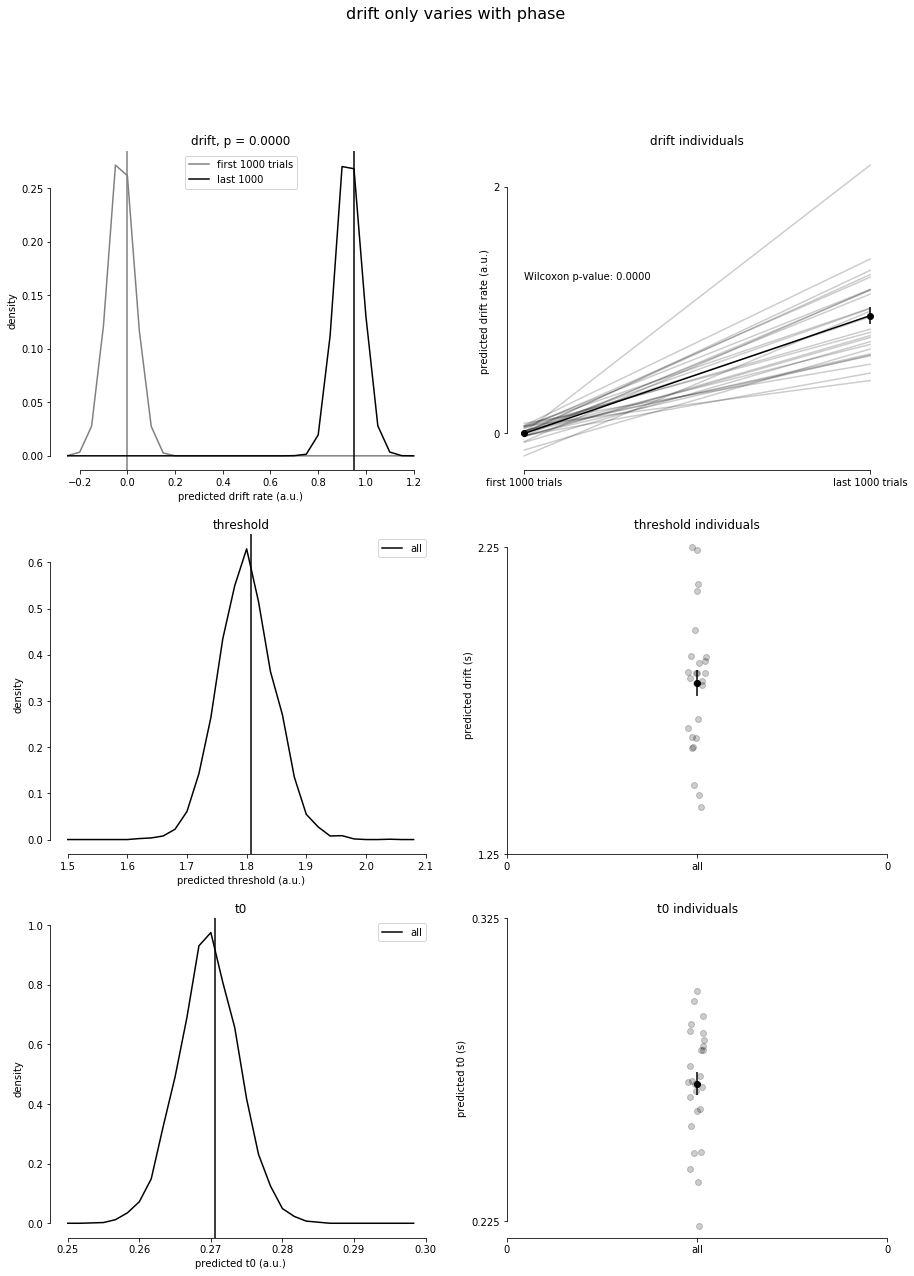

In [413]:
# drift only varies with phase


fig, ax = plt.subplots(3,2, figsize = (15,20))

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_only['v(0)']
x1 = drift_only['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)


# drifts individuals
stats = drift_only_stats
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[0,1].set_yticks([0,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1.25, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = drift_only['a']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold')


# thresholds individuals
stats = drift_only_stats
cond_0 = 'a_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0.5,1,1.5])
ax[1,1].set_xticklabels(['0','all','0'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift (s)')
ax[1,1].set_title('threshold individuals')



# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_only['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = drift_only_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels(['0','all','0'])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('drift only varies with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_drift_only_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Passing `normed=

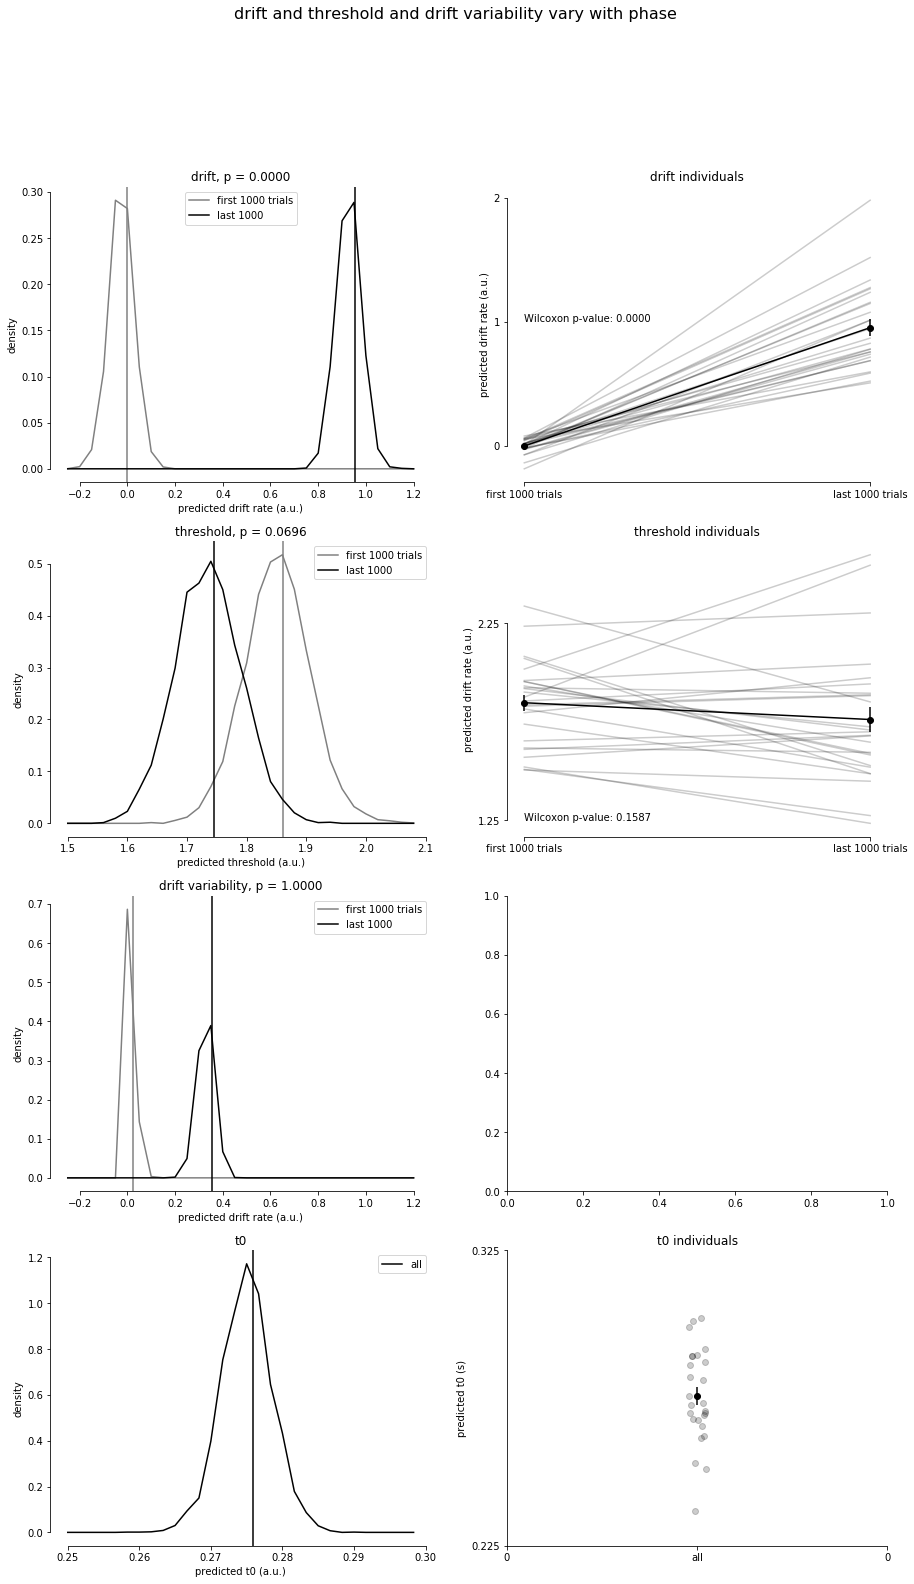

In [460]:
# drift and threshold and drift variability vary with phase


fig, ax = plt.subplots(4,2, figsize = (15,25))

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh_and_driftvar['v(0)']
x1 = drift_thresh_and_driftvar['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)

# drifts individuals
stats = drift_thresh_and_driftvar_stats
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1, s)
# s = 'n = %d' %len(idx)
# ax[0,1].text(0,-0.7, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh_and_driftvar['a(0)']
x1 = drift_thresh_and_driftvar['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = drift_thresh_and_driftvar_stats
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh_and_driftvar['sv(0)']
x1 = drift_thresh_and_driftvar['sv(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability, p = %.4f' %pval)

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh_and_driftvar['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = drift_thresh_and_driftvar_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('drift and threshold and drift variability vary with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_drift_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Passing `normed=

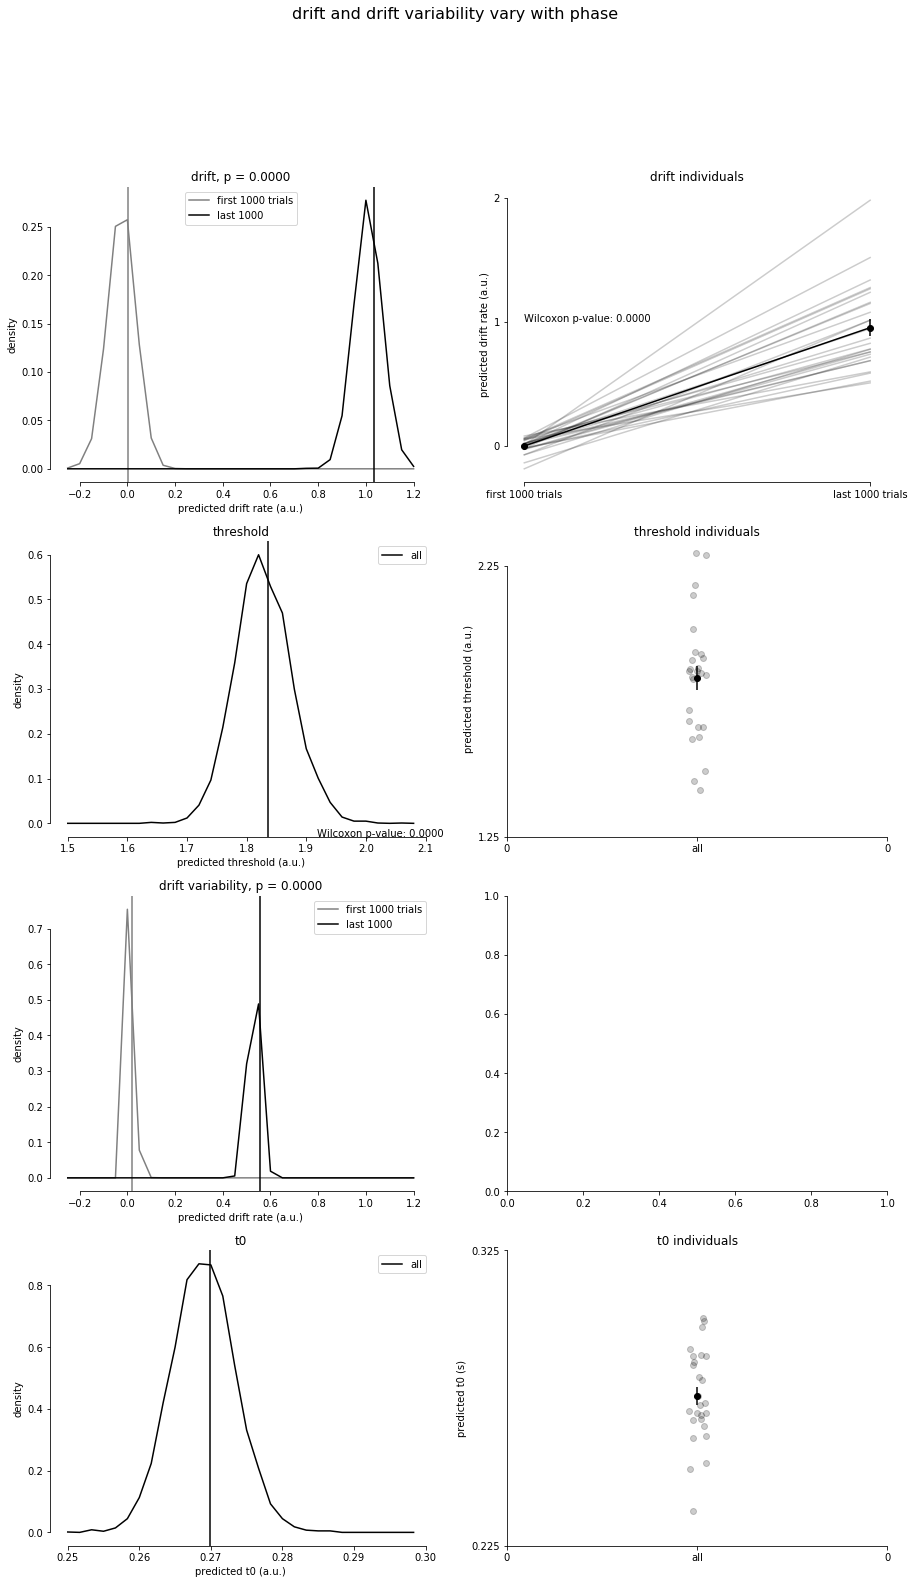

In [419]:
# drift and drift variability vary with phase


fig, ax = plt.subplots(4,2, figsize = (15,25))

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_and_driftvar['v(0)']
x1 = drift_and_driftvar['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)

# drifts individuals
stats = drift_thresh_and_driftvar_stats
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1, s)
# s = 'n = %d' %len(idx)
# ax[0,1].text(0,-0.7, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = drift_and_driftvar['a']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = drift_and_driftvar_stats
cond_0 = 'a_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0.5,1,1.5])
ax[1,1].set_xticklabels([0,'all',0])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = drift_and_driftvar['sv(0)']
x1 = drift_and_driftvar['sv(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability, p = %.4f' %pval)


# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_and_driftvar['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = drift_thresh_and_driftvar_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('drift and drift variability vary with phase',fontsize = 16)
sns.despine(trim=True) 
fig.savefig('AK_AL_regstim_first_and_last1000_drift_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Passing `normed=

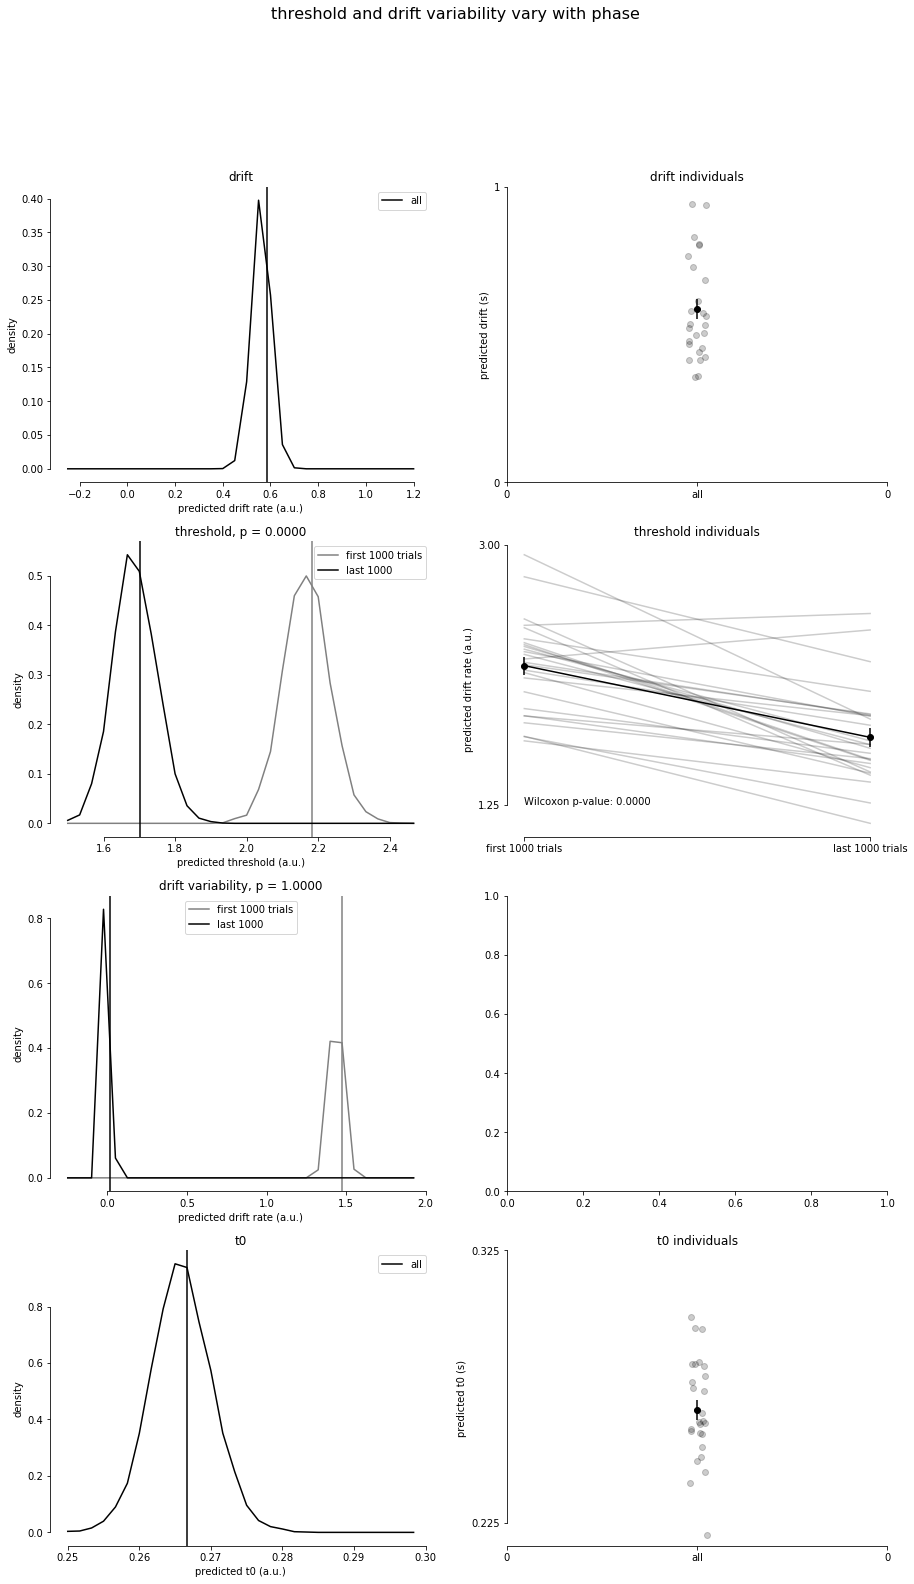

In [459]:
# threshold and drift variability vary with phase


fig, ax = plt.subplots(4,2, figsize = (15,25))


data = thresh_and_driftvar
data_stats = thresh_and_driftvar_stats

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['v']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[0,0].axvline(np.median(x0), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond_0 = 'v_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels(['0','all','0'])
ax[0,1].set_yticks([0,1])
ax[0,1].set_ylabel('predicted drift (s)')
ax[0,1].set_title('drift individuals')

# thresholds average
range_ = (1.5, 2.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[1,1].set_yticks([1.25,3])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 2)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability, p = %.4f' %pval)

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('threshold and drift variability vary with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Passing `normed=

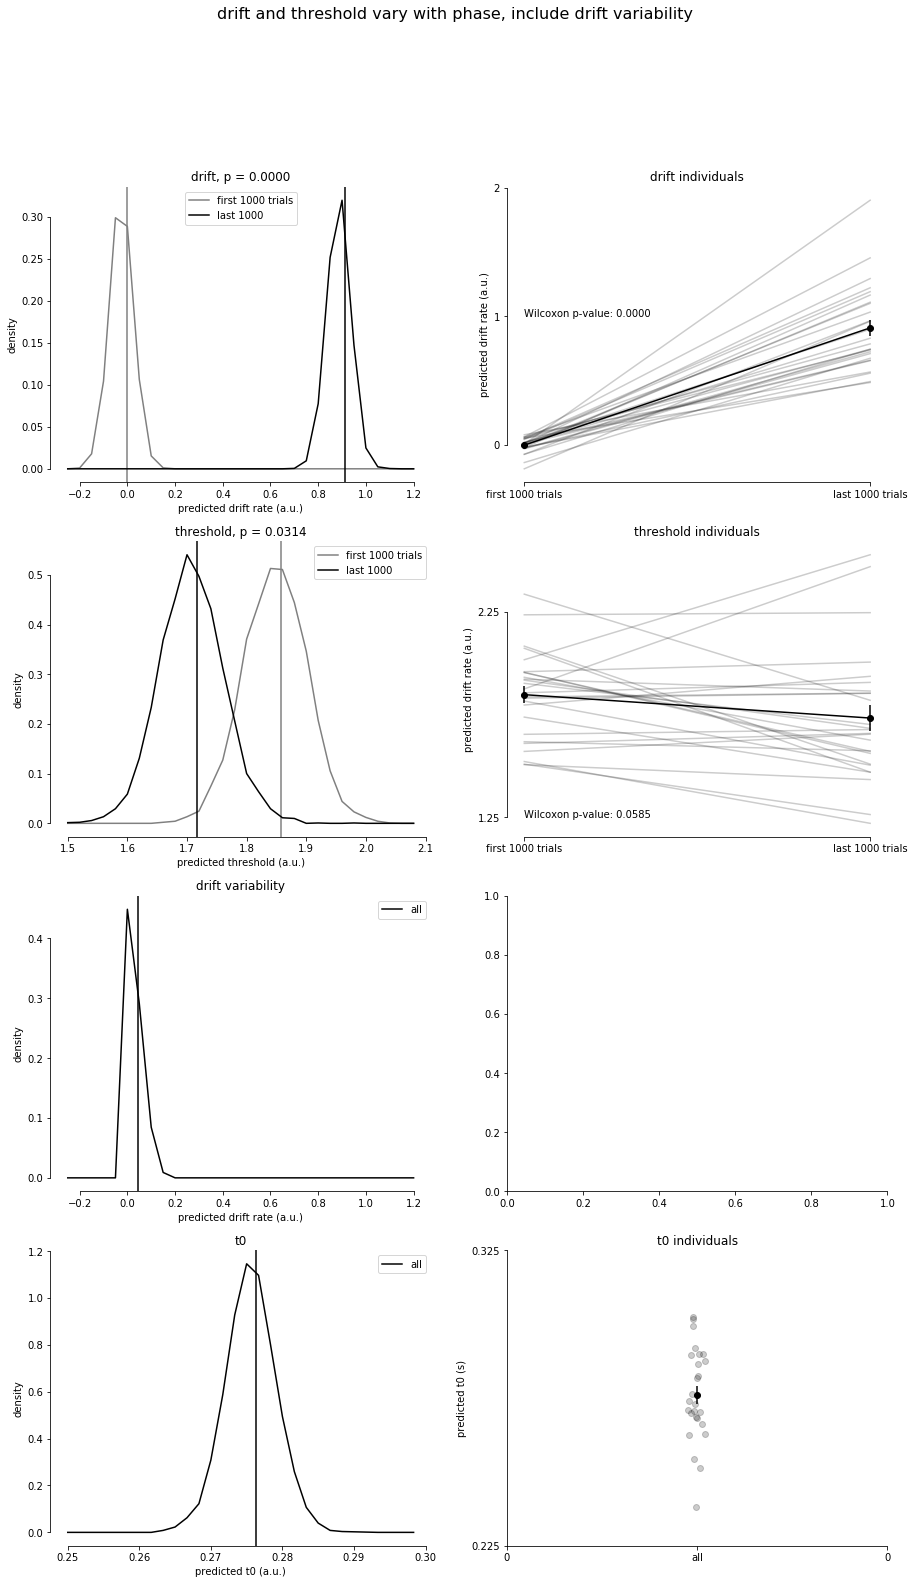

In [429]:
# drift and threshold vary with phase, include drift variability


fig, ax = plt.subplots(4,2, figsize = (15,25))

data = drift_thresh_driftvar
data_stats = drift_thresh_driftvar_stats

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)

# drifts individuals
stats = data_stats
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1, s)
# s = 'n = %d' %len(idx)
# ax[0,1].text(0,-0.7, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('drift and threshold vary with phase, include drift variability',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_drift_thresh_include_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Passing `normed=

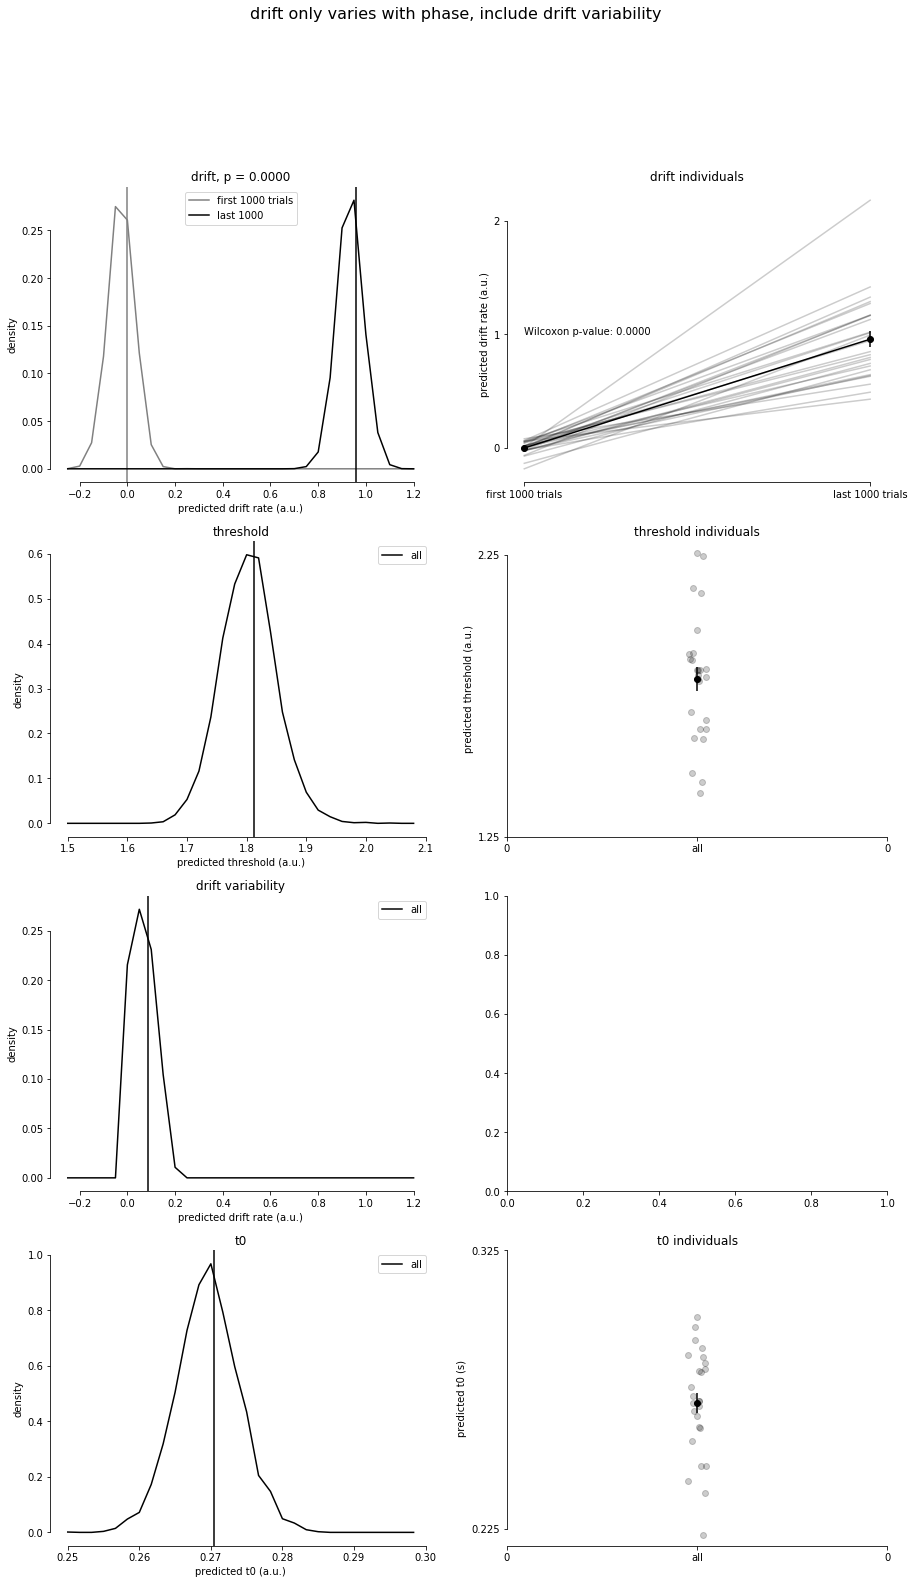

In [431]:
# drift only varies with phase, include drift variability


fig, ax = plt.subplots(4,2, figsize = (15,25))

data = drift_only_driftvar
data_stats = drift_only_driftvar_stats

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)

# drifts individuals
stats = data_stats
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1, s)
# s = 'n = %d' %len(idx)
# ax[0,1].text(0,-0.7, s)
ax[0,1].set_title('drift individuals')

# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = data['a']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0.5,1,1.5])
ax[1,1].set_xticklabels([0,'all',0])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
ax[1,1].set_title('threshold individuals')


# drift variability average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('drift only varies with phase, include drift variability',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_drift_only_include_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Passing `normed=

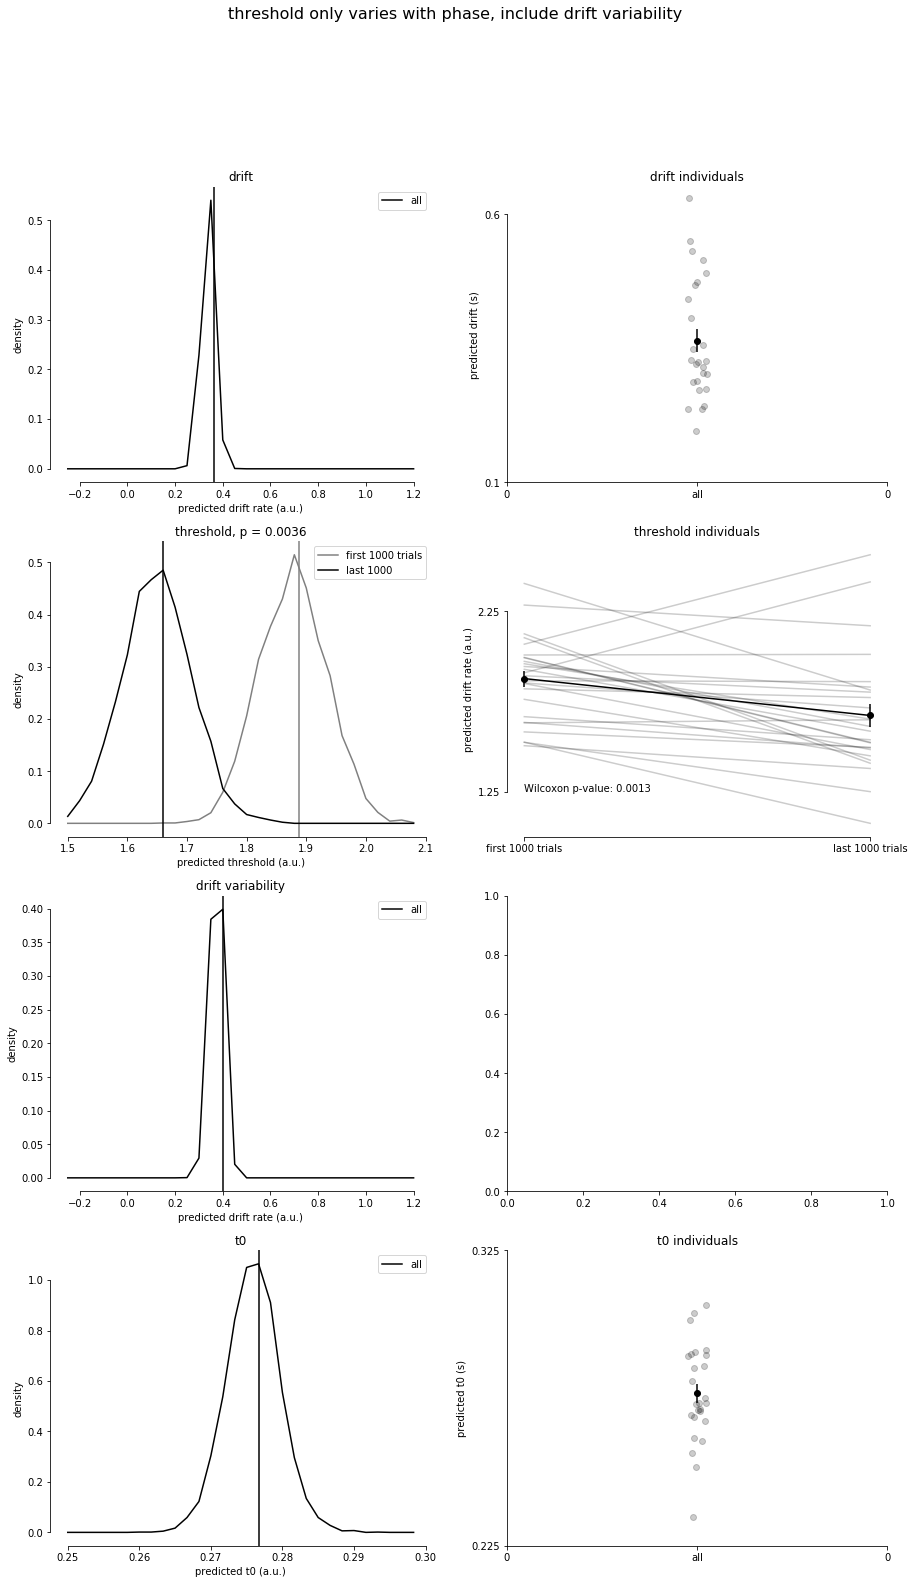

In [432]:
# threshold only varies with phase, include drift variability


fig, ax = plt.subplots(4,2, figsize = (15,25))

data = thresh_only_driftvar
data_stats = thresh_only_driftvar_stats

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['v']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[0,0].axvline(np.median(x0), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond_0 = 'v_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels(['0','all','0'])
ax[0,1].set_yticks([0.1,0.6])
ax[0,1].set_ylabel('predicted drift (s)')
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('threshold only varies with phase, include drift variability',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_first_and_last1000_thresh_only_include_driftvar_hddm_fits.pdf')
fig.show()

#### stimB plots

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

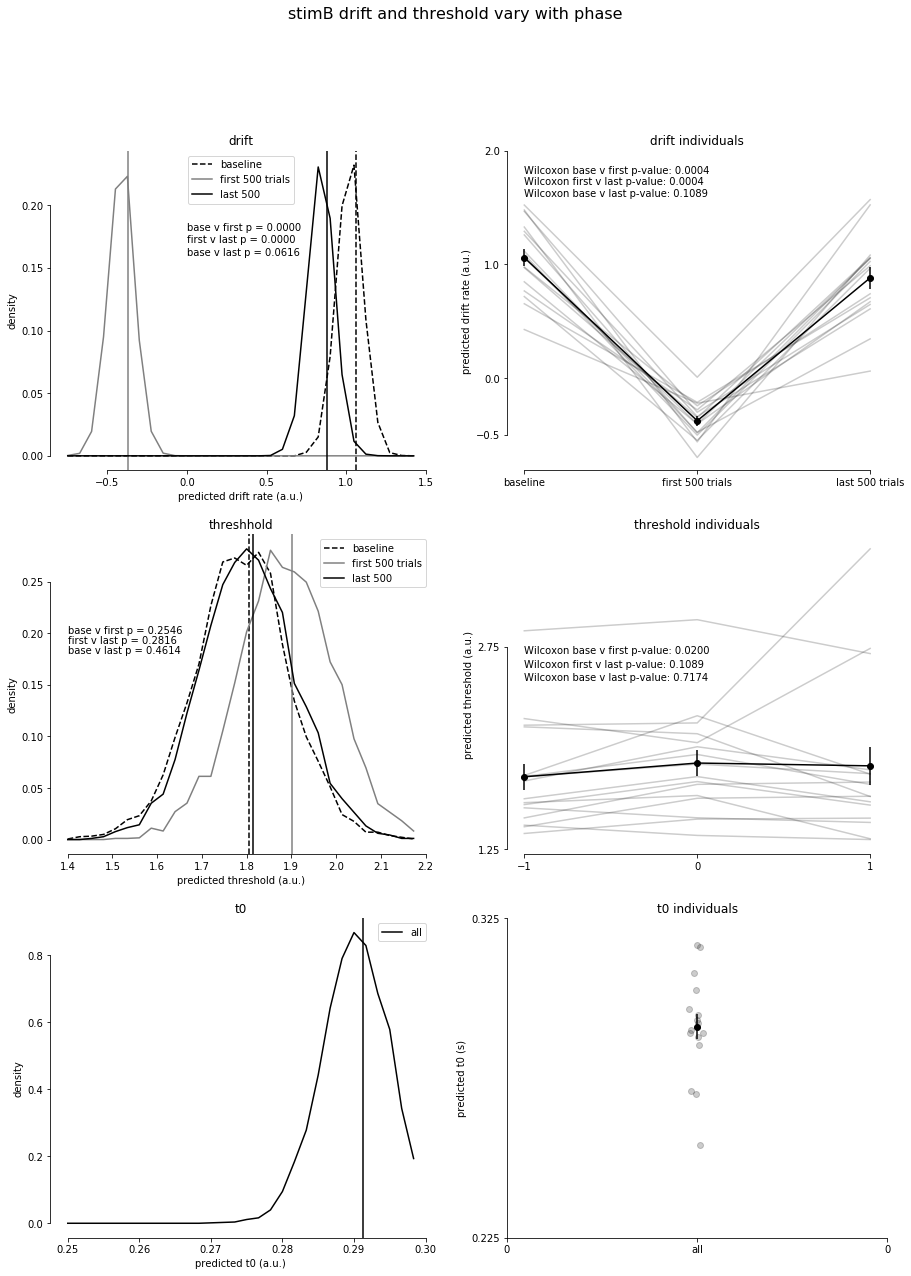

In [510]:
# drift and threshold vary with phase

fig, ax = plt.subplots(3,2, figsize = (15,20))

data = stimB_drift_thresh
data_stats = stimB_drift_thresh_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels([0,'all',0])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('stimB drift and threshold vary with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_drift_thresh_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

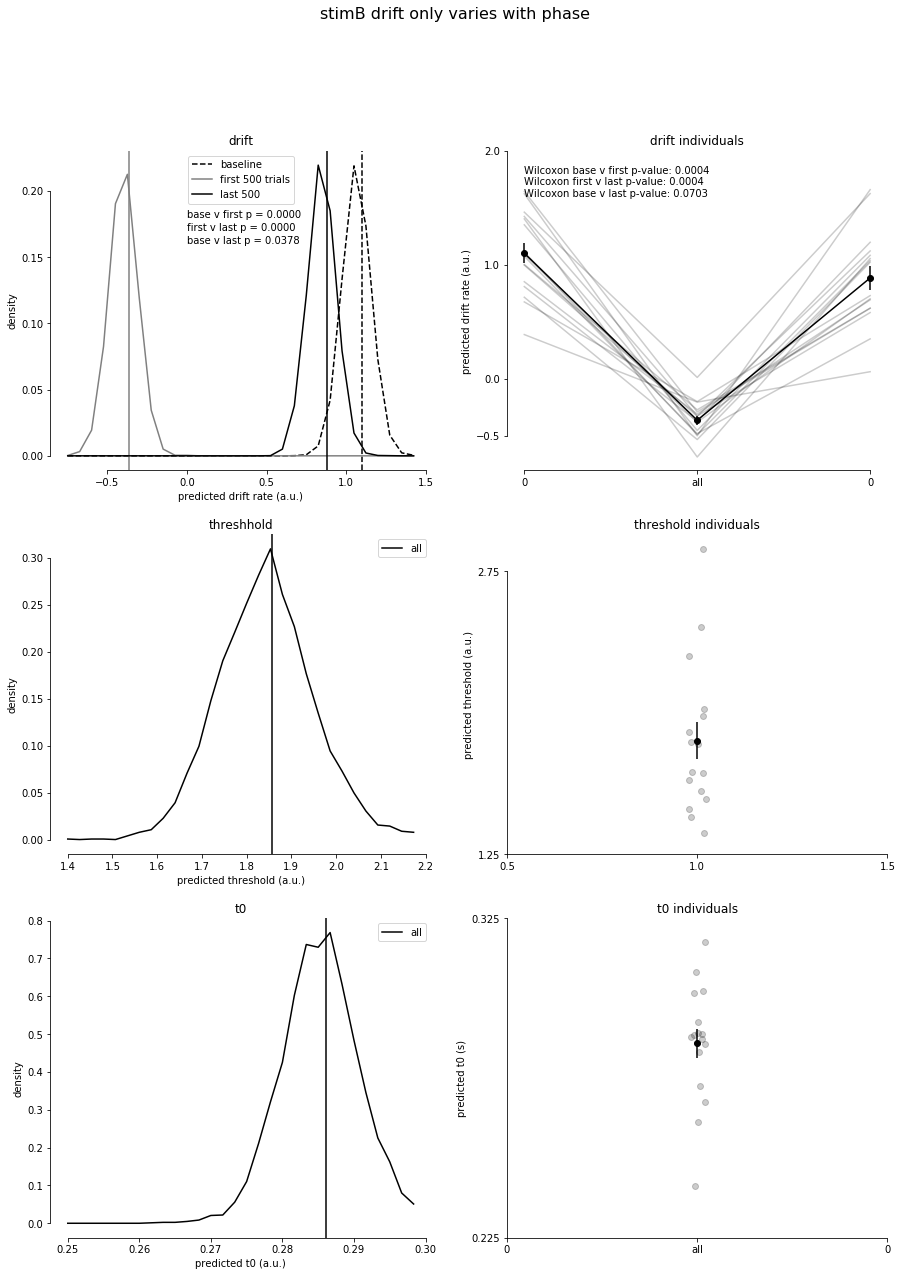

In [511]:
# drift only varies with phase

fig, ax = plt.subplots(3,2, figsize = (15,20))

data = stimB_drift_only
data_stats = stimB_drift_only_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x0 = data['a']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels([0,'all',0])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
ax[1,1].set_title('threshold individuals')

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels([0,'all',0])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('stimB drift only varies with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_drift_only_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Passing `normed=

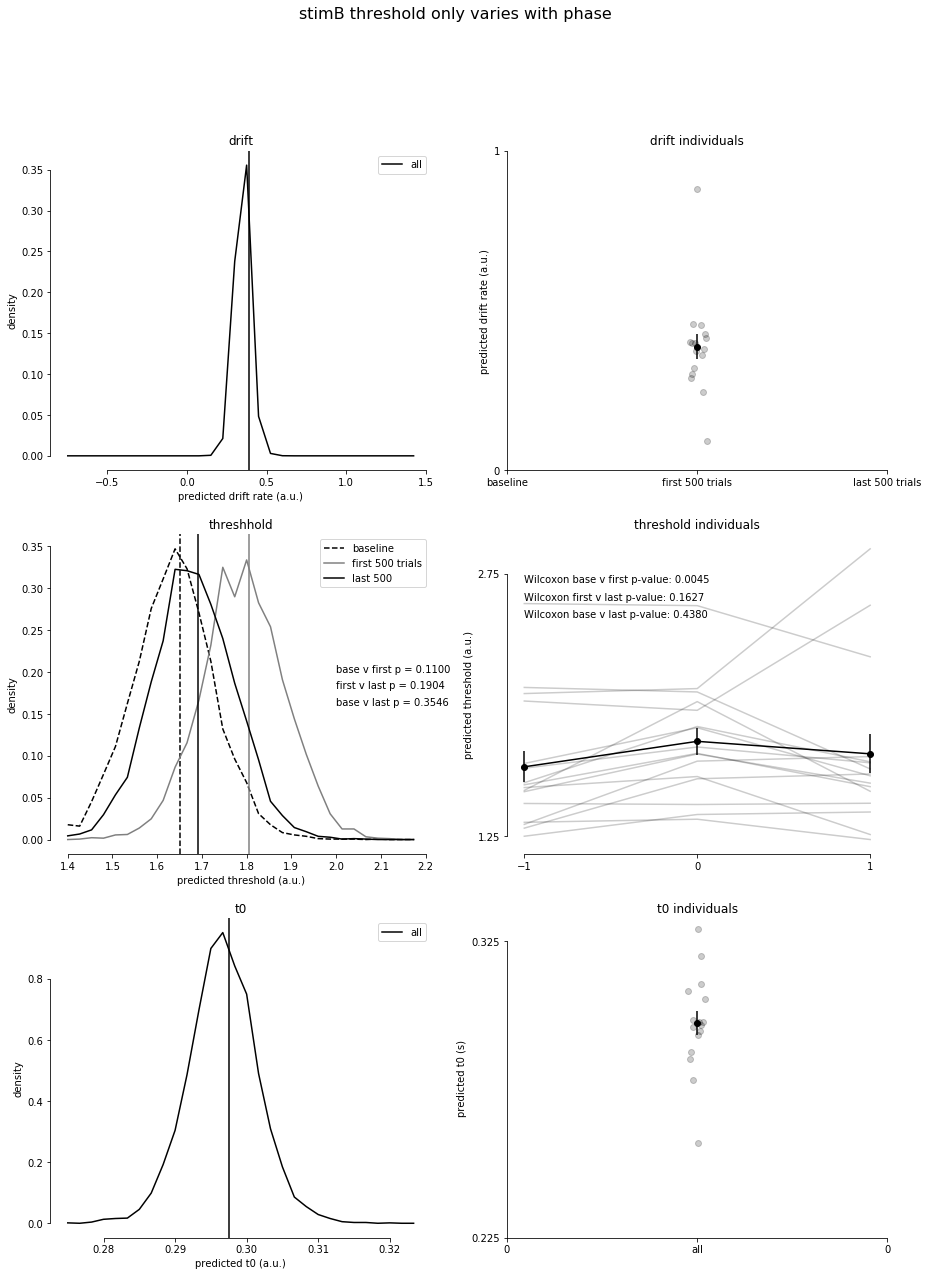

In [523]:
# threshold only varies with phase

fig, ax = plt.subplots(3,2, figsize = (15,20))

data = stimB_thresh_only
data_stats = stimB_thresh_only_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['v']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[0,0].axvline(np.median(x0), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond_0 = 'v_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels([0,'all',0])
ax[0,1].set_yticks([0,1])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
ax[0,1].set_title('drift individuals')

# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(2.0, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(2.0, 0.18, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(2.0, 0.16, s)
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')

# t0 average
range_ = (0.275, 0.325)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels([0,'all',0])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('stimB threshold only varies with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_thresh_only_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

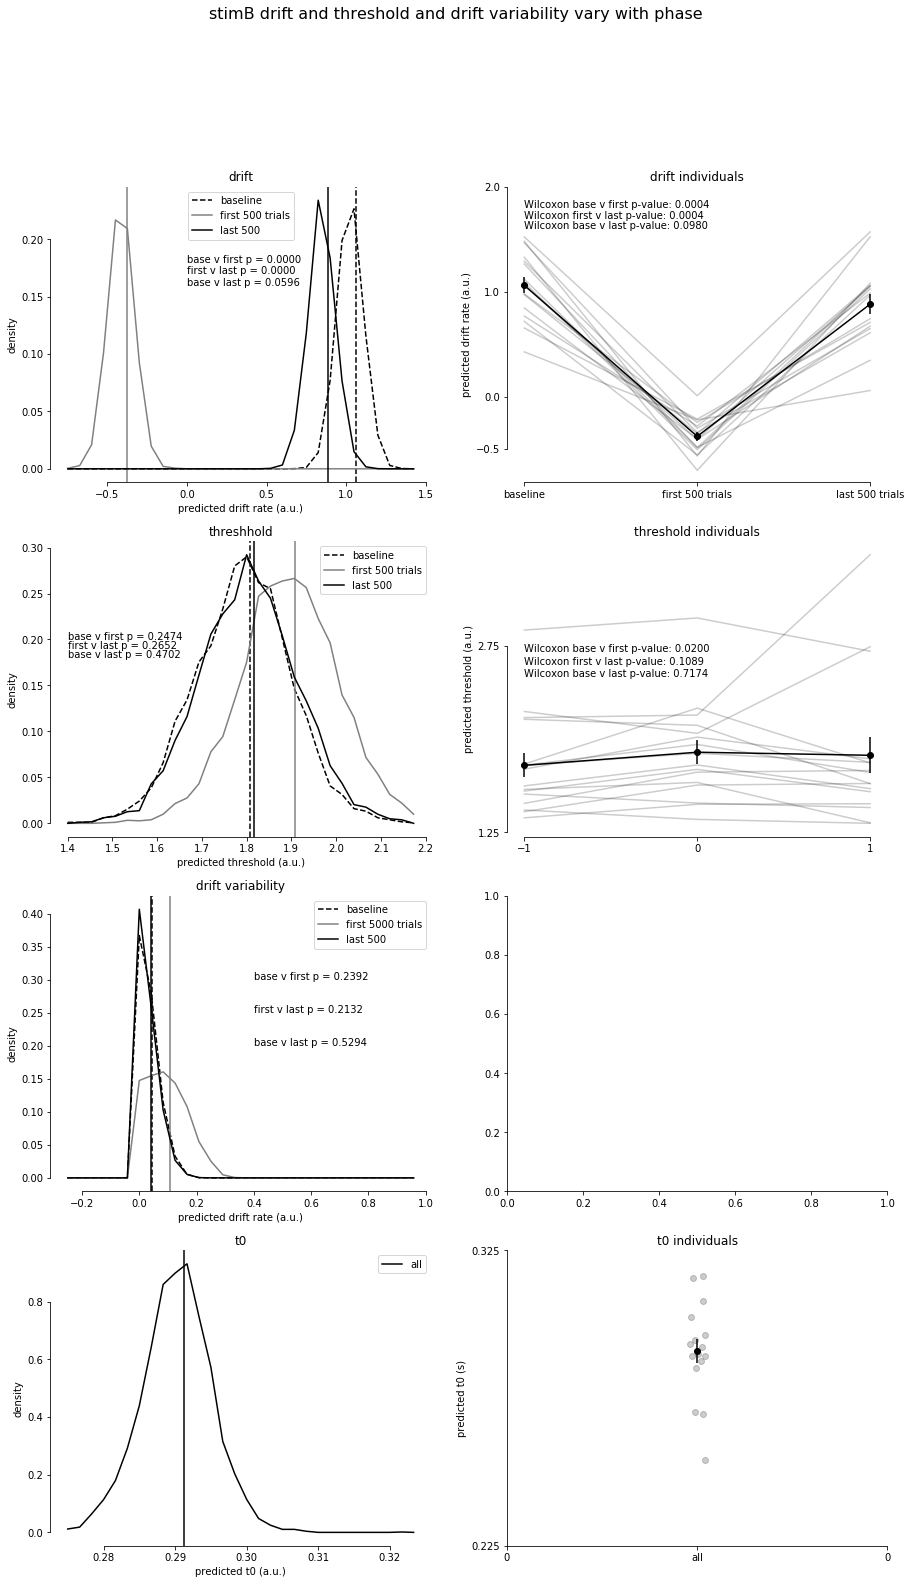

In [537]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = stimB_drift_thresh_and_driftvar
data_stats = stimB_drift_thresh_and_driftvar_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.25, 1)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.4, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.4, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.4, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')



# t0 average
range_ = (0.275, 0.325)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('stimB drift and threshold and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_drift_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

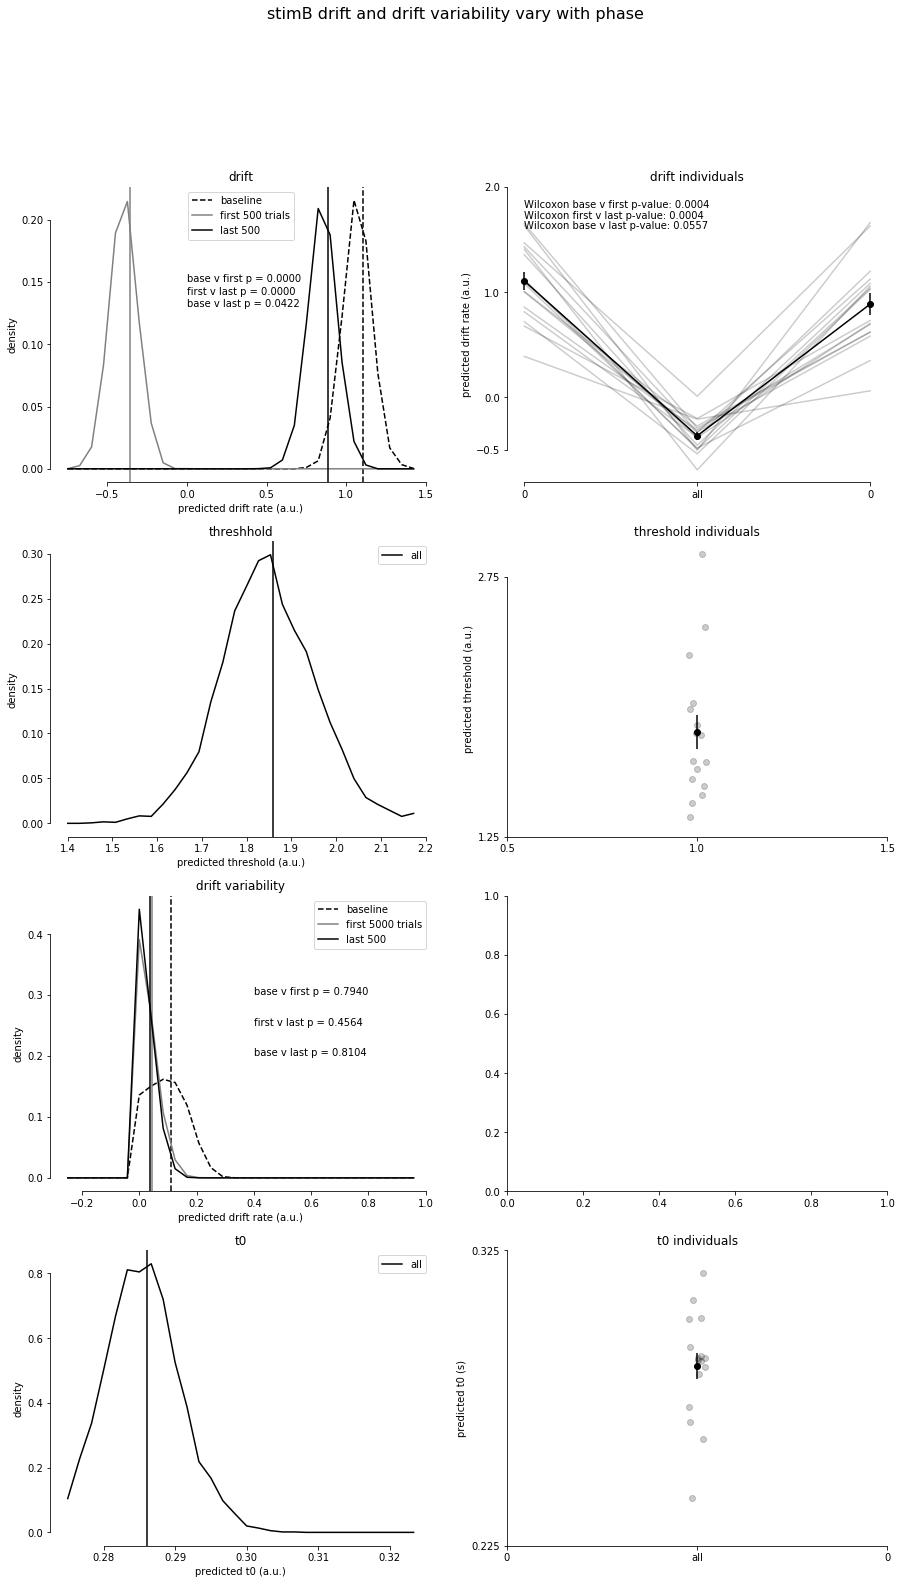

In [539]:
# drift and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = stimB_drift_and_driftvar
data_stats = stimB_drift_and_driftvar_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.15, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.14, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.13, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x0 = data['a']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels([0,'all',0])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
ax[1,1].set_title('threshold individuals')


# drift variability average
range_ = (-0.25, 1)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.4, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.4, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.4, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')



# t0 average
range_ = (0.275, 0.325)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('stimB drift and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_drift_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  app.launch_new_instance()
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecat

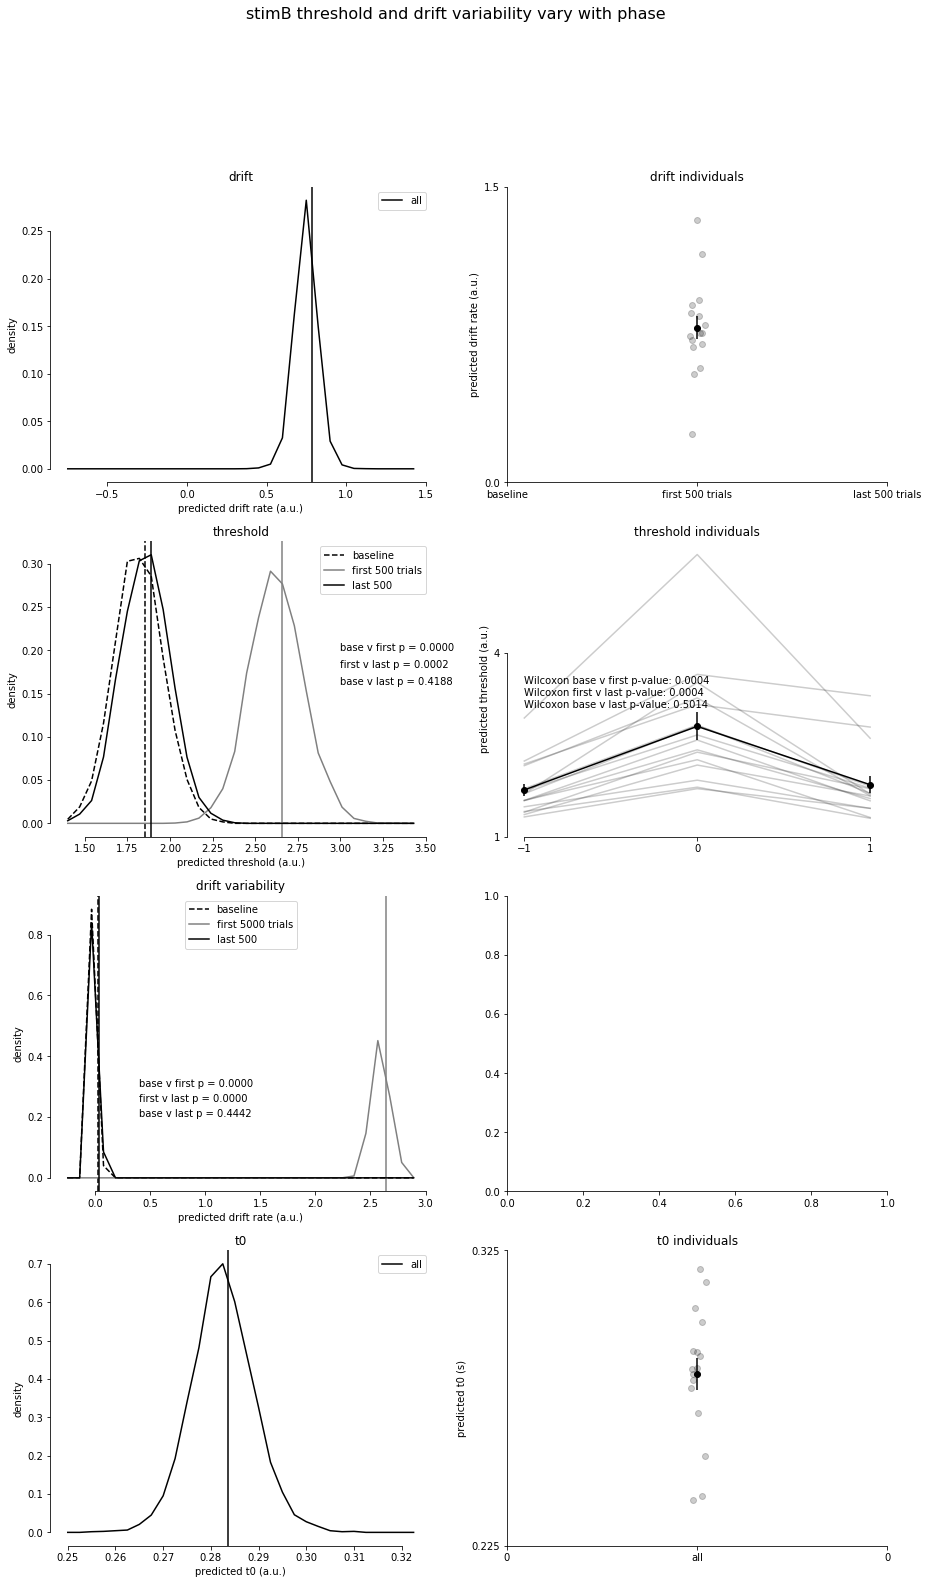

In [552]:
# threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = stimB_thresh_and_driftvar
data_stats = stimB_thresh_and_driftvar_stats

# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['v']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[0,0].axvline(np.median(x0), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond_0 = 'v_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels([0,'all',0])
ax[0,1].set_yticks([0,1.5])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 3.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(3, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(3, 0.18, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(3, 0.16, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1,4])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 3.5, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 3.3, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 3.1, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.25, 3)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.4, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.4, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.4, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')



# t0 average
range_ = (0.25, 0.325)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('stimB threshold and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

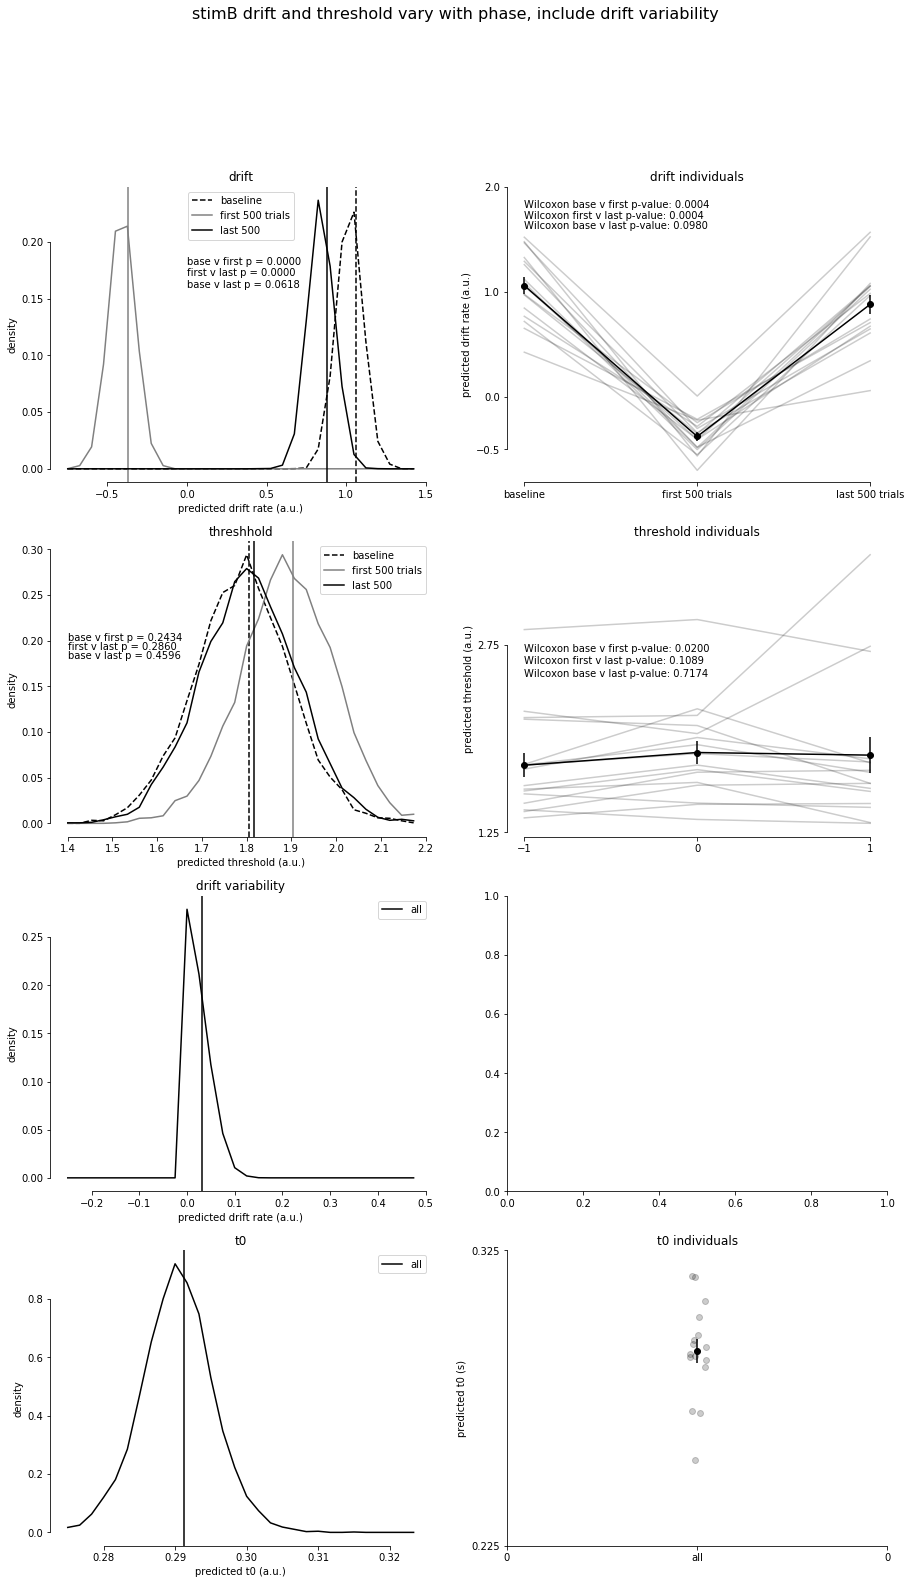

In [526]:
# drift and threshold vary with phase, include drift variability

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = stimB_drift_thresh_driftvar
data_stats = stimB_drift_thresh_driftvar_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 0.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability')


# t0 average
range_ = (0.275, 0.325)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('stimB drift and threshold vary with phase, include drift variability',fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_drift_thresh_include_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:72: VisibleDeprecationWarning: Passing `normed=

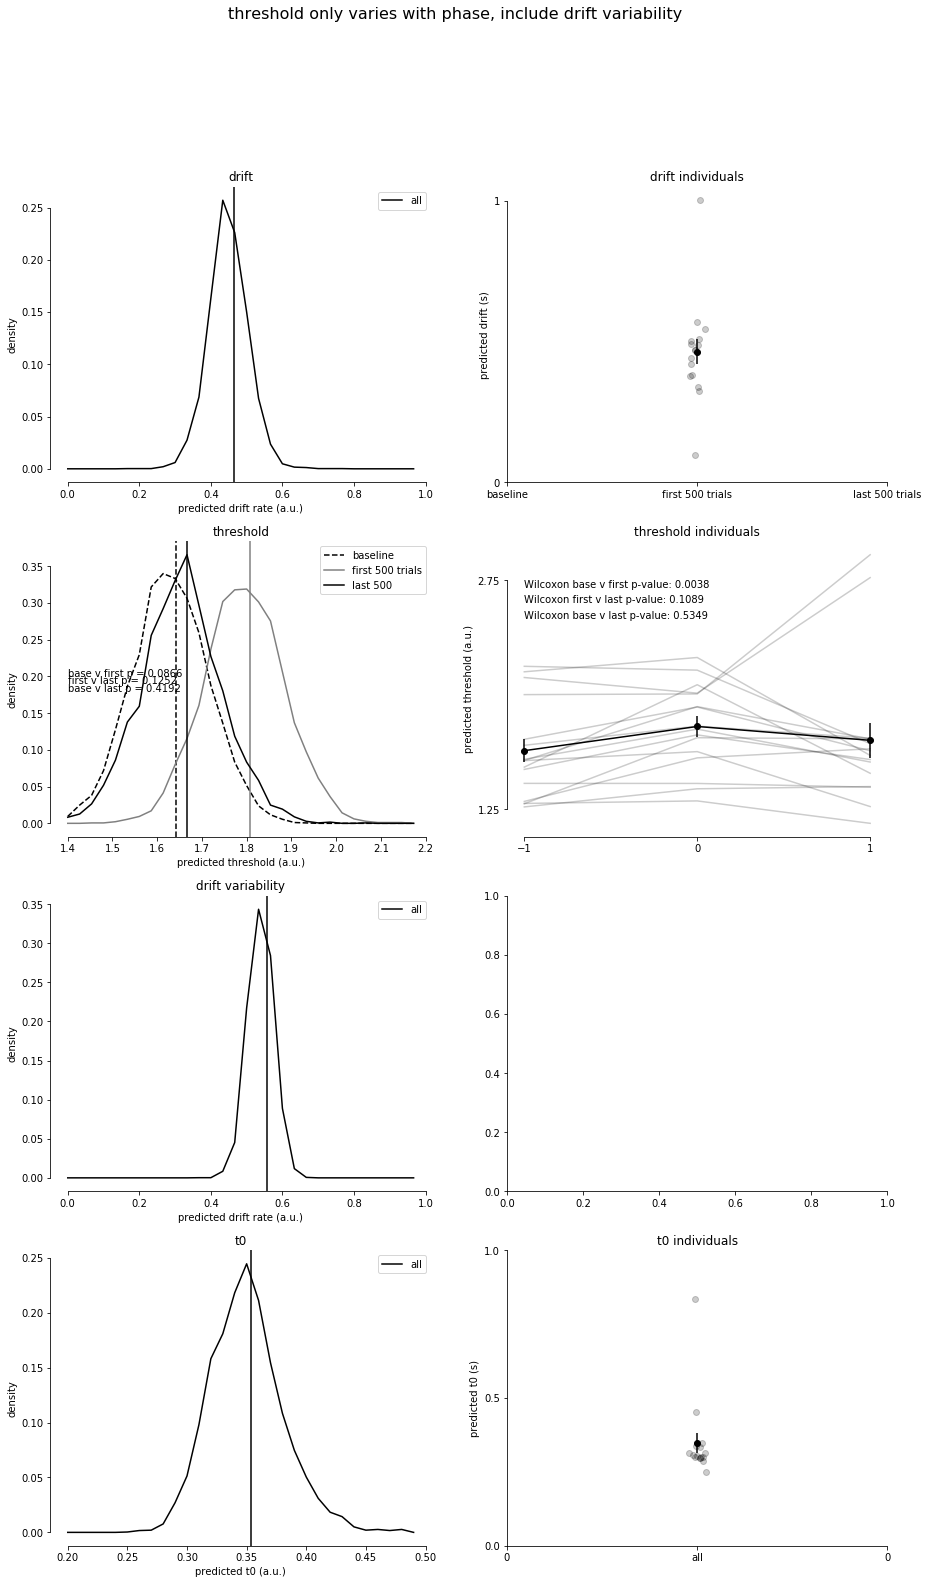

In [8]:
# threshold only varies with phase, include drift variability

stimB_thresh_only_driftvar = pickle.load( open( '_data/hddmmodels/stimB_thresh_only_driftvar', "rb" ) )
stimB_thresh_only_driftvar_stats = pickle.load( open( '_data/hddmmodels/stimB_thresh_only_driftvar_stats', "rb" ) )


fig, ax = plt.subplots(4,2, figsize = (15,25))

data = stimB_thresh_only_driftvar
data_stats = stimB_thresh_only_driftvar_stats

# drifts average
range_ = (0, 1)
n_bins = 30
alpha = 1
normed = True

x0 = data['v']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[0,0].axvline(np.median(x0), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond_0 = 'v_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels(['0','all','0'])
ax[0,1].set_yticks([0,1])
ax[0,1].set_ylabel('predicted drift (s)')
ax[0,1].set_title('drift individuals')

# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')


# # thresholds average
# range_ = (1.2, 2.2)
# n_bins = 30
# alpha = 1
# normed = True

# x0 = data['a(0)']
# x1 = data['a(1)']

# diff = np.subtract(x1, x0)
# pval = np.sum(diff > 0) / len(diff)

# hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
# ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 1000 trials')
# ax[1,0].axvline(np.median(x0), color = 'gray')

# hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
# ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 1000')
# ax[1,0].axvline(np.median(x1), color = 'black')

# ax[1,0].set_ylabel('density')
# ax[1,0].set_xlabel('predicted threshold (a.u.)')
# ax[1,0].legend()
# ax[1,0].set_title('threshold, p = %.4f' %pval)

# # thresholds individuals
# stats = data_stats
# cond_0 = 'a_subj(0)'
# cond_1 = 'a_subj(1)'

# idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
# means_0 = np.array(stats['mean'].iloc[idx])

# idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
# means_1 = np.array(stats['mean'].iloc[idx])

# x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
# y = np.array([means_0, means_1])

# ymean = [np.mean(means_0), np.mean(means_1)]
# ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
# xidx = [0,1]

# ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
# ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
# ax[1,1].set_xticks([0,1])
# ax[1,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# ax[1,1].set_yticks([1,3])
# ax[1,1].set_ylabel('predicted drift rate (a.u.)')
# s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
# ax[1,1].text(0, 1.25, s)
# ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (0, 1)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability')

# t0 average
range_ = (0.2, 0.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0,.5,1])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('threshold only varies with phase, include drift variability',fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_threshold_only_include_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

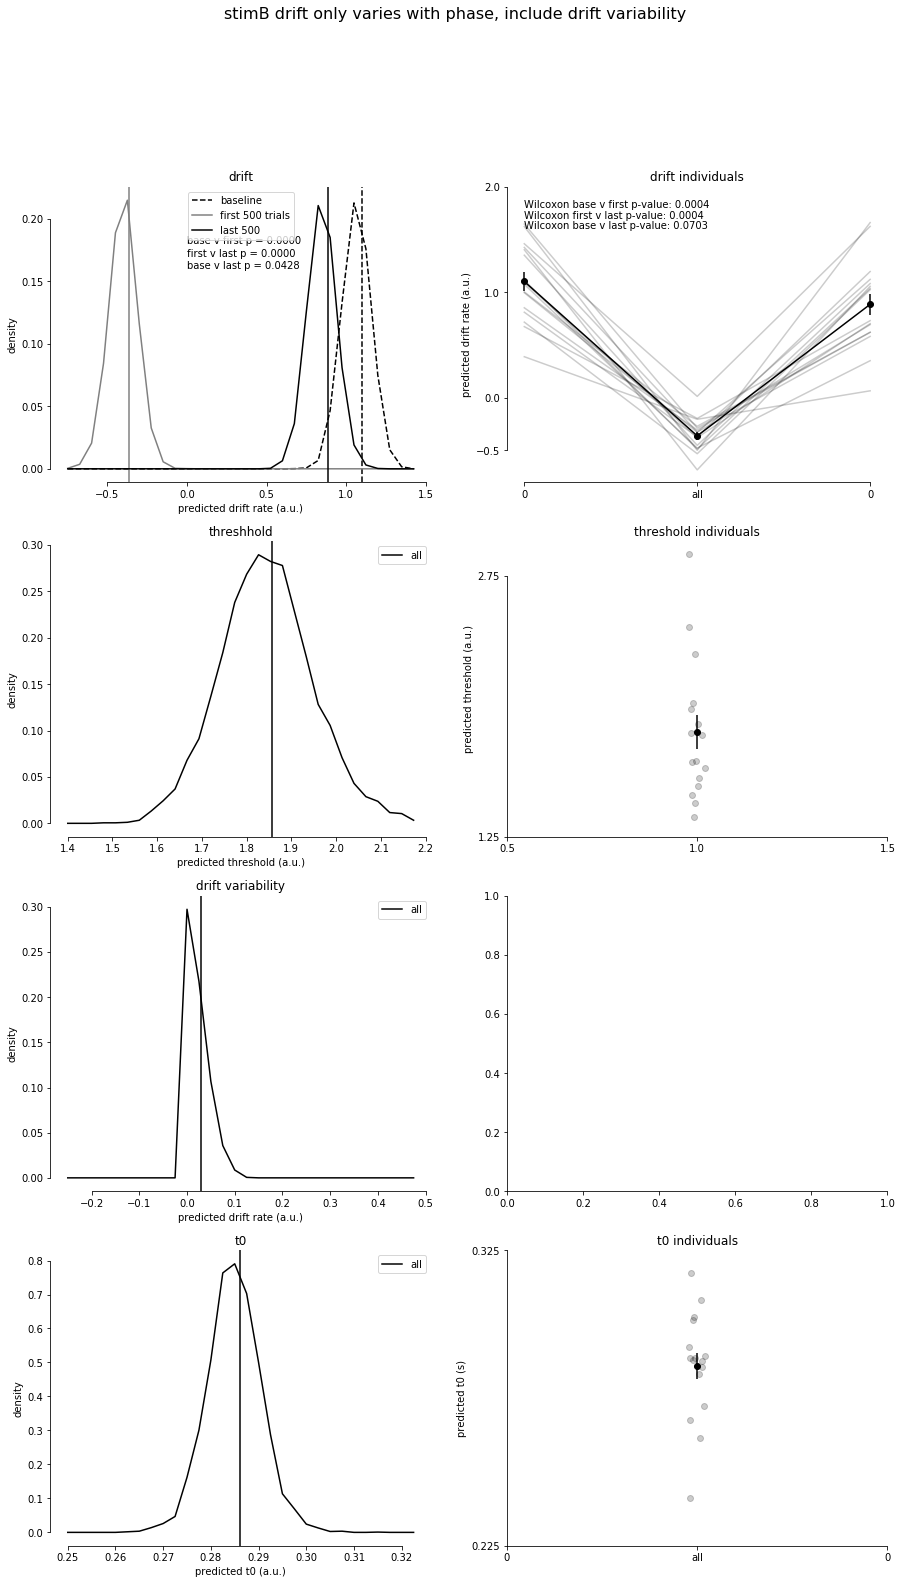

In [530]:
# drift only varies with phase, include drift variability

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = stimB_drift_only_driftvar
data_stats = stimB_drift_only_driftvar_stats


# drifts average
range_ = (-0.75, 1.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.15, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.14, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.13, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.4, 2.2)
n_bins = 30
alpha = 1
normed = True

x0 = data['a']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[1,0].axvline(np.median(x0), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0.5,1,1.5])
ax[0,1].set_xticklabels([0,'all',0])
ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 0.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability')


# t0 average
range_ = (0.25, 0.325)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('stimB drift only varies with phase, include drift variability', fontsize = 16)
sns.despine(trim=True)
fig.savefig('stimB_baseline_first_and_last500_drift_only_include_driftvar_hddm_fits.pdf')
fig.show()

#### transp plots

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

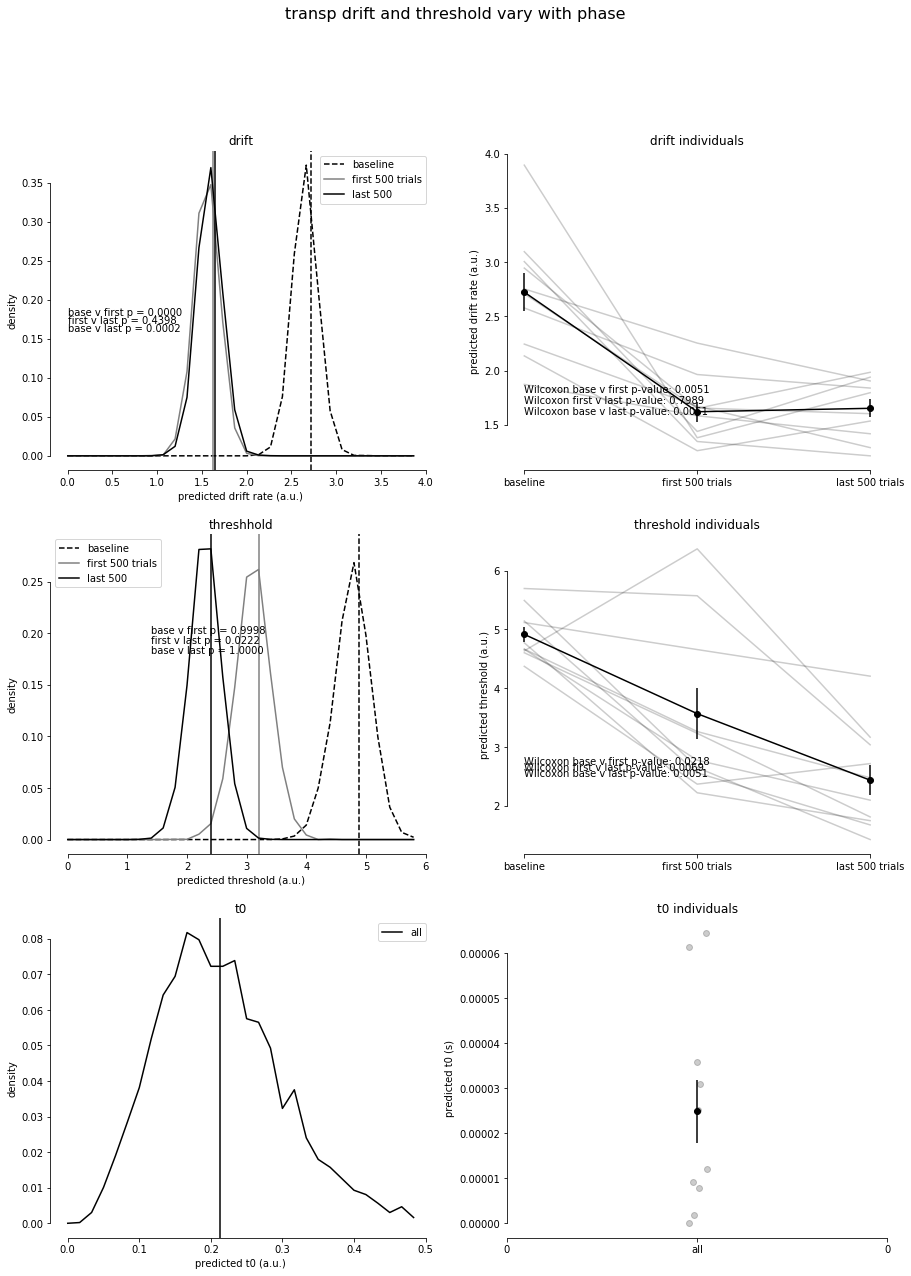

In [625]:
# drift and threshold vary with phase

fig, ax = plt.subplots(3,2, figsize = (15,20))

data = transp_drift_thresh
data_stats = transp_drift_thresh_stats


# drifts average
range_ = (0, 4)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
# ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (0, 6)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshhold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[1,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')

# t0 average
range_ = (0, 0.5)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels([0,'all',0])
# ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold vary with phase',fontsize = 16)
sns.despine(trim=True)
# fig.savefig('stimB_baseline_first_and_last500_drift_thresh_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

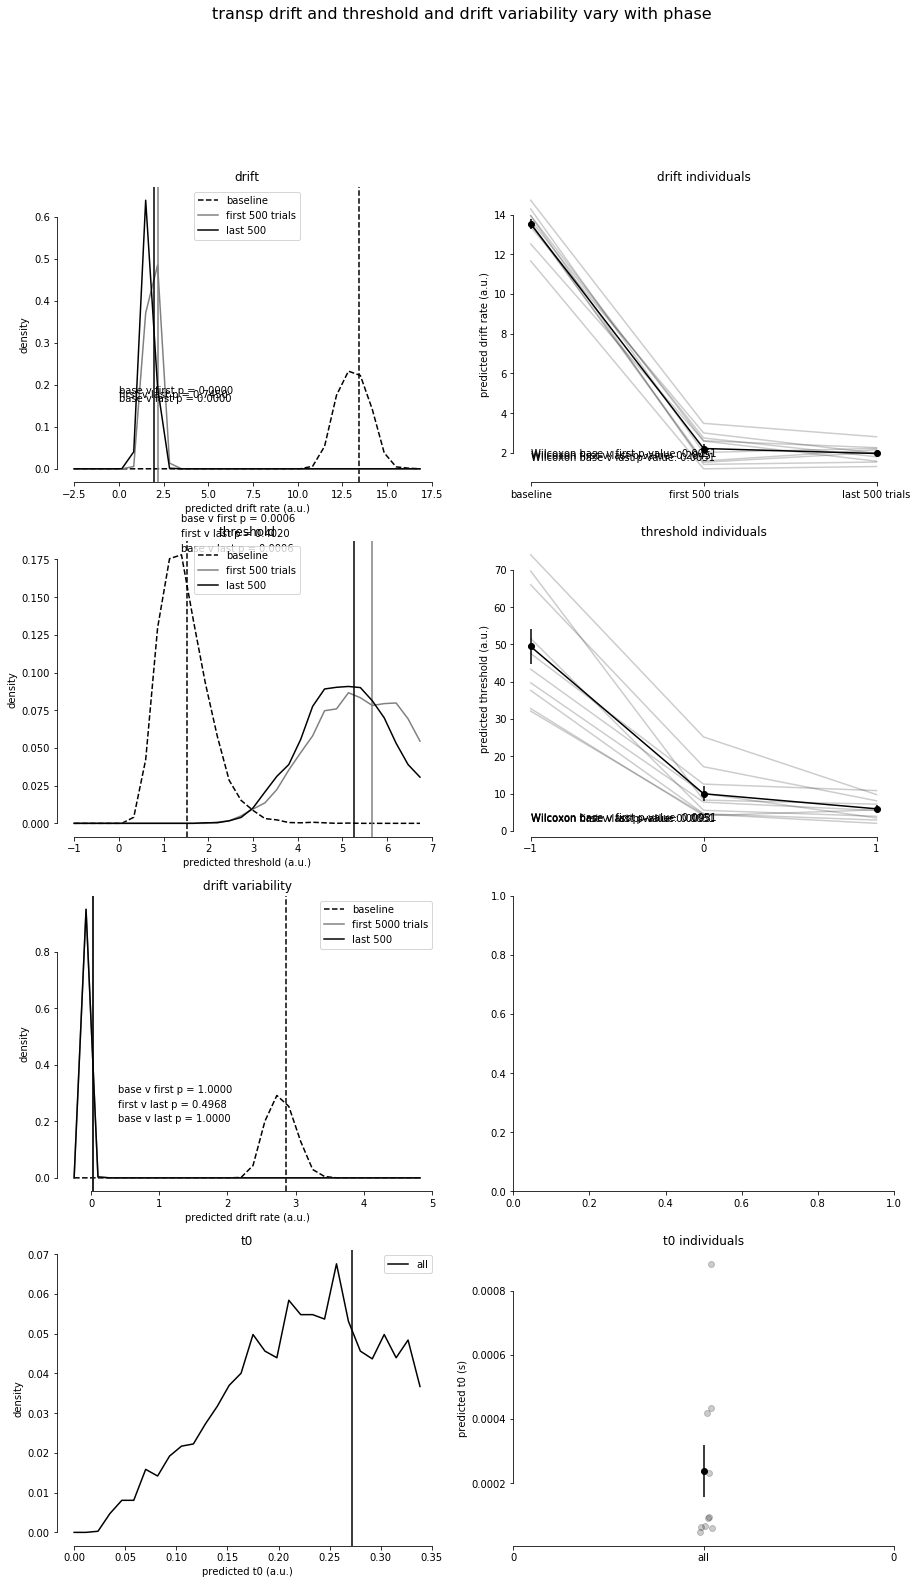

In [630]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = transp_all
data_stats = transp_all_stats


# drifts average
range_ = (-2.5, 17.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
# ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (-1, 7)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.25, 5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.4, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.4, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.4, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')



# t0 average
range_ = (0, 0.35)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
# ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('transp_baseline_first_and_last500_drift_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

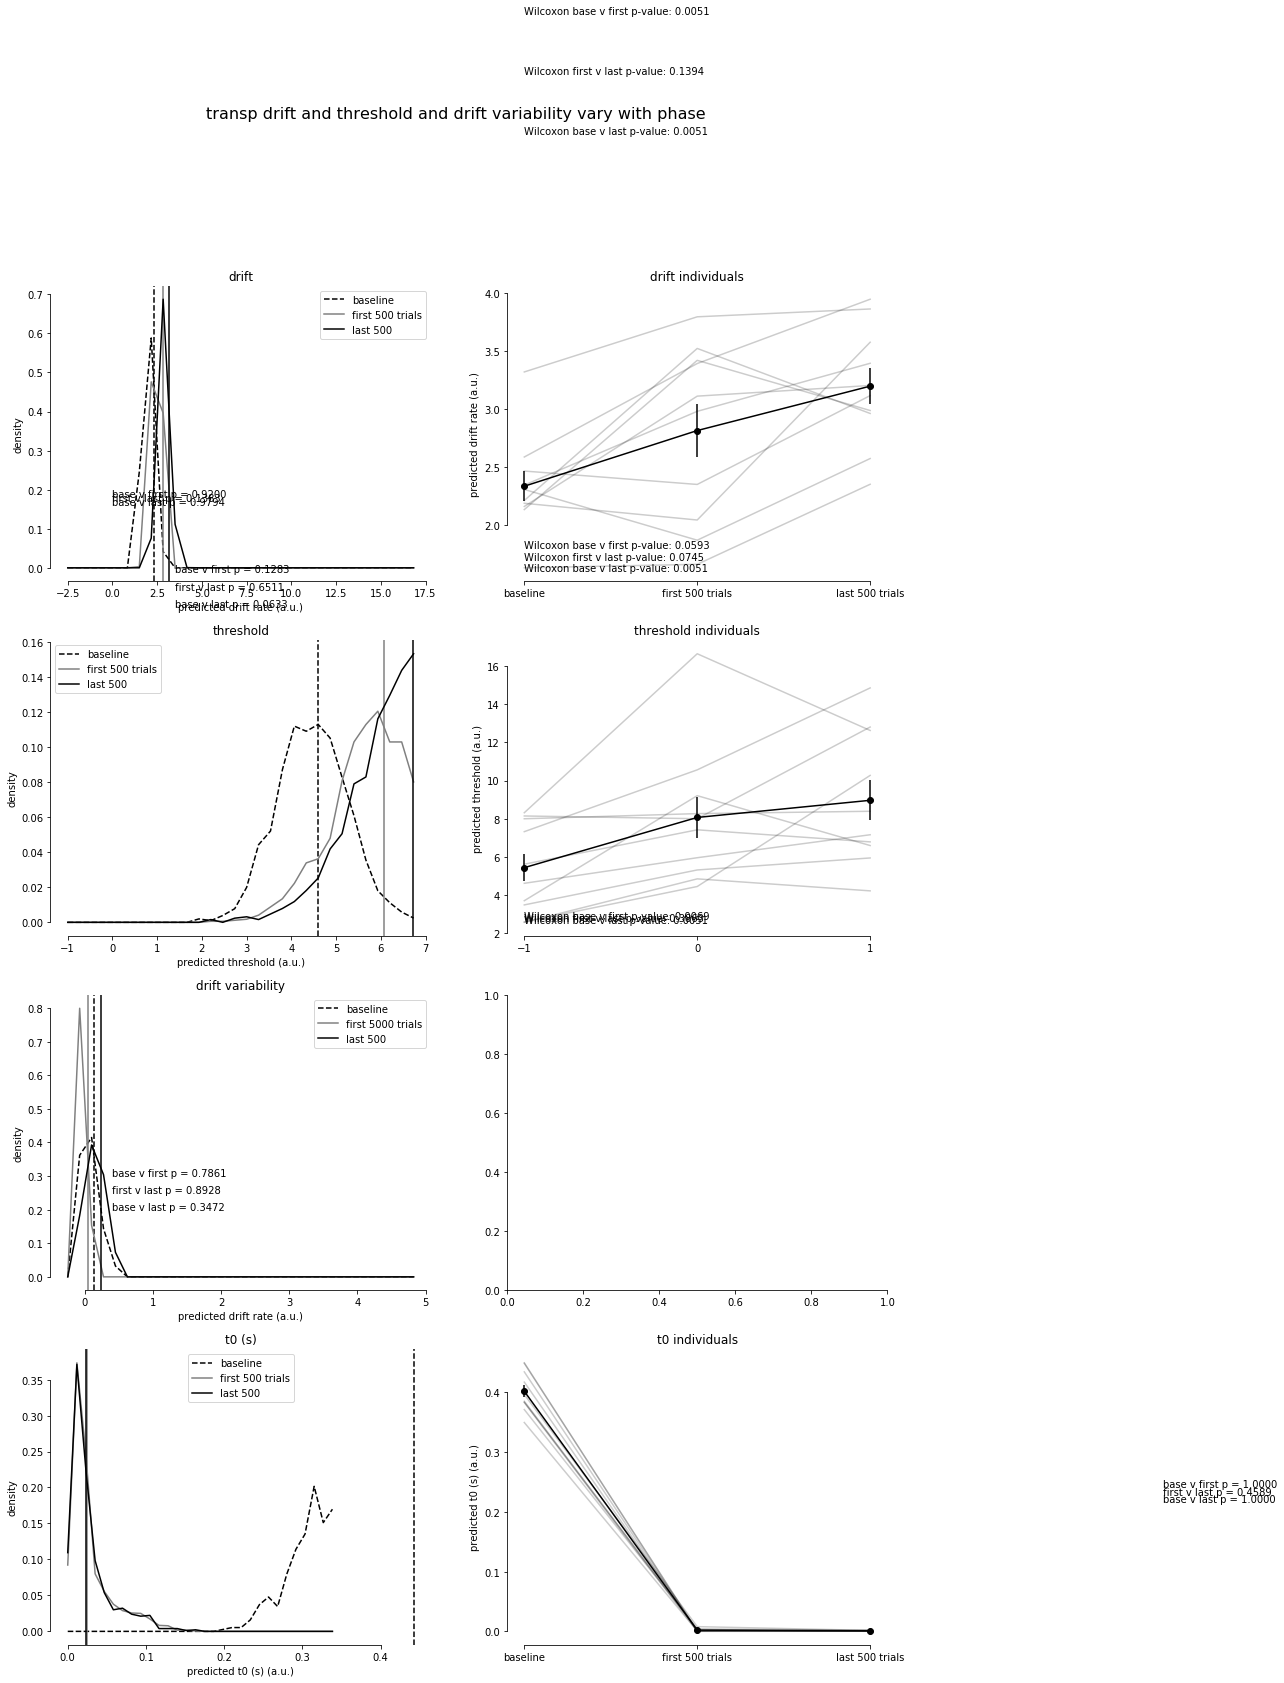

In [595]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = transp_all_depend
data_stats = transp_all_depend_stats


# drifts average
range_ = (-2.5, 17.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
# ax[0,1].set_yticks([-0.5,0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 1.8, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 1.7, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 1.6, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (-1, 7)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(1.4, 0.18, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 2.5, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.25, 5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.4, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.4, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.4, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')



# t0 average
range_ = (0, 0.35)
n_bins = 30
alpha = 1
normed = True

x_1 = data['t(-1)']
x0 = data['t(0)']
x1 = data['t(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff > 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[3,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[3,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[3,0].axvline(np.median(x1), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (s) (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[3,0].text(1.4, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[3,0].text(1.4, 0.19, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[3,0].text(1.4, 0.18, s)
ax[3,0].legend()
ax[3,0].set_title('t0 (s)')

# t0 individuals
stats = data_stats
cond__1 = 't_subj(-1)'
cond_0 = 't_subj(0)'
cond_1 = 't_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2)
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([-1,0,1])
ax[3,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[3,1].set_ylabel('predicted t0 (s) (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[3,1].text(-1, 2.7, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[3,1].text(-1, 2.6, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[3,1].text(-1, 2.5, s)
ax[3,1].set_title('t0 individuals')




# # t0 average
# range_ = (0, 0.35)
# n_bins = 30
# alpha = 1
# normed = True

# x0 = data['t']

# hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
# ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
# ax[3,0].axvline(np.median(x0), color = 'black')

# ax[3,0].set_ylabel('density')
# ax[3,0].set_xlabel('predicted t0 (a.u.)')
# ax[3,0].legend()
# ax[3,0].set_title('t0')

# # t0 individuals
# stats = data_stats
# cond_0 = 't_subj'

# idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
# means_0 = np.array(stats['mean'].iloc[idx])

# x = np.array(np.random.uniform(0.975,1.025,len(idx)))
# y = np.array(means_0)

# ymean = [np.mean(means_0)]
# ysem = [np.std(means_0)/math.sqrt(len(idx))]
# xidx = [1]

# ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
# ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
# ax[3,1].set_xticks([0.5,1,1.5])
# ax[3,1].set_xticklabels([0,'all',0])
# # ax[3,1].set_yticks([0.225,.325])
# ax[3,1].set_ylabel('predicted t0 (s)')
# ax[3,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
# fig.savefig('transp_baseline_first_and_last500_drift_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

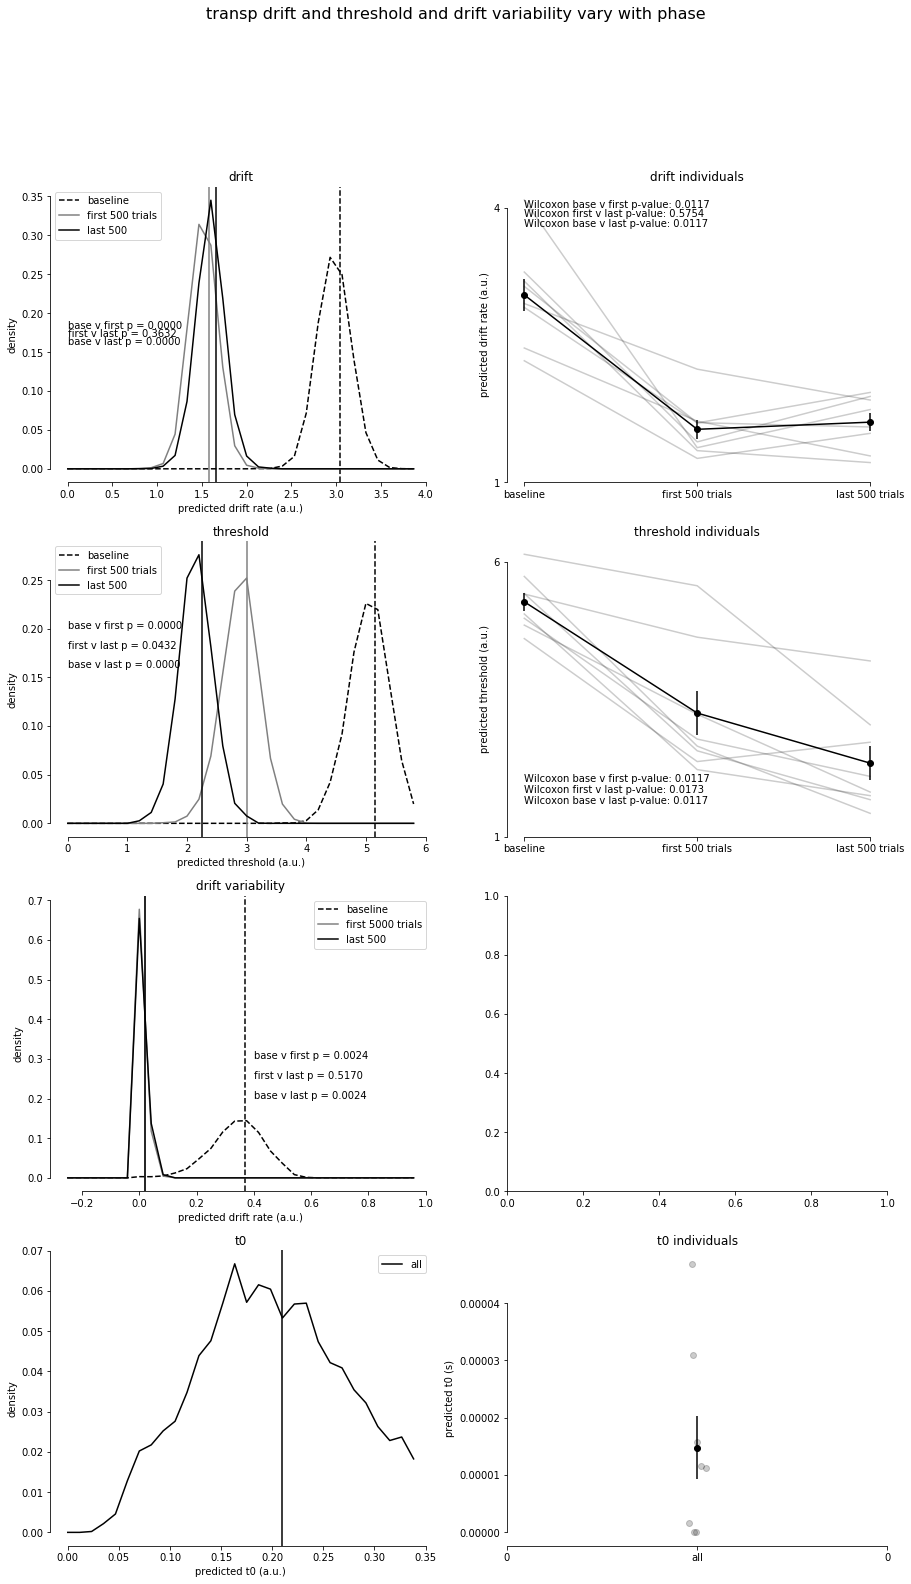

In [695]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = transp_drift_thresh_and_driftvar
data_stats = transp_drift_thresh_and_driftvar_stats


# drifts average
range_ = (0, 4)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0, 0.18, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0, 0.17, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0, 0.16, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([1,4])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 4, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 3.9, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 3.8, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (0, 6)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(0, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(0, 0.18, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(0, 0.16, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[1,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1,6])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 1.8, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 1.6, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.25, 1)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.4, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.4, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.4, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')


# t0 average
range_ = (0, 0.35)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
# ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('transp_baseline_first_and_last500_drift_thresh_and_driftvar_poutlier0005_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

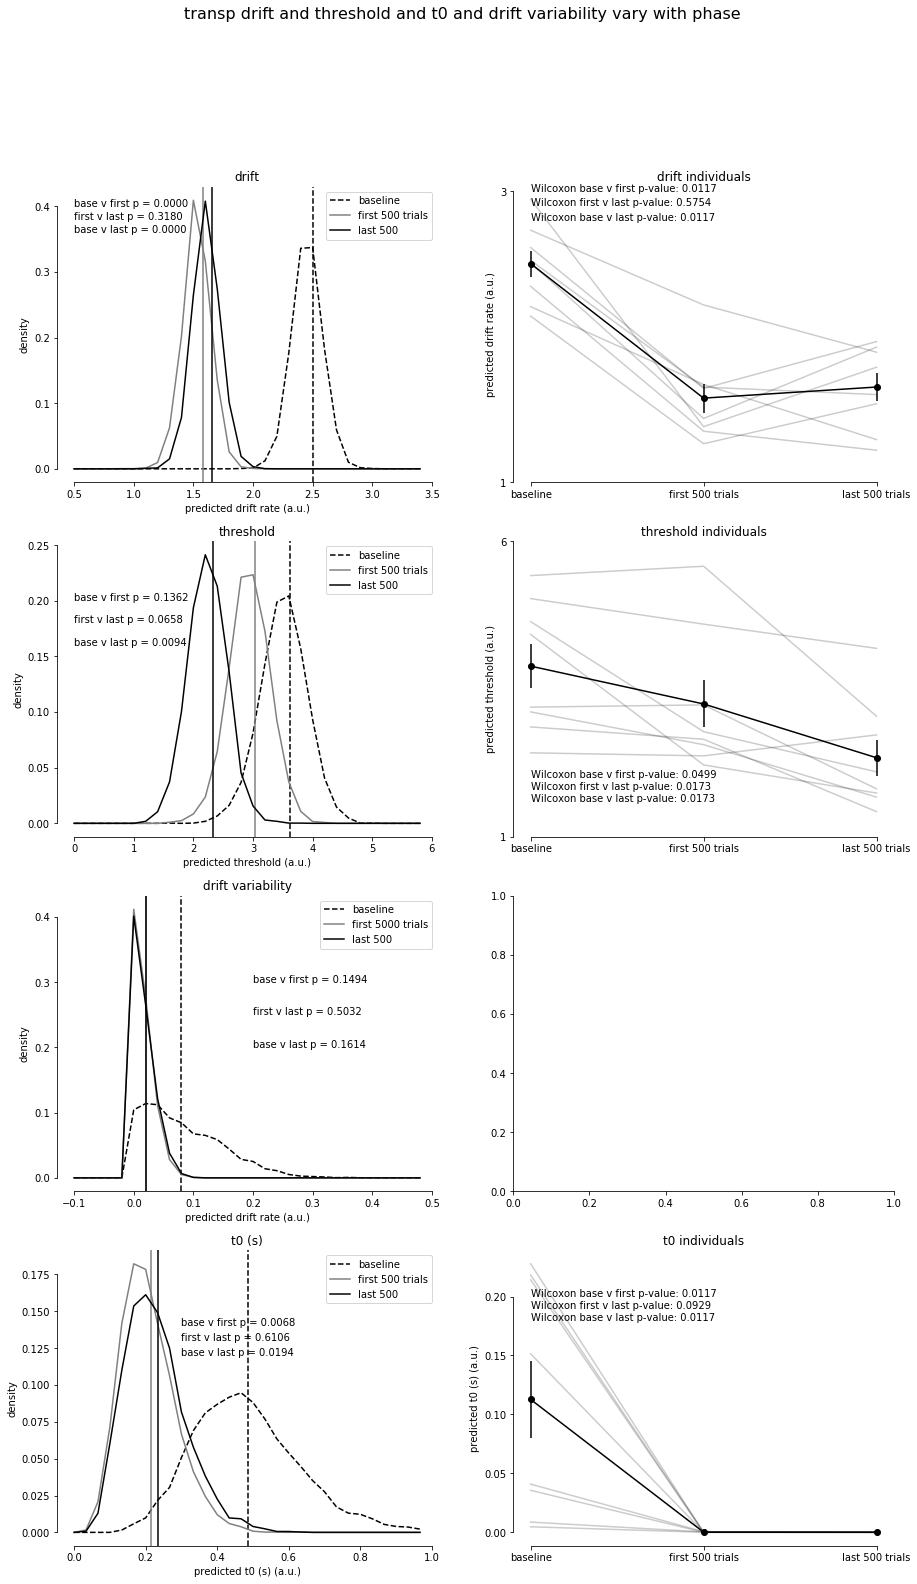

In [699]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = transp_drift_thresh_t0_and_driftvar
data_stats = transp_drift_thresh_t0_and_driftvar_stats


# drifts average
range_ = (0.5, 3.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0.5, 0.4, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0.5, 0.38, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0.5, 0.36, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([1,3])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 3, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 2.9, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 2.8, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (0, 6)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(0, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(0, 0.18, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(0, 0.16, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[1,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1,6])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 1.8, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 1.6, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.1, 0.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.2, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.2, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.2, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')

# t0 average
range_ = (0, 1)
n_bins = 30
alpha = 1
normed = True

x_1 = data['t(-1)']
x0 = data['t(0)']
x1 = data['t(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[3,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[3,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[3,0].axvline(np.median(x1), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (s) (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[3,0].text(0.3, 0.14, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[3,0].text(0.3, 0.13, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[3,0].text(0.3, 0.12, s)
ax[3,0].legend()
ax[3,0].set_title('t0 (s)')

# t0 individuals
stats = data_stats
cond__1 = 't_subj(-1)'
cond_0 = 't_subj(0)'
cond_1 = 't_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2)
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([-1,0,1])
ax[3,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[3,1].set_ylabel('predicted t0 (s) (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[3,1].text(-1, 0.2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[3,1].text(-1, 0.19, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[3,1].text(-1, 0.18, s)
ax[3,1].set_title('t0 individuals')


# # t0 average
# range_ = (0, 0.35)
# n_bins = 30
# alpha = 1
# normed = True

# x0 = data['t']

# hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
# ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
# ax[3,0].axvline(np.median(x0), color = 'black')

# ax[3,0].set_ylabel('density')
# ax[3,0].set_xlabel('predicted t0 (a.u.)')
# ax[3,0].legend()
# ax[3,0].set_title('t0')

# # t0 individuals
# stats = data_stats
# cond_0 = 't_subj'

# idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
# means_0 = np.array(stats['mean'].iloc[idx])

# x = np.array(np.random.uniform(0.975,1.025,len(idx)))
# y = np.array(means_0)

# ymean = [np.mean(means_0)]
# ysem = [np.std(means_0)/math.sqrt(len(idx))]
# xidx = [1]

# ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
# ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
# ax[3,1].set_xticks([0.5,1,1.5])
# ax[3,1].set_xticklabels([0,'all',0])
# # ax[3,1].set_yticks([0.225,.325])
# ax[3,1].set_ylabel('predicted t0 (s)')
# ax[3,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold and t0 and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
fig.savefig('transp_baseline_first_and_last500_drift_thresh_t0_and_driftvar_poutlier0005_hddm_fits.pdf')
fig.show()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

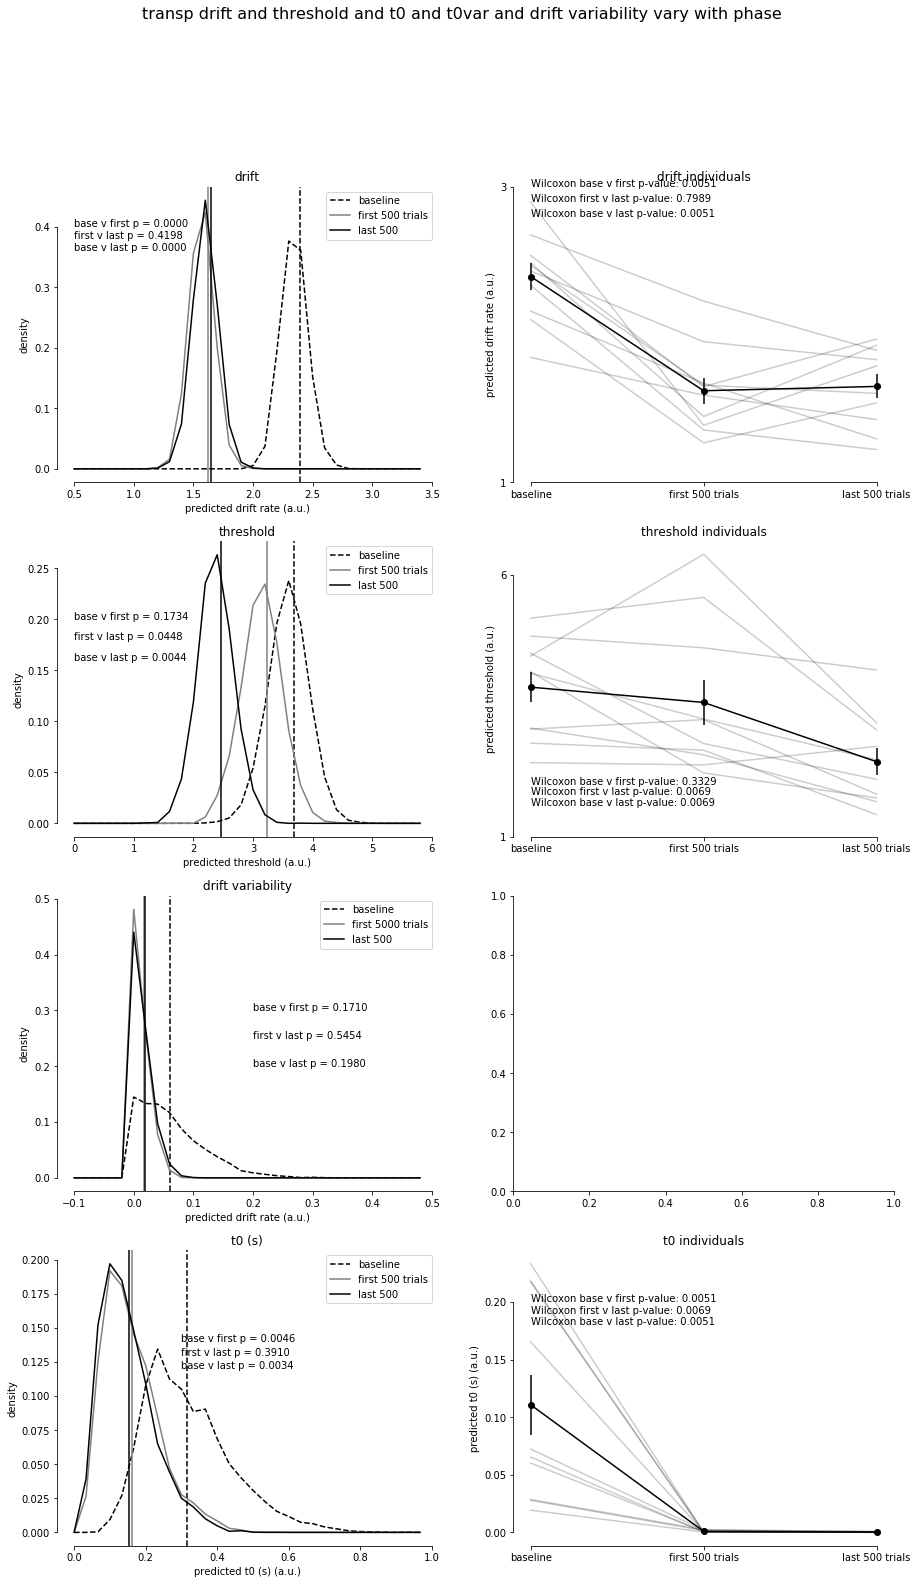

In [691]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = transp_drift_thresh_t0_t0var_and_driftvar
data_stats = transp_drift_thresh_t0_t0var_and_driftvar_stats


# drifts average
range_ = (0.5, 3.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0.5, 0.4, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0.5, 0.38, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0.5, 0.36, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([1,3])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 3, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 2.9, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 2.8, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (0, 6)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(0, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(0, 0.18, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(0, 0.16, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[1,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1,6])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 1.8, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 1.6, s)
ax[1,1].set_title('threshold individuals')



# drift variability average
range_ = (-0.1, 0.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['sv(-1)']
x0 = data['sv(0)']
x1 = data['sv(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.2, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.2, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.2, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('drift variability')

# t0 average
range_ = (0, 1)
n_bins = 30
alpha = 1
normed = True

x_1 = data['t(-1)']
x0 = data['t(0)']
x1 = data['t(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[3,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[3,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[3,0].axvline(np.median(x1), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (s) (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[3,0].text(0.3, 0.14, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[3,0].text(0.3, 0.13, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[3,0].text(0.3, 0.12, s)
ax[3,0].legend()
ax[3,0].set_title('t0 (s)')

# t0 individuals
stats = data_stats
cond__1 = 't_subj(-1)'
cond_0 = 't_subj(0)'
cond_1 = 't_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2)
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([-1,0,1])
ax[3,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[3,1].set_ylabel('predicted t0 (s) (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[3,1].text(-1, 0.2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[3,1].text(-1, 0.19, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[3,1].text(-1, 0.18, s)
ax[3,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold and t0 and t0var and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
# fig.savefig('transp_baseline_first_and_last500_drift_thresh_t0_and_driftvar_poutlier0005_hddm_fits.pdf')
fig.show()

#### 5 bins during learning

In [380]:
# load data
ddm_data_reg_alltrials_5bins = hddm.load_csv('./_data/csv/results_AK_AL_alltrials_5bins.csv')

In [385]:
# drift and thresh depend on phase

m_reg_by_phase_5bins_drift_thresh = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'v': ['phase'], 'a': ['phase']})
m_reg_by_phase_5bins_drift_thresh.find_starting_values()
m_reg_by_phase_5bins_drift_thresh.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 21460.6 sec

In [387]:
# thresh only depends on phase

m_reg_by_phase_5bins_thresh = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'a': ['phase']})
m_reg_by_phase_5bins_thresh.find_starting_values()
m_reg_by_phase_5bins_thresh.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 22623.7 sec

In [386]:
# drift only depends on phase

m_reg_by_phase_5bins_drift = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'v': ['phase']})
m_reg_by_phase_5bins_drift.find_starting_values()
m_reg_by_phase_5bins_drift.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 22644.0 sec

In [381]:
# drift, thresh and drift variability depend on phase

m_reg_by_phase_5bins_drift_thresh_and_driftvar = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase']}, include={'sv'})
m_reg_by_phase_5bins_drift_thresh_and_driftvar.find_starting_values()
m_reg_by_phase_5bins_drift_thresh_and_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 33946.3 sec

In [388]:
# thresh and drift variability depend on phase

m_reg_by_phase_5bins_thresh_and_driftvar = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'a': ['phase'], 'sv': ['phase']}, include={'sv'})
m_reg_by_phase_5bins_thresh_and_driftvar.find_starting_values()
m_reg_by_phase_5bins_thresh_and_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 36315.4 sec

In [382]:
# drift and drift variability depend on phase

m_reg_by_phase_5bins_drift_and_driftvar = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'v': ['phase'], 'sv': ['phase']}, include={'sv'})
m_reg_by_phase_5bins_drift_and_driftvar.find_starting_values()
m_reg_by_phase_5bins_drift_and_driftvar.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 35867.5 sec

In [390]:
# drift and thresh depend on phase, drift variability included

m_reg_by_phase_5bins_drift_thresh_driftvar = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'v': ['phase'], 'a': ['phase']}, include={'sv'})
m_reg_by_phase_5bins_drift_thresh_driftvar.find_starting_values()
m_reg_by_phase_5bins_drift_thresh_driftvar.sample(10000, burn=5000)

ZeroProbability: Stochastic wfpt(0.8).AK1's value is outside its support,
 or it forbids its parents' current values.

In [ ]:
# thresh only depends on phase, drift variability included

m_reg_by_phase_5bins_thresh_driftvar = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'a': ['phase']}, include={'sv'})
m_reg_by_phase_5bins_thresh_driftvar.find_starting_values()
m_reg_by_phase_5bins_thresh_driftvar.sample(10000, burn=5000)

In [ ]:
# drift only depends on phase, drift variability included

m_reg_by_phase_5bins_drift_driftvar = hddm.HDDM(ddm_data_reg_alltrials_5bins, depends_on = {'v': ['phase']}, include={'sv'})
m_reg_by_phase_5bins_drift_driftvar.find_starting_values()
m_reg_by_phase_5bins_drift_driftvar.sample(10000, burn=5000)

In [392]:
# get model info and name

drift_thresh_5bins = m_reg_by_phase_5bins_drift_thresh.get_group_traces()
thresh_only_5bins = m_reg_by_phase_5bins_thresh.get_group_traces()
drift_only_5bins = m_reg_by_phase_5bins_drift.get_group_traces()

# drift_thresh_driftvar_5bins = m_reg_by_phase_5bins_drift_thresh_driftvar.get_group_traces()
# thresh_only_driftvar_5bins = m_reg_by_phase_5bins_thresh_driftvar.get_group_traces()
# drift_only_driftvar_5bins = m_reg_by_phase_5bins_drift_driftvar.get_group_traces()

drift_thresh_and_driftvar_5bins = m_reg_by_phase_5bins_drift_thresh_and_driftvar.get_group_traces()
thresh_and_driftvar_5bins = m_reg_by_phase_5bins_thresh_and_driftvar.get_group_traces()
drift_and_driftvar_5bins = m_reg_by_phase_5bins_drift_and_driftvar.get_group_traces()

#stats

drift_thresh_5bins_stats = m_reg_by_phase_5bins_drift_thresh.gen_stats()
thresh_only_5bins_stats = m_reg_by_phase_5bins_thresh.gen_stats()
drift_only_5bins_stats = m_reg_by_phase_5bins_drift.gen_stats()

# drift_thresh_driftvar_5bins_stats = m_reg_by_phase_5bins_drift_thresh_driftvar.gen_stats()
# thresh_only_driftvar_5bins_stats = m_reg_by_phase_5bins_thresh_driftvar.gen_stats()
# drift_only_driftvar_5bins_stats = m_reg_by_phase_5bins_drift_driftvar.gen_stats()

drift_thresh_and_driftvar_5bins_stats = m_reg_by_phase_5bins_drift_thresh_and_driftvar.gen_stats()
thresh_only_and_driftvar_5bins_stats = m_reg_by_phase_5bins_thresh_and_driftvar.gen_stats()
drift_only_and_driftvar_5bins_stats = m_reg_by_phase_5bins_drift_and_driftvar.gen_stats()

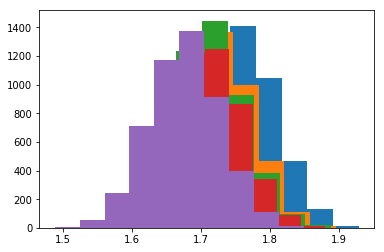

In [447]:
x02 = drift_thresh_5bins['a(0.2)'].mean()
x04 = drift_thresh_5bins['a(0.4)'].mean()
x06 = drift_thresh_5bins['a(0.6)'].mean()
x08 = drift_thresh_5bins['a(0.8)'].mean()
x10 = drift_thresh_5bins['a(1.0)'].mean()

x02 = drift_thresh_5bins['a(0.2)']
x04 = drift_thresh_5bins['a(0.4)']
x06 = drift_thresh_5bins['a(0.6)']
x08 = drift_thresh_5bins['a(0.8)']
x10 = drift_thresh_5bins['a(1.0)']

x_s = [x02, x04, x06, x08, x10]
# x1 = drift_thresh_5bins['a(0.8)']

# diff = np.subtract(x1, x0)
# pval = np.sum(diff > 0) / len(diff)
for i in x_s:
    plt.hist(i)

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Passing `normed=

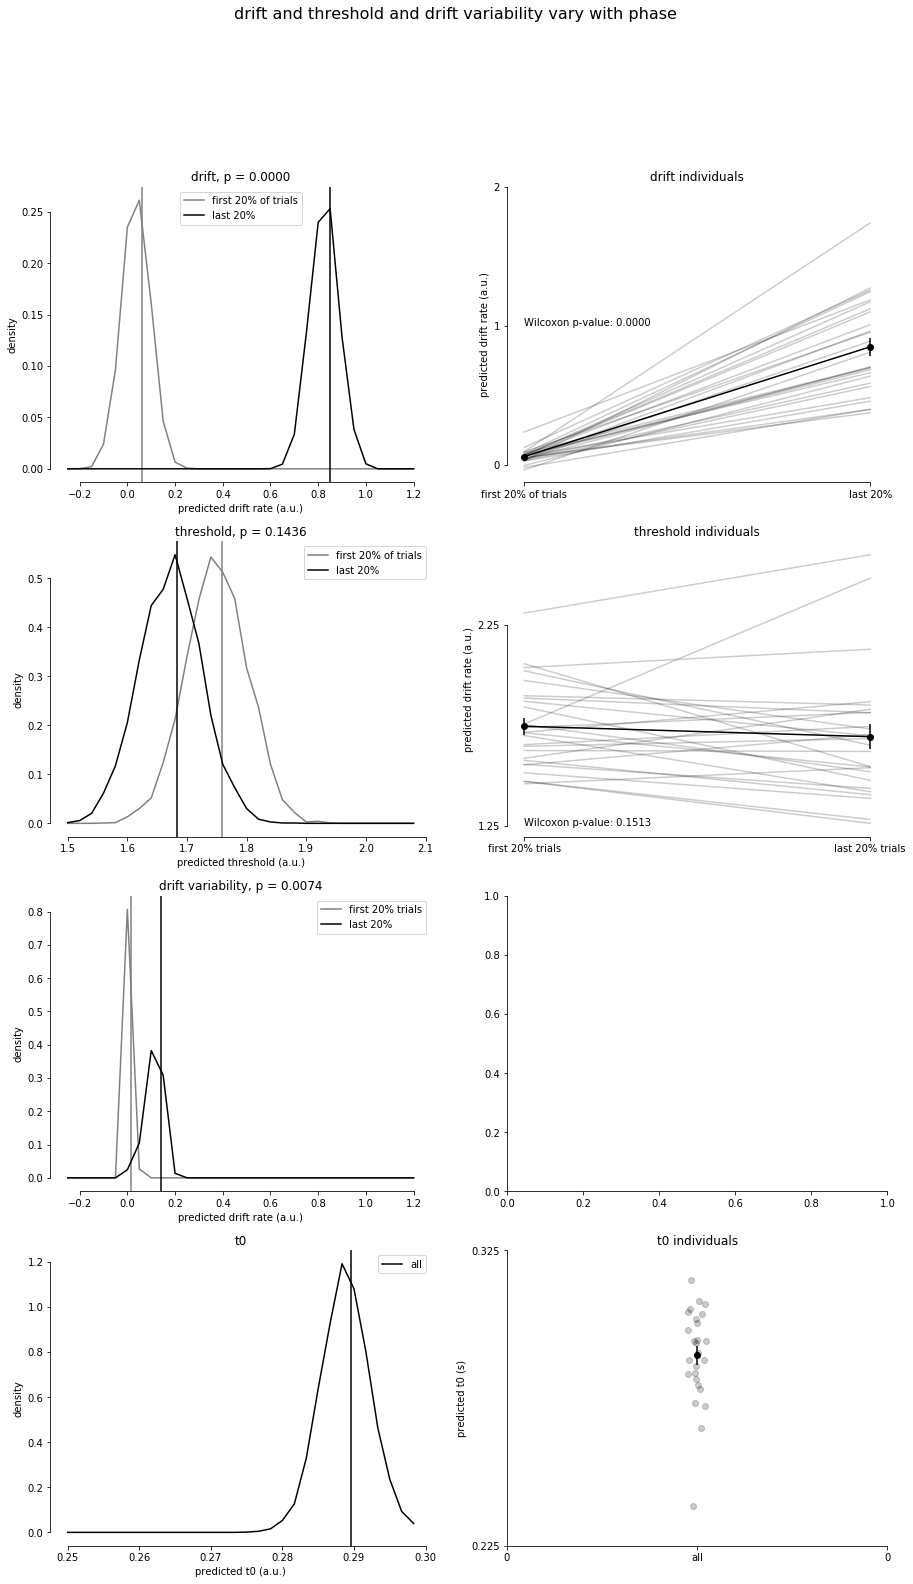

In [434]:
# drift and threshold and drift variability vary with phase


fig, ax = plt.subplots(4,2, figsize = (15,25))

data = drift_thresh_and_driftvar_5bins
data_stats = drift_thresh_and_driftvar_5bins_stats

# drifts average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['v(0.2)']
x1 = data['v(1.0)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 20% of trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 20%')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)

# drifts individuals
stats = data_stats
cond_0 = 'v_subj(0.2)'
cond_1 = 'v_subj(1.0)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([0,1])
ax[0,1].set_xticklabels(['first 20% of trials', 'last 20%'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([0,1,2])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(0, 1, s)
# s = 'n = %d' %len(idx)
# ax[0,1].text(0,-0.7, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (1.5, 2.1)
n_bins = 30
alpha = 1
normed = True

x0 = data['a(0.2)']
x1 = data['a(1.0)']

diff = np.subtract(x1, x0)
pval = np.sum(diff > 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 20% of trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 20%')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)

# thresholds individuals
stats = data_stats
cond_0 = 'a_subj(0.2)'
cond_1 = 'a_subj(1.0)'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_0, means_1])

ymean = [np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(['first 20% trials', 'last 20% trials'])
ax[1,1].set_yticks([1.25,2.25])
ax[1,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(0, 1.25, s)
ax[1,1].set_title('threshold individuals')

# drift variability average
range_ = (-0.25, 1.25)
n_bins = 30
alpha = 1
normed = True

x0 = data['sv(0.2)']
x1 = data['sv(1.0)']

diff = np.subtract(x1, x0)
pval = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 20% trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 20%')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('drift variability, p = %.4f' %pval)

# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = data['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[3,0].axvline(np.median(x0), color = 'black')

ax[3,0].set_ylabel('density')
ax[3,0].set_xlabel('predicted t0 (a.u.)')
ax[3,0].legend()
ax[3,0].set_title('t0')

# t0 individuals
stats = data_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([0.5,1,1.5])
ax[3,1].set_xticklabels([0,'all',0])
ax[3,1].set_yticks([0.225,.325])
ax[3,1].set_ylabel('predicted t0 (s)')
ax[3,1].set_title('t0 individuals')


fig.suptitle('drift and threshold and drift variability vary with phase',fontsize = 16)
sns.despine(trim=True)
fig.savefig('AK_AL_regstim_5bins_drift_thresh_and_driftvar_hddm_fits.pdf')
fig.show()

In [408]:
# save model group traces & stats

drift_thresh_5bins.to_pickle('_data/hddmmodels/drift_thresh_5bins')
thresh_only_5bins.to_pickle('_data/hddmmodels/thresh_only_5bins')
drift_only_5bins.to_pickle('_data/hddmmodels/drift_only_5bins')

drift_thresh_and_driftvar_5bins.to_pickle('_data/hddmmodels/drift_thresh_and_driftvar_5bins')
thresh_and_driftvar_5bins.to_pickle('_data/hddmmodels/thresh_and_driftvar_5bins')
drift_and_driftvar_5bins.to_pickle('_data/hddmmodels/drift_and_driftvar_5bins')

# stats
drift_thresh_5bins_stats.to_pickle('_data/hddmmodels/drift_thresh_5bins_stats')
thresh_only_5bins_stats.to_pickle('_data/hddmmodels/thresh_only_5bins_stats')
drift_only_5bins_stats.to_pickle('_data/hddmmodels/drift_only_5bins_stats')

drift_thresh_and_driftvar_5bins_stats.to_pickle('_data/hddmmodels/drift_thresh_and_driftvar_5bins_stats')
thresh_only_and_driftvar_5bins_stats.to_pickle('_data/hddmmodels/thresh_only_and_driftvar_5bins_stats')
drift_only_and_driftvar_5bins_stats.to_pickle('_data/hddmmodels/drift_only_and_driftvar_5bins_stats')

#### 10 bins during learning

In [ ]:
# load data
ddm_data_reg_alltrials_10bins = hddm.load_csv('./_data/csv/results_AK_AL_alltrials_10bins.csv')

In [248]:
# # drift and thresh depend on phase

# m_reg_by_phase_10bins_drift_thresh = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'v': ['phase'], 'a': ['phase']})
# m_reg_by_phase_10bins_drift_thresh.find_starting_values()
# m_reg_by_phase_10bins_drift_thresh.sample(10000, burn=5000)

 [-----------------100%-----------------] 10001 of 10000 complete in 21347.0 sec

In [379]:
# # thresh only depends on phase

# m_reg_by_phase_10bins_thresh = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'a': ['phase']})
# m_reg_by_phase_10bins_thresh.find_starting_values()
# m_reg_by_phase_10bins_thresh.sample(10000, burn=5000)

In [ ]:
# # drift only depends on phase

# m_reg_by_phase_10bins_drift = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'v': ['phase']})
# m_reg_by_phase_10bins_drift.find_starting_values()
# m_reg_by_phase_10bins_drift.sample(10000, burn=5000)

In [ ]:
# # drift, thresh and drift variability depend on phase

# m_reg_by_phase_10bins_drift_thresh_and_driftvar = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase']}, include={'sv'})
# m_reg_by_phase_10bins_drift_thresh_and_driftvar.find_starting_values()
# m_reg_by_phase_10bins_drift_thresh_and_driftvar.sample(10000, burn=5000)

In [ ]:
# # thresh and drift variability depend on phase

# m_reg_by_phase_10bins_thresh_and_driftvar = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'a': ['phase'], 'sv': ['phase']}, include={'sv'})
# m_reg_by_phase_10bins_thresh_and_driftvar.find_starting_values()
# m_reg_by_phase_10bins_thresh_and_driftvar.sample(10000, burn=5000)

In [ ]:
# # drift and drift variability depend on phase

# m_reg_by_phase_10bins_drift_and_driftvar = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'v': ['phase'], 'sv': ['phase']}, include={'sv'})
# m_reg_by_phase_10bins_drift_and_driftvar.find_starting_values()
# m_reg_by_phase_10bins_drift_and_driftvar.sample(10000, burn=5000)

In [ ]:
# # drift and thresh depend on phase, drift variability included

# m_reg_by_phase_10bins_drift_thresh_driftvar = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'v': ['phase'], 'a': ['phase']}, include={'sv'})
# m_reg_by_phase_10bins_drift_thresh_driftvar.find_starting_values()
# m_reg_by_phase_10bins_drift_thresh_driftvar.sample(10000, burn=5000)

In [ ]:
# # thresh only depends on phase, drift variability included

# m_reg_by_phase_10bins_thresh_driftvar = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'a': ['phase']}, include={'sv'})
# m_reg_by_phase_10bins_thresh_driftvar.find_starting_values()
# m_reg_by_phase_10bins_thresh_driftvar.sample(10000, burn=5000)

In [ ]:
# # drift only depends on phase, drift variability included

# m_reg_by_phase_10bins_drift_driftvar = hddm.HDDM(ddm_data_reg_alltrials_10bins, depends_on = {'v': ['phase']}, include={'sv'})
# m_reg_by_phase_10bins_drift_driftvar.find_starting_values()
# m_reg_by_phase_10bins_drift_driftvar.sample(10000, burn=5000)

In [250]:
# get model info and name

drift_thresh_10bins = m_reg_by_phase_10bins_drift_thresh.get_group_traces()
# thresh_only_10bins = m_reg_by_phase_10bins_thresh.get_group_traces()
# drift_only_10bins = m_reg_by_phase_10bins_drift.get_group_traces()

# drift_thresh_driftvar_10bins = m_reg_by_phase_10bins_drift_thresh_driftvar.get_group_traces()
# thresh_only_driftvar_10bins = m_reg_by_phase_10bins_thresh_driftvar.get_group_traces()
# drift_only_driftvar_10bins = m_reg_by_phase_10bins_drift_driftvar.get_group_traces()

# drift_thresh_and_driftvar_10bins = m_reg_by_phase_10bins_drift_thresh_and_driftvar.get_group_traces()
# thresh_and_driftvar_10bins = m_reg_by_phase_10bins_thresh_and_driftvar.get_group_traces()
# drift_and_driftvar_10bins = m_reg_by_phase_10bins_drift_and_driftvar.get_group_traces()

#stats

drift_thresh_10bins_stats = m_reg_by_phase_10bins_drift_thresh.gen_stats()
# thresh_only_10bins_stats = m_reg_by_phase_10bins_thresh.gen_stats()
# drift_only_10bins_stats = m_reg_by_phase_10bins_drift.gen_stats()

# drift_thresh_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_thresh_driftvar.gen_stats()
# thresh_only_driftvar_10bins_stats = m_reg_by_phase_10bins_thresh_driftvar.gen_stats()
# drift_only_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_driftvar.gen_stats()

# drift_thresh_and_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_thresh_and_driftvar.gen_stats()
# thresh_only_and_driftvar_10bins_stats = m_reg_by_phase_10bins_thresh_and_driftvar.gen_stats()
# drift_only_and_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_and_driftvar.gen_stats()

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:140: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Passing `norme

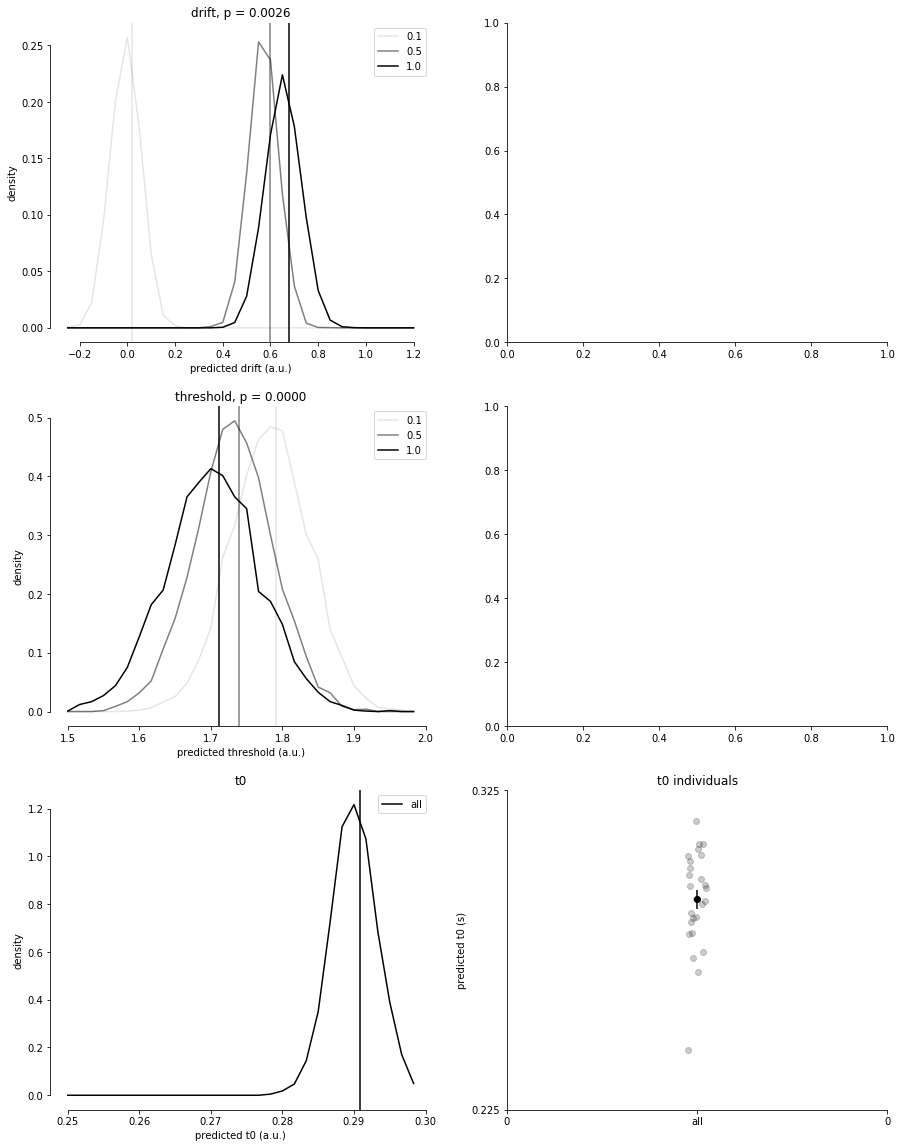

In [330]:
# fig, ax = plt.subplot(3,2, fig_size = (15,10))

a_median = [np.median(drift_thresh_10bins['a(0.1)']),np.median(drift_thresh_10bins['a(0.2)']),np.median(drift_thresh_10bins['a(0.3)']),
np.median(drift_thresh_10bins['a(0.4)']),np.median(drift_thresh_10bins['a(0.5)']),np.median(drift_thresh_10bins['a(0.6)']),
np.median(drift_thresh_10bins['a(0.7)']),np.median(drift_thresh_10bins['a(0.8)']),np.median(drift_thresh_10bins['a(0.9)']),np.median(drift_thresh_10bins['a(1.0)'])]

# a_mean = [np.mean(drift_thresh_10bins['a(0.1)']),np.mean(drift_thresh_10bins['a(0.2)']),np.mean(drift_thresh_10bins['a(0.3)']),
# np.mean(drift_thresh_10bins['a(0.4)']),np.mean(drift_thresh_10bins['a(0.5)']),np.mean(drift_thresh_10bins['a(0.6)']),
# np.mean(drift_thresh_10bins['a(0.7)']),np.mean(drift_thresh_10bins['a(0.8)']),np.mean(drift_thresh_10bins['a(0.9)']),np.mean(drift_thresh_10bins['a(1.0)'])]

# v_mean = [np.mean(drift_thresh_10bins['v(0.1)']),np.mean(drift_thresh_10bins['v(0.2)']),np.mean(drift_thresh_10bins['v(0.3)']),
# np.mean(drift_thresh_10bins['v(0.4)']),np.mean(drift_thresh_10bins['v(0.5)']),np.mean(drift_thresh_10bins['v(0.6)']),
# np.mean(drift_thresh_10bins['v(0.7)']),np.mean(drift_thresh_10bins['v(0.8)']),np.mean(drift_thresh_10bins['v(0.9)']),np.mean(drift_thresh_10bins['v(1.0)'])]



# stat = ['a(0.1)', 'a(0.2)', 'a(0.3)', 'a(0.4)', 'a(0.5)', 'a(0.6)', 'a(0.7)', 'a(0.8)', 'a(0.9)', 'a(1.0)']
# group01 = drift_thresh_10bins[stat[0]]
# group02 = drift_thresh_10bins[stat[1]]
# group03 = drift_thresh_10bins[stat[2]]
# group04 = drift_thresh_10bins[stat[3]]
# group05 = drift_thresh_10bins[stat[4]]
# group06 = drift_thresh_10bins[stat[5]]
# group07 = drift_thresh_10bins[stat[6]]
# group08 = drift_thresh_10bins[stat[7]]
# group09 = drift_thresh_10bins[stat[8]]
# group10 = drift_thresh_10bins[stat[9]]

# plt.boxplot([group01,group02,group03,group04,group05,group06,group07,group08,group09,group10], showfliers = False)
# plt.plot([1,2,3,4,5,6,7,8,9,10],a_median)

# plt.xlabel('phase (total trial bins)')
# plt.ylabel('predicted threshold (a.u.)')
# plt.xticks([1,2,3,4,5,6,7,8,9,10], ['0.1','0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
# plt.yticks([1.5, 1.75, 2.0])
# sns.despine(trim=True)
# s = 'Wilcoxon 0.1 v. 1.0 p-value: %f' %scipy.stats.wilcoxon(group01, group05)[1]
# plt.text(1.2, 1.5, s)
# # s = 'Wilcoxon first v. last p-value: %f' %scipy.stats.wilcoxon(group01, group10)[1]
# # plt.text(1.2, 1.5, s)
# # s = 'Wilcoxon base v. last p-value: %f' %scipy.stats.wilcoxon(group05, group10)[1]
# # plt.text(1.2, 1.45, s)
# plt.title('predicted thresh through learning')

fig, ax = plt.subplots(3,2, figsize = (15,20))

# drifts average
stat = ['v(0.1)', 'v(0.2)', 'v(0.3)', 'v(0.4)', 'v(0.5)', 'v(0.6)', 'v(0.7)', 'v(0.8)', 'v(0.9)', 'v(1.0)']
phase = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x01 = drift_thresh_10bins[stat[0]]
x02 = drift_thresh_10bins[stat[1]]
x03 = drift_thresh_10bins[stat[2]]
x04 = drift_thresh_10bins[stat[3]]
x05 = drift_thresh_10bins[stat[4]]
x06 = drift_thresh_10bins[stat[5]]
x07 = drift_thresh_10bins[stat[6]]

x08 = drift_thresh_10bins[stat[7]]
x09 = drift_thresh_10bins[stat[8]]
x10 = drift_thresh_10bins[stat[9]]
x_s = [x01, x02, x03, x04, x05, x06, x07, x08, x09, x10]

diff = np.subtract(x1, x10)
pval = np.sum(diff < 0) / len(diff)

range_ = (-.25, 1.25)
n_bins = 30
normed = True
    
for i in [0, 4, 9]:
    hist1, bins1 = np.histogram(x_s[i], bins = n_bins, normed = normed, range = range_)
    ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = '%.1f' %phase[i], alpha = phase[i])
    ax[0,0].axvline(np.median(x_s[i]), color = 'black', alpha = phase[i])

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift (a.u.)')
ax[0,0].legend()
ax[0,0].set_title('drift, p = %.4f' %pval)


# drifts individuals
# stats = drift_thresh_10bins_stats
# cond_01 = 'v_subj(0.1)'
# cond_05 = 'v_subj(0.5)'
# cond_10 = 'v_subj(1.0)'

# idx = [x for x,subj in enumerate(stats.index) if cond_01 in subj] 
# means_01 = np.array(stats['mean'].iloc[idx])

# idx = [x for x,subj in enumerate(stats.index) if cond_05 in subj] 
# means_05 = np.array(stats['mean'].iloc[idx])

# idx = [x for x,subj in enumerate(stats.index) if cond_10 in subj] 
# means_10 = np.array(stats['mean'].iloc[idx])

# x = np.array([np.repeat([0], len(idx)), np.repeat([0.5], len(idx)), np.repeat([1], len(idx))])
# y = np.array([means_01, means_05, means_10])

# ymean = [np.mean(means_01), np.mean(means_05), np.mean(means_10)]
# ysem = [np.std(means_01)/math.sqrt(len(idx)), np.std(means_05)/math.sqrt(len(idx)), np.std(means_10)/math.sqrt(len(idx))]
# xidx = [0,0.5,1]

# ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
# ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
# ax[0,1].set_xticks([0,1])
# ax[0,1].set_xticklabels(['first 1000 trials', 'last 1000 trials'])
# # ax[0,1].set_xlabel('trials')
# ax[0,1].set_yticks([0,1,2])
# ax[0,1].set_ylabel('predicted drift rate (a.u.)')
# s = 'Wilcoxon p-value: %.4f' %scipy.stats.wilcoxon(means_01, means_10)[1]
# ax[0,1].text(0, 1, s)
# # s = 'n = %d' %len(idx)
# # ax[0,1].text(0,-0.7, s)
# ax[0,1].set_title('drift individuals')


#thresholds average
stat = ['a(0.1)', 'a(0.2)', 'a(0.3)', 'a(0.4)', 'a(0.5)', 'a(0.6)', 'a(0.7)', 'a(0.8)', 'a(0.9)', 'a(1.0)']
phase = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x01 = drift_thresh_10bins[stat[0]]
x02 = drift_thresh_10bins[stat[1]]
x03 = drift_thresh_10bins[stat[2]]
x04 = drift_thresh_10bins[stat[3]]
x05 = drift_thresh_10bins[stat[4]]
x06 = drift_thresh_10bins[stat[5]]
x07 = drift_thresh_10bins[stat[6]]
x08 = drift_thresh_10bins[stat[7]]
x09 = drift_thresh_10bins[stat[8]]
x10 = drift_thresh_10bins[stat[9]]
x_s = [x01, x02, x03, x04, x05, x06, x07, x08, x09, x10]

diff = np.subtract(x1, x10)
pval = np.sum(diff > 0) / len(diff)

range_ = (1.5, 2)
n_bins = 30
normed = True
    
for i in [0, 4, 9]:
    hist1, bins1 = np.histogram(x_s[i], bins = n_bins, normed = normed, range = range_)
    ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = '%.1f' %phase[i], alpha = phase[i])
    ax[1,0].axvline(np.median(x_s[i]), color = 'black', alpha = phase[i])

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
ax[1,0].legend()
ax[1,0].set_title('threshold, p = %.4f' %pval)


# t0 average
range_ = (0.25, 0.3)
n_bins = 30
alpha = 1
normed = True

x0 = drift_thresh_10bins['t']

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'all')
ax[2,0].axvline(np.median(x0), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted t0 (a.u.)')
ax[2,0].legend()
ax[2,0].set_title('t0')

# t0 individuals
stats = drift_thresh_10bins_stats
cond_0 = 't_subj'

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

x = np.array(np.random.uniform(0.975,1.025,len(idx)))
y = np.array(means_0)

ymean = [np.mean(means_0)]
ysem = [np.std(means_0)/math.sqrt(len(idx))]
xidx = [1]

ax[2,1].plot(x,y, color = 'black', alpha = 0.2, marker = 'o', linestyle = ' ')
ax[2,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[2,1].set_xticks([0.5,1,1.5])
ax[2,1].set_xticklabels(['0','all','0'])
ax[2,1].set_yticks([0.225,.325])
ax[2,1].set_ylabel('predicted t0 (s)')
ax[2,1].set_title('t0 individuals')


sns.despine(trim=True)
fig.show()


In [305]:
idx = [x for x,subj in enumerate(stats.index) if cond_01 in subj] 
means_01 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_05 in subj] 
means_05 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_10 in subj] 
means_10 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([0], len(idx)), np.repeat([1], len(idx)), np.repeat([1], len(idx))])
y = np.array([means_01, means_05, means_10])

ymean = [np.mean(means_01), np.mean(means_05), np.mean(means_10)]
ysem = [np.std(means_01)/math.sqrt(len(idx)), np.std(means_05)/math.sqrt(len(idx)), np.std(means_10)/math.sqrt(len(idx))]
xidx = [0,0.5,1]

len(y[2])

19

In [327]:
list(drift_thresh_10bins_stats.index)

['a(0.1)',
 'a(0.2)',
 'a(0.3)',
 'a(0.4)',
 'a(0.5)',
 'a(0.6)',
 'a(0.7)',
 'a(0.8)',
 'a(0.9)',
 'a(1.0)',
 'a(1.1)',
 'a(1.2)',
 'a(1.3)',
 'a(1.4)',
 'a(1.5)',
 'a(1.6)',
 'a(1.7)',
 'a(1.8)',
 'a_std',
 'a_subj(0.1).AK1',
 'a_subj(0.1).AK10',
 'a_subj(0.1).AK11',
 'a_subj(0.1).AK12',
 'a_subj(0.1).AK2',
 'a_subj(0.1).AK3',
 'a_subj(0.1).AK4',
 'a_subj(0.1).AK5',
 'a_subj(0.1).AK6',
 'a_subj(0.1).AK7',
 'a_subj(0.1).AK9',
 'a_subj(0.1).AL1',
 'a_subj(0.1).AL10',
 'a_subj(0.1).AL11',
 'a_subj(0.1).AL13',
 'a_subj(0.1).AL14',
 'a_subj(0.1).AL15',
 'a_subj(0.1).AL16',
 'a_subj(0.1).AL2',
 'a_subj(0.1).AL3',
 'a_subj(0.1).AL4',
 'a_subj(0.1).AL5',
 'a_subj(0.1).AL6',
 'a_subj(0.1).AL7',
 'a_subj(0.1).AL8',
 'a_subj(0.1).AL9',
 'a_subj(0.2).AK1',
 'a_subj(0.2).AK10',
 'a_subj(0.2).AK11',
 'a_subj(0.2).AK12',
 'a_subj(0.2).AK2',
 'a_subj(0.2).AK3',
 'a_subj(0.2).AK4',
 'a_subj(0.2).AK5',
 'a_subj(0.2).AK6',
 'a_subj(0.2).AK7',
 'a_subj(0.2).AK9',
 'a_subj(0.2).AL1',
 'a_subj(0.2).AL10',

In [ ]:
# get model info and name

drift_thresh_10bins = m_reg_by_phase_10bins_drift_thresh.get_group_traces()
thresh_only_10bins = m_reg_by_phase_10bins_thresh.get_group_traces()
drift_only_10bins = m_reg_by_phase_10bins_drift.get_group_traces()

drift_thresh_driftvar_10bins = m_reg_by_phase_10bins_drift_thresh_driftvar.get_group_traces()
thresh_only_driftvar_10bins = m_reg_by_phase_10bins_thresh_driftvar.get_group_traces()
drift_only_driftvar_10bins = m_reg_by_phase_10bins_drift_driftvar.get_group_traces()

drift_thresh_and_driftvar_10bins = m_reg_by_phase_10bins_drift_thresh_and_driftvar.get_group_traces()
thresh_and_driftvar_10bins = m_reg_by_phase_10bins_thresh_and_driftvar.get_group_traces()
drift_and_driftvar_10bins = m_reg_by_phase_10bins_drift_and_driftvar.get_group_traces()

#stats

drift_thresh_10bins_stats = m_reg_by_phase_10bins_drift_thresh.gen_stats()
thresh_only_10bins_stats = m_reg_by_phase_10bins_thresh.gen_stats()
drift_only_10bins_stats = m_reg_by_phase_10bins_drift.gen_stats()

drift_thresh_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_thresh_driftvar.gen_stats()
thresh_only_driftvar_10bins_stats = m_reg_by_phase_10bins_thresh_driftvar.gen_stats()
drift_only_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_driftvar.gen_stats()

drift_thresh_and_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_thresh_and_driftvar.gen_stats()
thresh_only_and_driftvar_10bins_stats = m_reg_by_phase_10bins_thresh_and_driftvar.gen_stats()
drift_only_and_driftvar_10bins_stats = m_reg_by_phase_10bins_drift_and_driftvar.gen_stats()

In [ ]:
# # model that varies by trial number

# # look into group_only_regressors, p_outlier
# m_reg_by_trialnum_data = hddm.load_csv('./_data_by_trial.csv')
# m_reg_by_trialnum_drift_thresh = hddm.HDDMRegressor(m_reg_by_trialnum_data, 'v ~ trialnum + a ~ trialnum', group_only_regressors = False, p_outlier = .05, include={'sv'})
# m_reg_by_trialnum_drift_thresh.find_starting_values()
# m_reg_by_trialnum_drift_thresh.sample(10000, burn=5000)